# Welcome to a Ribolog Tutorial

In [1]:
suppressWarnings(library('Ribolog'))

Registered S3 method overwritten by 'gdata':
  method         from     
  reorder.factor DescTools



### Important notes about selecting the module to start your work: </b>

- Ribolog has a modular structure which allows for a user to start their workflow at a stage that is comptible with their data structure. Thus, choose the module based on the data that you have, and your goal out of the analysis.

| Data Type      |  Aim | Start work on Module |
| :-----------: | :-----------: | :-----------: |
| Cleaned, Indexed, and sorted .bam files | Codon-level QC and pre-processing | Module 1|
| Cleaned, Indexed, and sorted .bam files | Processing Read counts and CELP bias  | Module 2 |
| Read Counts / Counts Matrices | Transcript-level QC and Processing | Module 3 |
| Normalized counts Matrices  | Differential translational efficiency testing  | Module 4 |
| Normalized counts Matrices  | Testing the empirical null distribution  | Module 5 |

- Note about annotation: --> use the same annotation, id mapper, cdna fasta file
- Create links to each module for jumping to that section
- Add horizontal lines above and below the tables.


## Module 1: Pre-Processing

### Load pre-provided annotations

Ribolog can automatically load the annotations and fasta files of the following organisms:
- Arabidopsis
- Fly
- Human
- Maize
- Mouse
- Rat
- Worm (C Elegans)
- Yeast
- Zebrafish

If you are working with an organism that is not in this list, please see the 'Load your own annotation' section.

In [2]:
annotation <- Ribolog::human_annotation

In [3]:
cdna_fasta <- Ribolog::human_cdna

### Load your own annotation (Optional but recommended if you chose a different annotation for your alignment)

<b> Run the python script on your downloaded fasta file from Ensembl Biomart </b>

- To download a formatted fasta reference file for Humans, click [here.](https://drive.google.com/file/d/1r9W2Ll3qMPIHMr0vy_Ixr641_7OJTBL3/view?usp=sharing)
- To download a formatted fasta reference file for Mouse, click [here.](https://drive.google.com/file/d/1Kk5dhdIXWK-GO2pdAPJvX9PeXQGSA4gr/view?usp=sharing)
- The command below will run on the mart_export.txt file and create 3 more txt files (cDNA_longest_CDS.txt, annotation.txt and mapper.txt) within the same directory.

```bash
python3 Biomart_cDNA_fasta_to_rW_annotation_and_reheadered_longest_CDS_cDNA_fasta_v2.py Human.GRCh38.96.gtf cDNA_longest_CDS.txt annotation.txt mapper.txt
```

In [2]:
annotation <- Ribolog::read_annotation('Human.GRC38.96_annotation.txt')

### Check the imported annotation table

In [ ]:
head(annotation)

|transcript      | l_tr| l_utr5| l_cds| l_utr3|
|:---------------|----:|------:|-----:|------:|
|ENST00000003084 | 6132|    132|  4443|   1557|
|ENST00000001146 | 4732|    204|  1539|   2989|
|ENST00000002125 | 2184|     48|  1326|    810|
|ENST00000000233 | 1032|     88|   543|    401|
|ENST00000002829 | 3607|    289|  2358|    960|
|ENST00000001008 | 3715|    170|  1380|   2165|

### Convert the bam files to a reads_list object

In [3]:
list.files('~/Downloads/bam_files/rpf') # All bam files

[1] "CN34_r1_rpf.bam" "CN34_r2_rpf.bam" "LM1a_r1_rpf.bam" "LM1a_r2_rpf.bam"
[5] "LM2_r1_rpf.bam"  "LM2_r2_rpf.bam"  "MDA_r1_rpf.bam"  "MDA_r2_rpf.bam"

Run riboWlatz to estimate the most likely ribosomal p-site offsets for each read length group. Combine this information with the reads_list object produced by bamtolist_rW to create a reads_psite_list object. Each data frame in this list corresponds to one sample and contains the distance of the reads p-sites from the start and stop codons. It also shows whether each p-site falls in the 5’ UTR, CDs or 3’ UTR region.

<b> Notes: </b>
- Here, we suppress package overlap warnings since they are not relevant.
- Read through the output and make sure that Ribolog approves the result of each output
- The average expected time taken for the bam to list converstion is <b> 25 seconds per bam file </b> although it make vary based on the number of reads.

In [3]:
reads_list <- Ribolog::bamtolist_rW(bamfolder='~/Downloads/bam_files/rpf', annotation=annotation)

reading CN34_r1_rpf.bam
Good! Number of indel below indel_threshold for all reads. No reads removed.
reads: 4.82 M
Great! All reads' reference transcript IDs were found in annotation table. No reads removed.
Cool! All reads mapping on positive strand. No reads removed.
reading CN34_r2_rpf.bam
Good! Number of indel below indel_threshold for all reads. No reads removed.
reads: 4.28 M
Great! All reads' reference transcript IDs were found in annotation table. No reads removed.
Cool! All reads mapping on positive strand. No reads removed.
reading LM1a_r1_rpf.bam
Good! Number of indel below indel_threshold for all reads. No reads removed.
reads: 2.04 M
Great! All reads' reference transcript IDs were found in annotation table. No reads removed.
Cool! All reads mapping on positive strand. No reads removed.
reading LM1a_r2_rpf.bam
Good! Number of indel below indel_threshold for all reads. No reads removed.
reads: 1.85 M
Great! All reads' reference transcript IDs were found in annotation table. 

<b> Notes: </b>
- Read through the contents of reads list and make sure to match all the input bam files

In [6]:
names(reads_list)

[1] "CN34_r1_rpf" "CN34_r2_rpf" "LM1a_r1_rpf" "LM1a_r2_rpf" "LM2_r1_rpf" 
[6] "LM2_r2_rpf"  "MDA_r1_rpf"  "MDA_r2_rpf"

In [ ]:
head(reads_list$CN34_r1_rpf)

|transcript      | end5| psite| end3| length| cds_start| cds_stop| psite_from_start| psite_from_stop|psite_region |
|:---------------|----:|-----:|----:|------:|---------:|--------:|----------------:|---------------:|:------------|
|ENST00000001146 |  150|   160|  169|     20|       205|     1743|              -45|           -1583|5utr         |
|ENST00000002125 | 1147|  1157| 1166|     20|        49|     1374|             1108|            -217|cds          |
|ENST00000000233 |  100|   110|  119|     20|        89|      631|               21|            -521|cds          |
|ENST00000000233 |  118|   128|  137|     20|        89|      631|               39|            -503|cds          |
|ENST00000000233 |  118|   128|  137|     20|        89|      631|               39|            -503|cds          |
|ENST00000000233 |  118|   128|  137|     20|        89|      631|               39|            -503|cds          |

### Create p-site offset and a reads_psite_list object

<b> Notes: </b>
1. The function below will process each bam file and create the p-site offsets
2. The average time taken for p-site offset creation is 6-7 seconds per bam file.

In [4]:
psite_offset <- Ribolog::psite_rW(reads_list)

processing CN34_r1_rpf
best offset: 15 nts from the 3' end
processing CN34_r2_rpf
best offset: 15 nts from the 3' end
processing LM1a_r1_rpf
best offset: 15 nts from the 3' end
processing LM1a_r2_rpf
best offset: 15 nts from the 3' end
processing LM2_r1_rpf
best offset: 15 nts from the 3' end
processing LM2_r2_rpf
best offset: 15 nts from the 3' end
processing MDA_r1_rpf
best offset: 15 nts from the 3' end
processing MDA_r2_rpf
best offset: 15 nts from the 3' end


<b> Notes: </b>
1. The function below will process each p-site offset and create the reads_psite_list.
2. The average time taken for p-site offset creation is 5-6 seconds per bam file.

In [5]:
reads_psite_list <- Ribolog::psite_info_rW(reads_list, psite_offset) # Will process all bam files

processing CN34_r1_rpf
1. adding p-site position
2. adding transcript region
processing CN34_r2_rpf
1. adding p-site position
2. adding transcript region
processing LM1a_r1_rpf
1. adding p-site position
2. adding transcript region
processing LM1a_r2_rpf
1. adding p-site position
2. adding transcript region
processing LM2_r1_rpf
1. adding p-site position
2. adding transcript region
processing LM2_r2_rpf
1. adding p-site position
2. adding transcript region
processing MDA_r1_rpf
1. adding p-site position
2. adding transcript region
processing MDA_r2_rpf
1. adding p-site position
2. adding transcript region


In [ ]:
head(reads_psite_list$CN34_r1_rpf)

|transcript      | end5| psite| end3| length| cds_start| cds_stop| psite_from_start| psite_from_stop|psite_region |
|:---------------|----:|-----:|----:|------:|---------:|--------:|----------------:|---------------:|:------------|
|ENST00000001146 |  150|   160|  169|     20|       205|     1743|              -45|           -1583|5utr         |
|ENST00000002125 | 1147|  1157| 1166|     20|        49|     1374|             1108|            -217|cds          |
|ENST00000000233 |  100|   110|  119|     20|        89|      631|               21|            -521|cds          |
|ENST00000000233 |  118|   128|  137|     20|        89|      631|               39|            -503|cds          |
|ENST00000000233 |  118|   128|  137|     20|        89|      631|               39|            -503|cds          |
|ENST00000000233 |  118|   128|  137|     20|        89|      631|               39|            -503|cds          |

### Plot read length distribution

The reads_psite_list object produced by psite_info_rW is the key input used by the CELP method. Before proceeding to CELP correction, it is recommended to print out some QC plots, browse patterns and decide what read lengths will be included for further analysis. Chosen read lengths must be relatively abundant across samples and show proper periodicity in the CDS region. The code for several useful plot types and two example plots are included here.

<b> By default, the functions prints the visualisations inline for each bam file </b>

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 28 rows containing missing values (position_stack).”


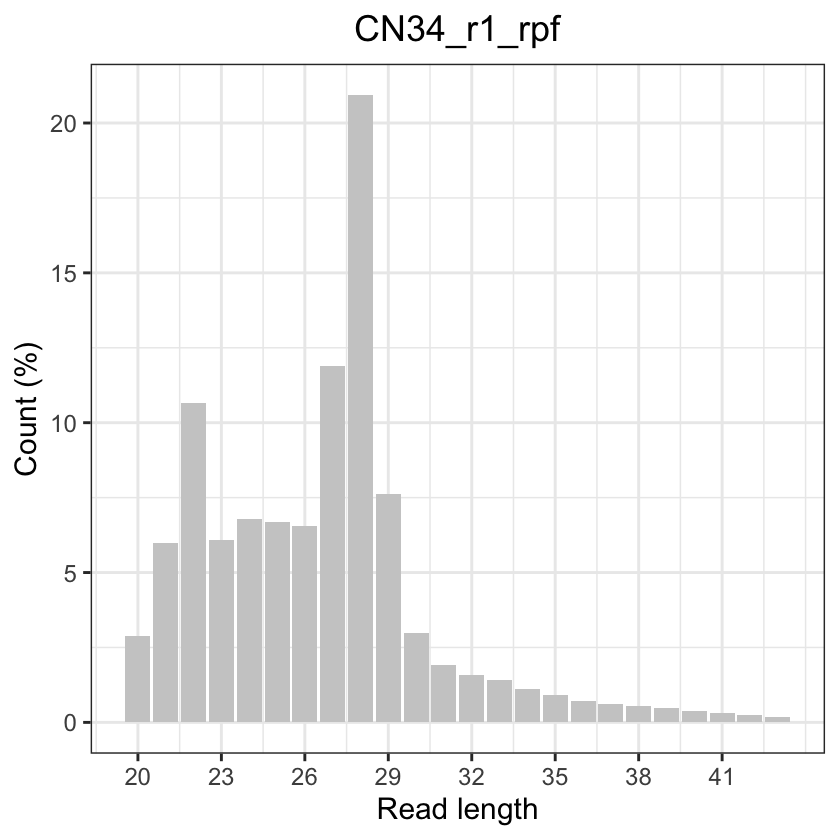

Warning message:
“Removed 21 rows containing missing values (position_stack).”


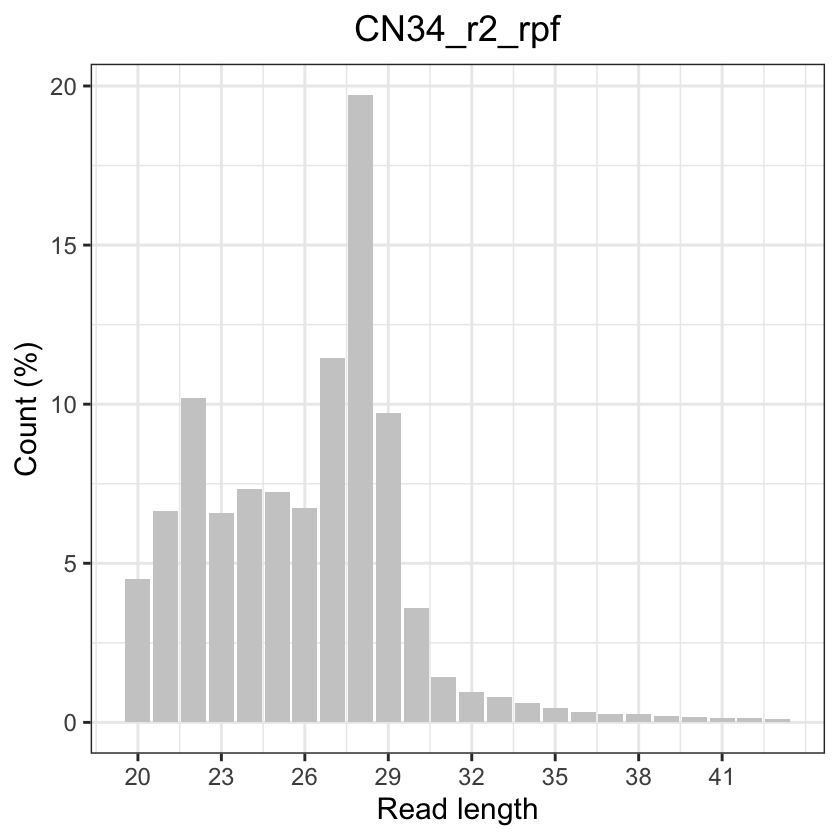

Warning message:
“Removed 23 rows containing missing values (position_stack).”


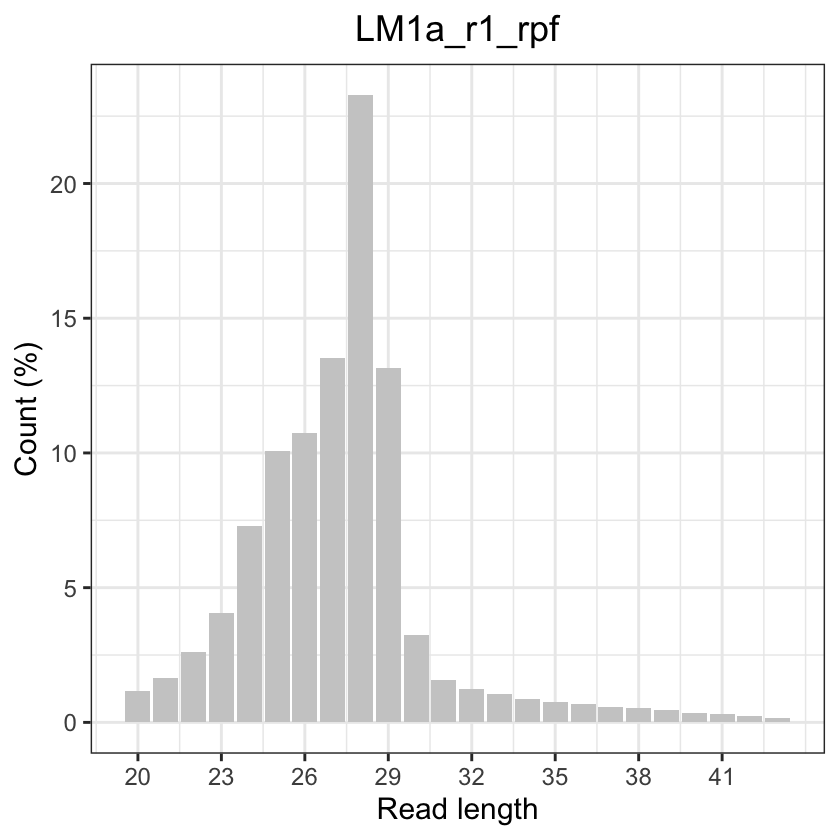

Warning message:
“Removed 23 rows containing missing values (position_stack).”


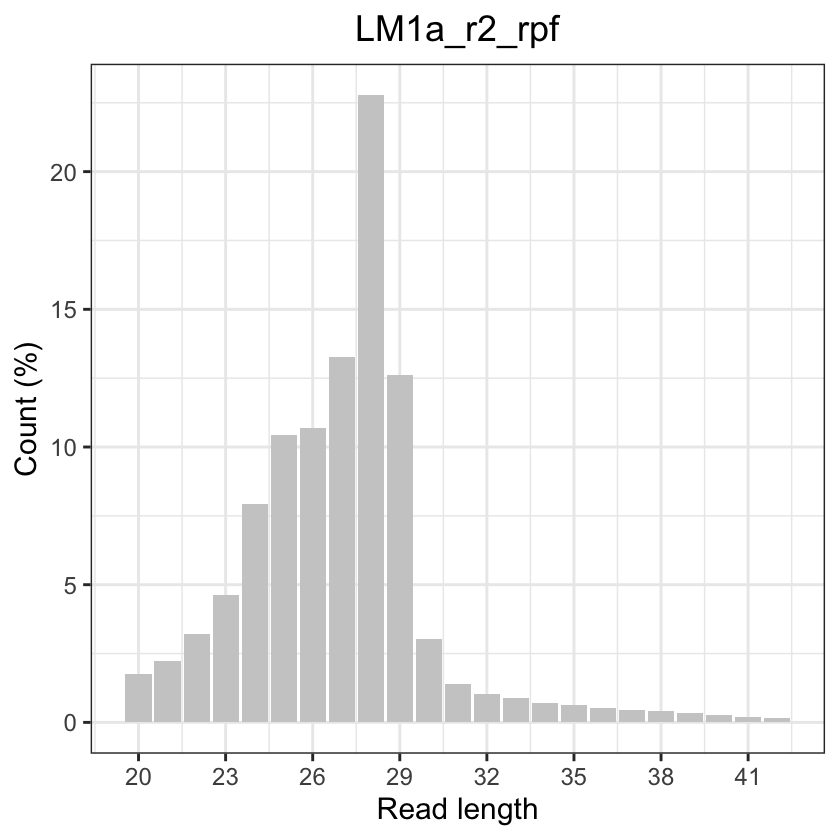

Warning message:
“Removed 26 rows containing missing values (position_stack).”


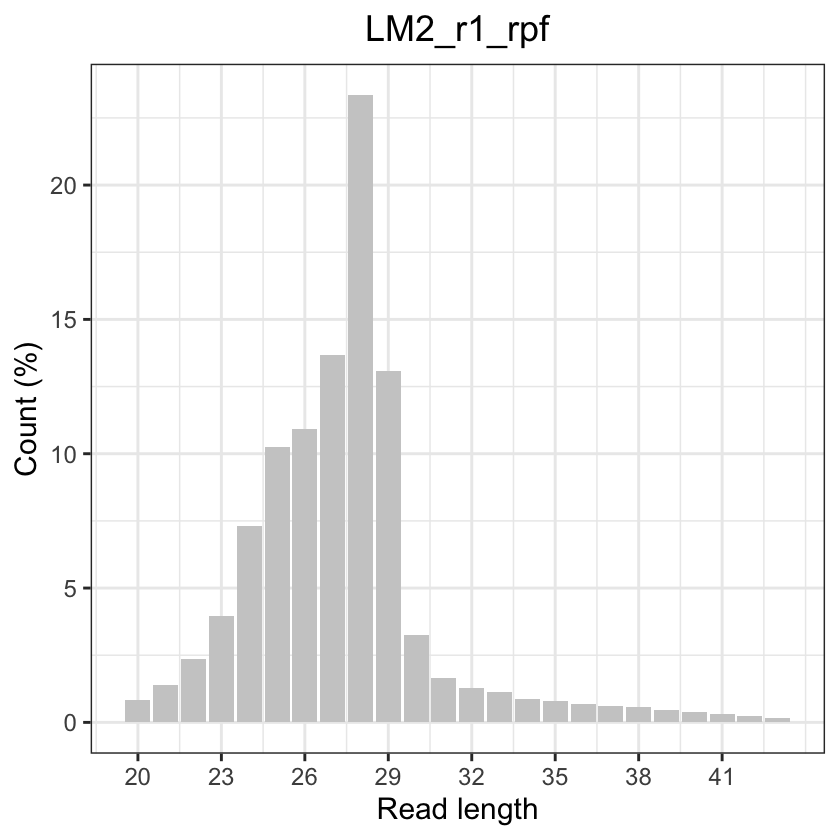

Warning message:
“Removed 22 rows containing missing values (position_stack).”


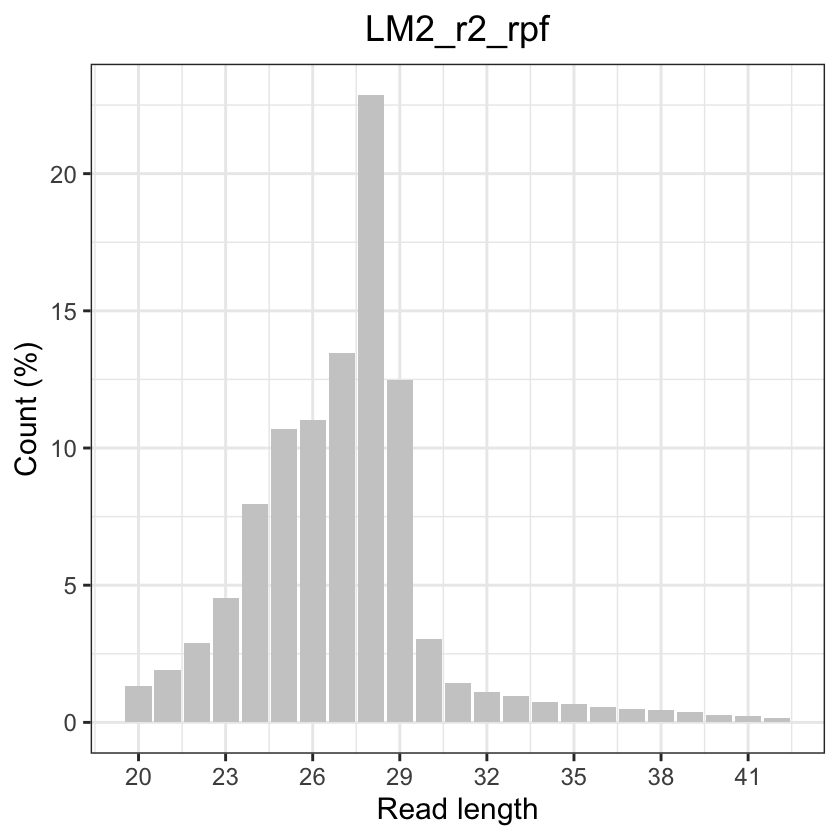

Warning message:
“Removed 23 rows containing missing values (position_stack).”


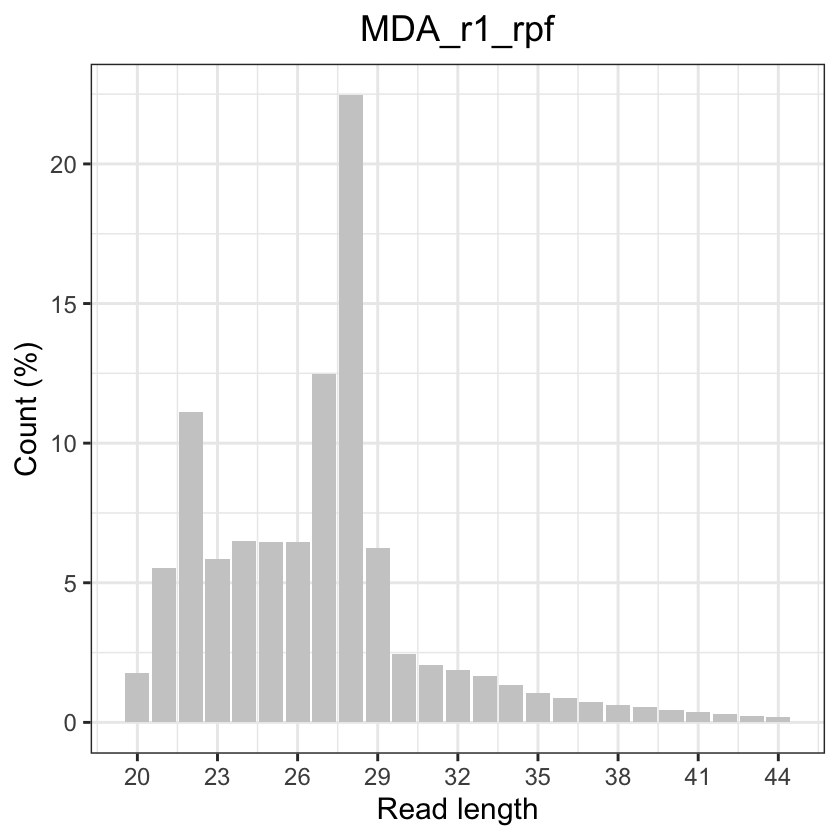

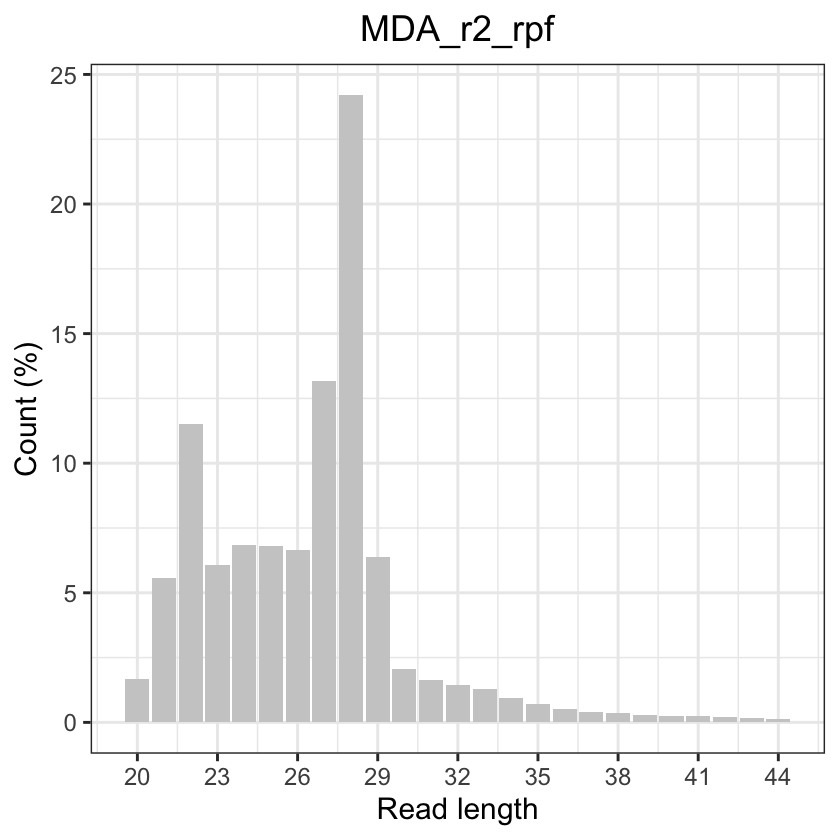

In [12]:
Ribolog::print_read_ldist(reads_list)

<b> You can also export the visualisations to a PDF by specifying a output PDF name. </b>

In [13]:
Ribolog::print_read_ldist(reads_list, outfile='reads_length_distribution.pdf')

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 28 rows containing missing values (position_stack).”
Warning message:
“Removed 21 rows containing missing values (position_stack).”
Warning message:
“Removed 23 rows containing missing values (position_stack).”
Warning message:
“Removed 23 rows containing missing values (position_stack).”
Warning message:
“Removed 26 rows containing missing values (position_stack).”
Warning message:
“Removed 22 rows containing missing values (position_stack).”
Warning message:
“Removed 23 rows containing missing values (position_stack).”


[1] "PDF (reads_length_distribution.pdf) created and saved"

### Visualizing Periodicity Length

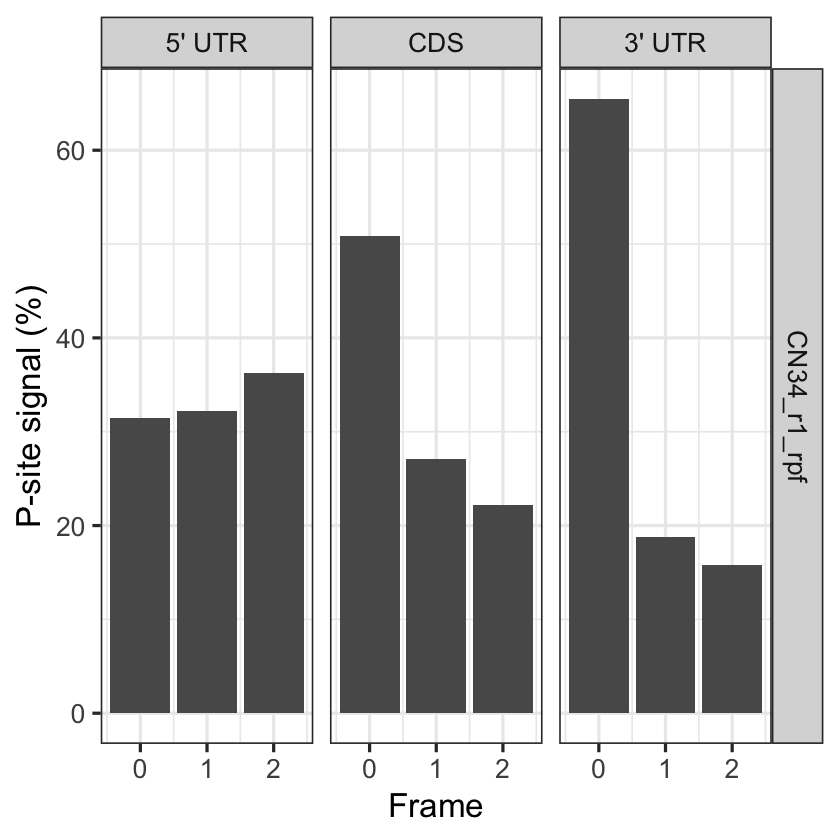

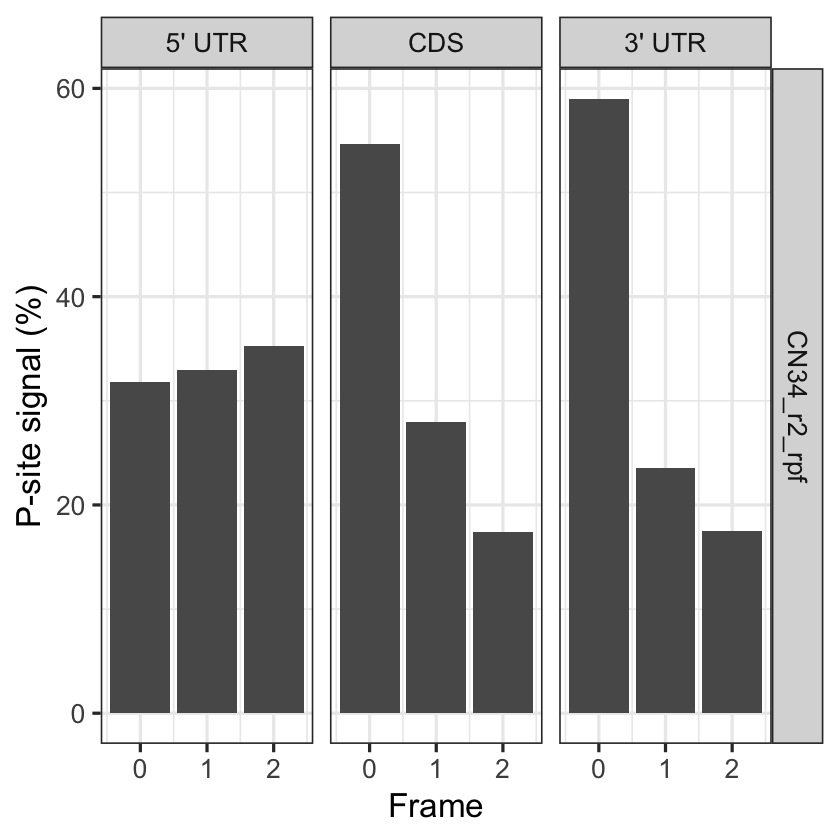

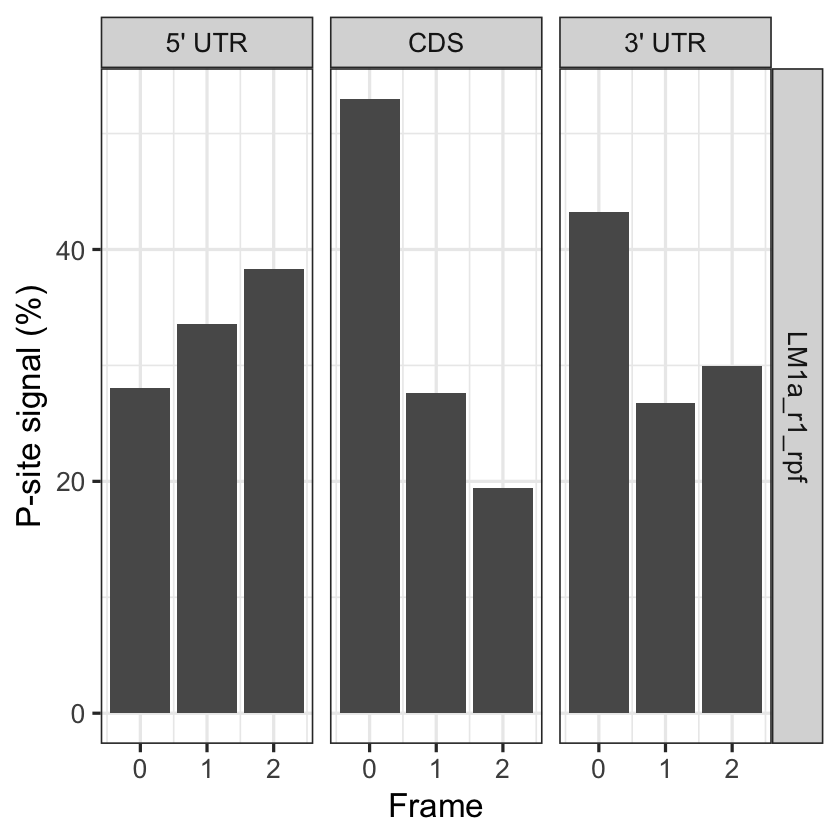

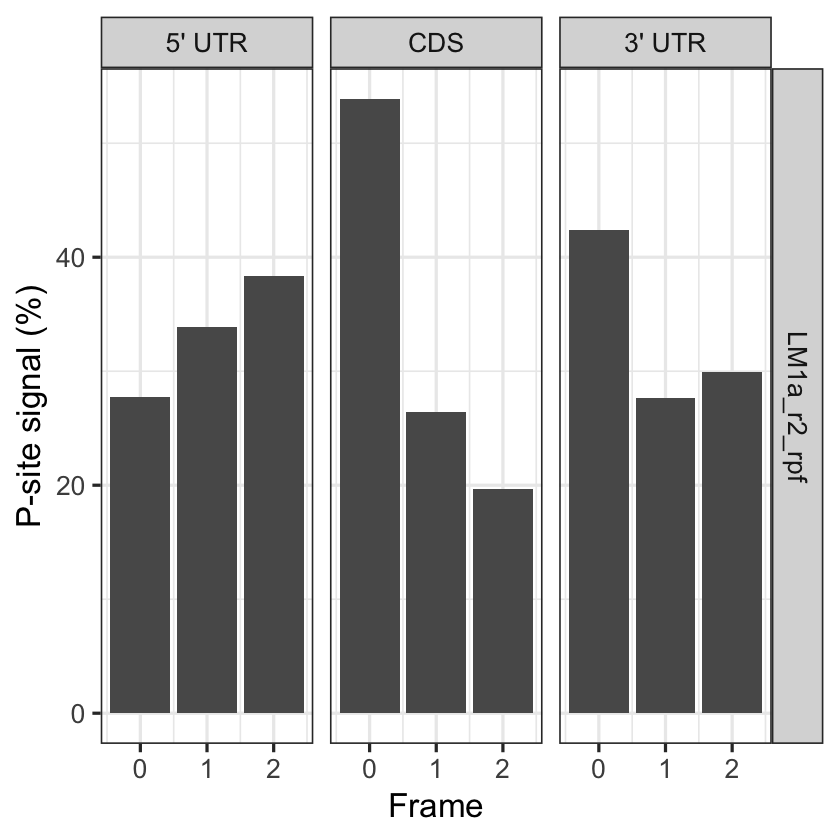

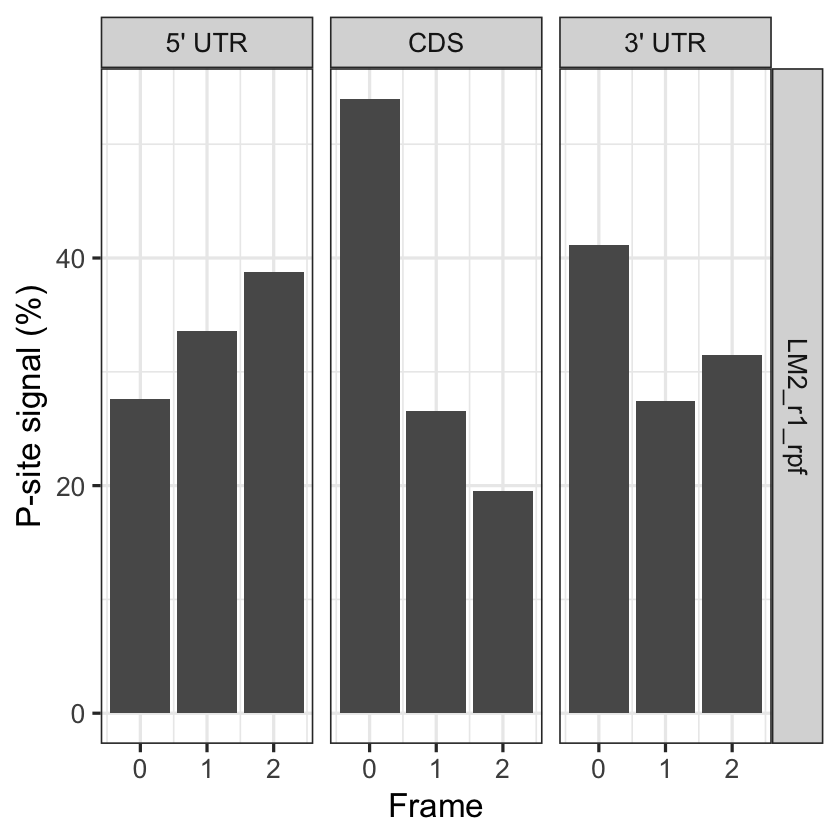

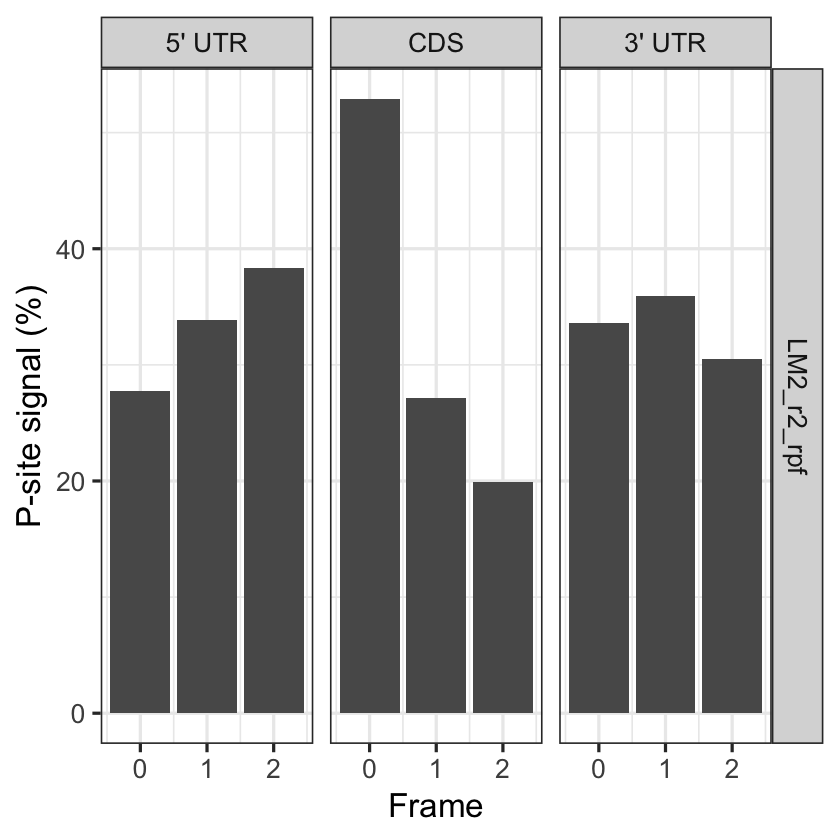

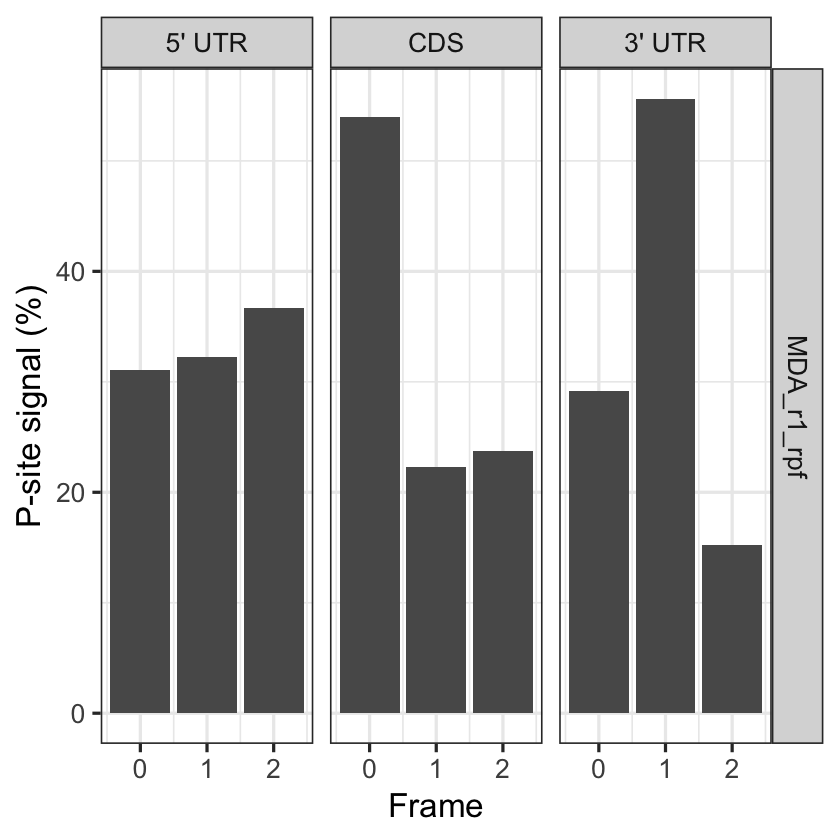

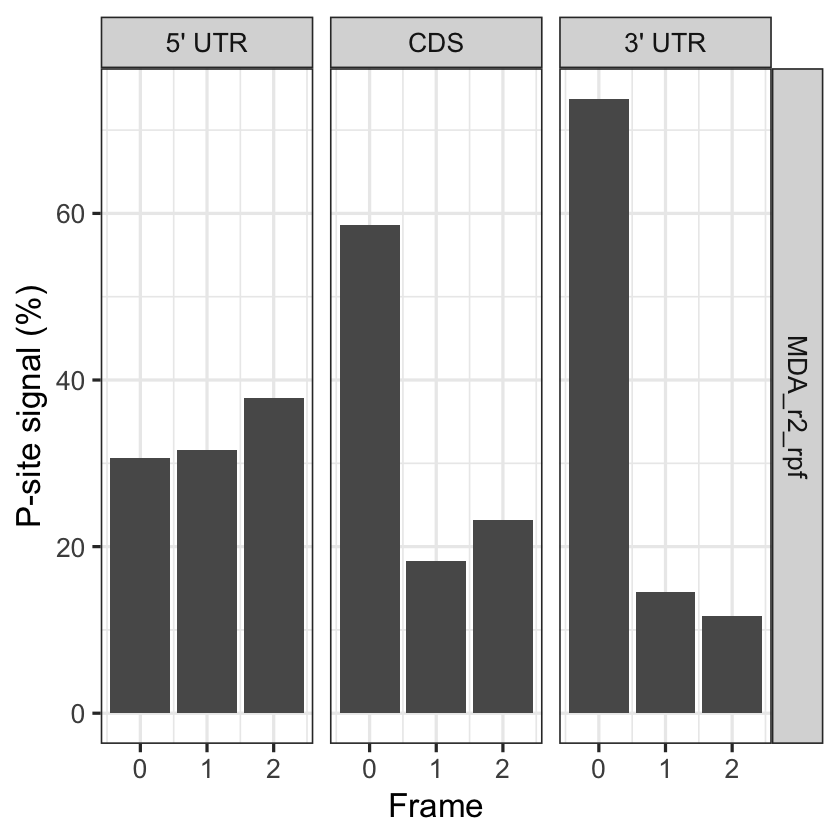

In [10]:
Ribolog::print_period_region(reads_psite_list)

### Visualizing Periodicity Length by Region

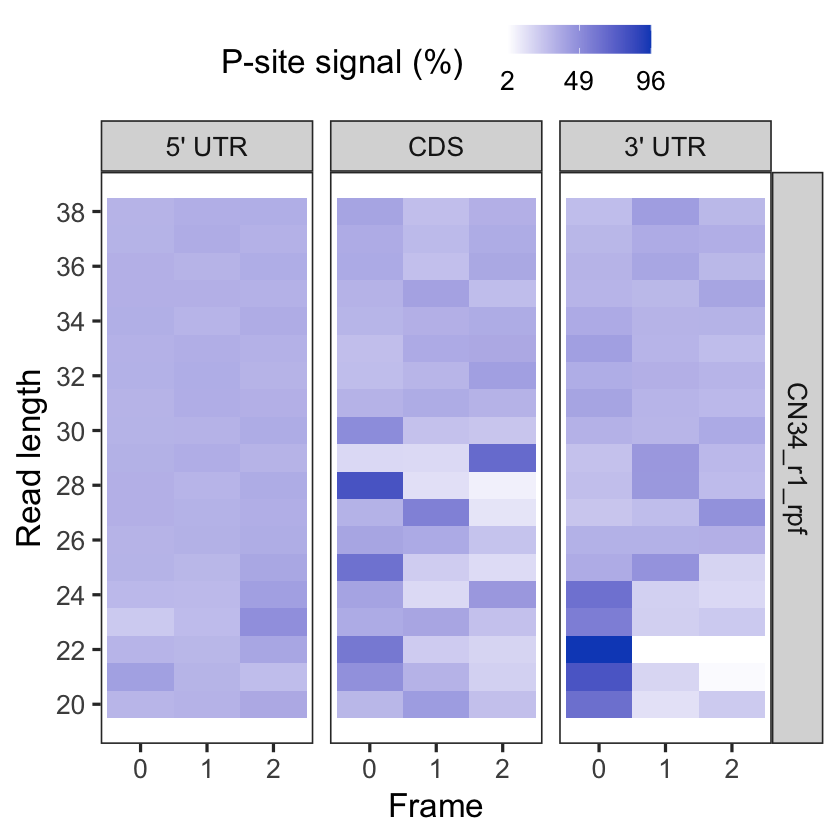

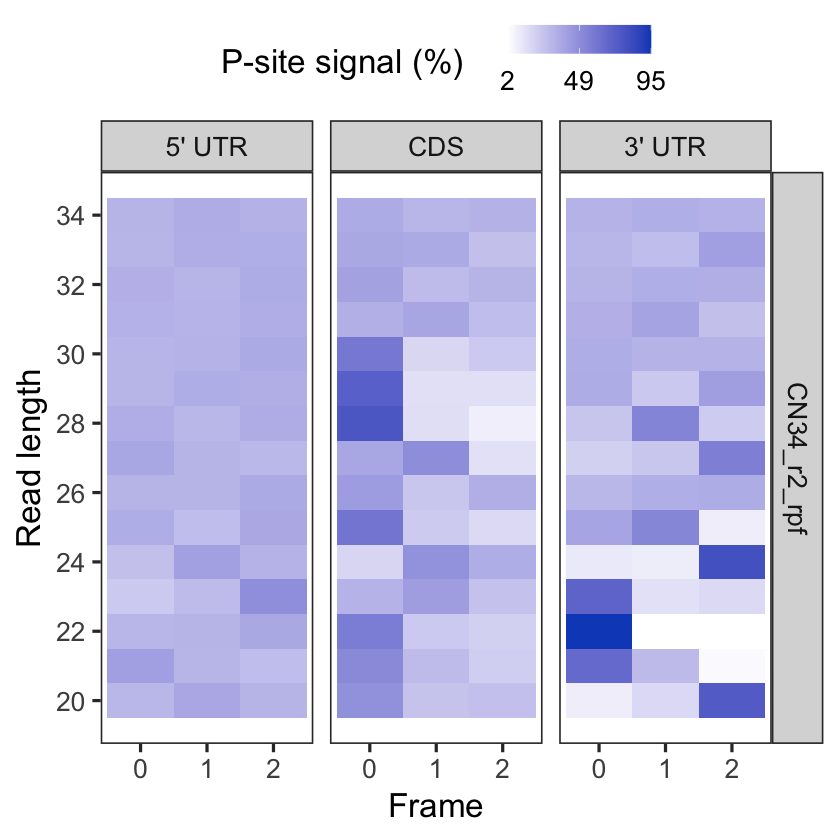

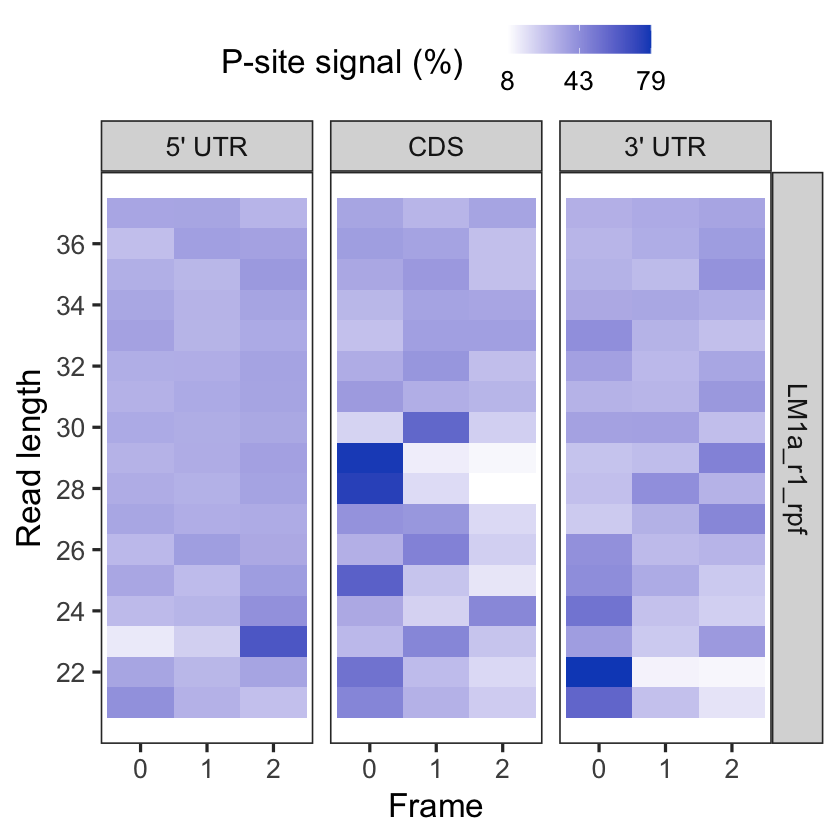

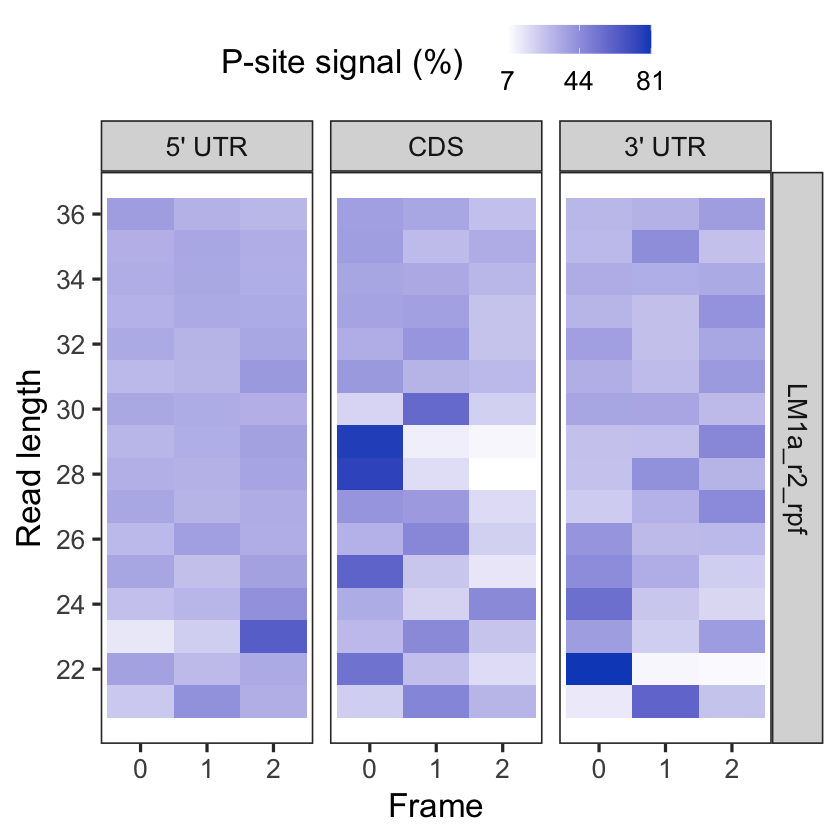

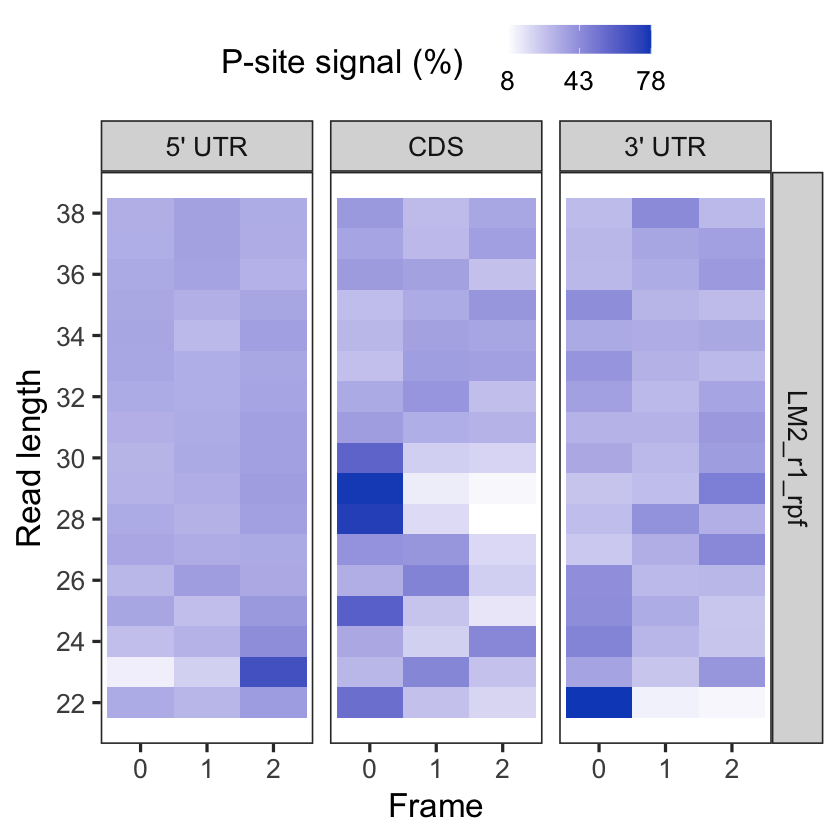

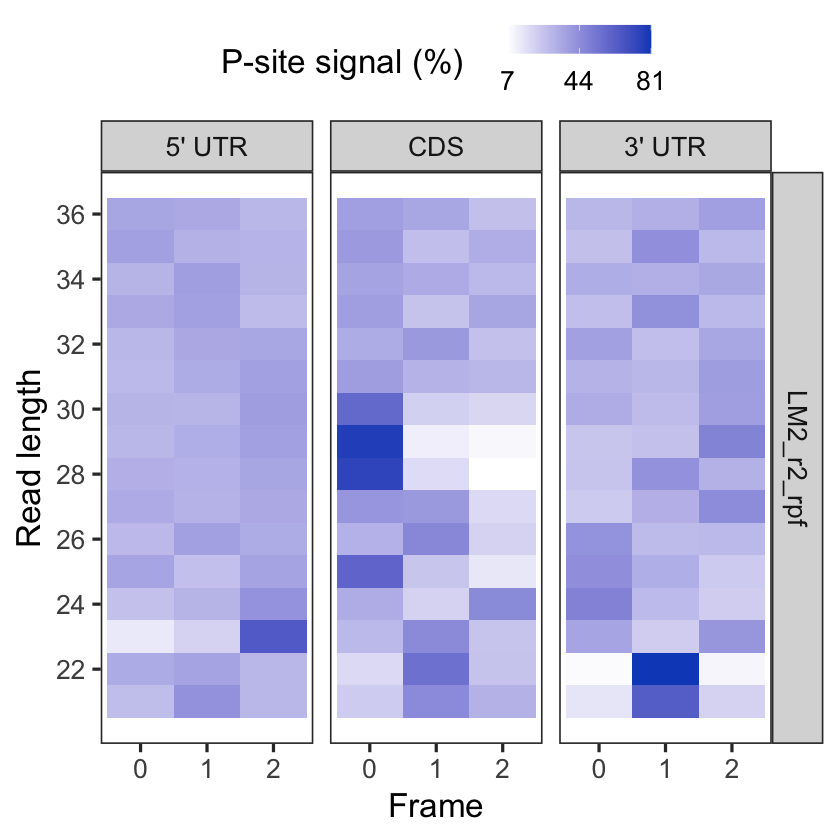

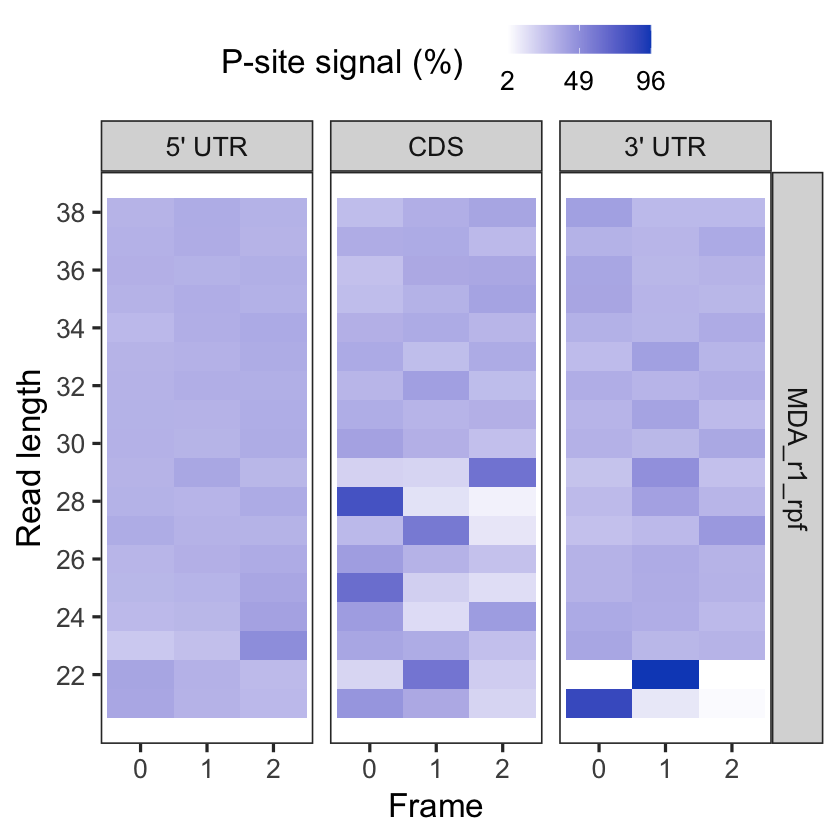

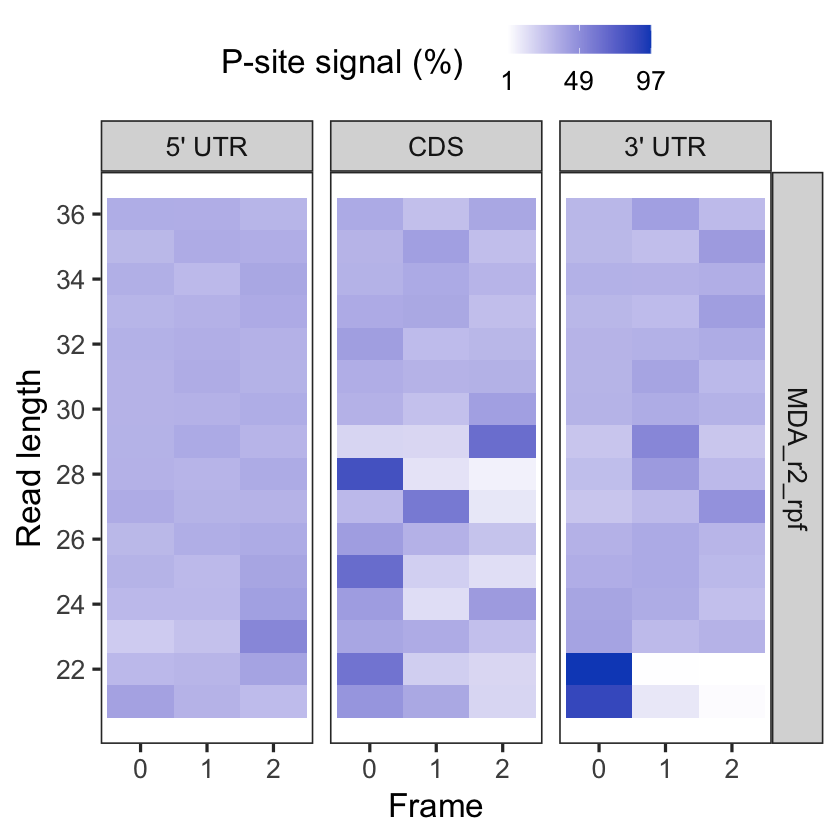

In [23]:
Ribolog::print_period_region_length(reads_psite_list)

- Save the output as a PDF

In [24]:
Ribolog::print_period_region_length(reads_psite_list, outfile='periodicity_by_length_region2.pdf')s

[1] "PDF (periodicity_by_length_region2.pdf) created and saved"

## Part 2: Codon Read Counts and CELP

The psite_to_codon_count function aggregates read p-site data to obtain codon read counts. It generates a tr_codon_read_count object which is a list of lists with the following structure: tr_codon_read_count$<sample.name>$<transcript.ID> data.frame: [1] codon_number [2] codon_type [3] aa_type [4] observed_count.

In [11]:
# Decide your range of the length of the reads that you want to move forward with. We choose 24-32
l_range <- c(24:32)

In [13]:
# Load your CDS fasta file generated from the python script
cDNA_longest_CDS <- 'Human.GRC38.96_cDNA_longest_CDS.txt'

- The average run time for the processing of codon counts is 320 seconds (~5.5 mins) for 4 bam files.

<b> NOTE: </b> You can specify the actual cdna_fasta object or specify a path to the fasta file. The function will process it accordingly.

In [14]:
tr_codon_read_count <- Ribolog::psite_to_codon_count(reads_psite_list,
                                                     length_range = l_range, 
                                                     annotation, 
                                                     fasta_file = cDNA_longest_CDS)

In [ ]:
head(tr_codon_read_count$CN34_r1_rpf$ENST00000000233, n= 10)

| codon_number|codon_type |aa_type | observed_count|
|------------:|:----------|:-------|--------------:|
|            1|ATG        |M       |              0|
|            2|GGC        |G       |              0|
|            3|CTC        |L       |              0|
|            4|ACC        |T       |              0|
|            5|GTG        |V       |              0|
|            6|TCC        |S       |              0|
|            7|GCG        |A       |              0|
|            8|CTC        |L       |              0|
|            9|TTT        |F       |              1|
|           10|TCG        |S       |              1|

### Calculate CELP Bias

- This is the main step in the CELP procedure. The CELP_bias function computes codon-level bias coefficients and bias-corrected read counts.

- The procedure starts with running a loess curve on codon read counts along the transcript to borrow information from neighboring codons mitigating the uncertainty of p-site offset assignment and experimental stochasticity. Loess span parameter is calculated from the user-defined codon_radius (default=5) and CDS length. Then, bias coefficient is calculated for each codon by integrating information on the excess of loess-predicted read counts at that codon comapred to the transcript’s background across samples. Finally, loess predicted count is divided by the bias coefficient to calculate the bias-corrected count. This function can be used in several modes (see function documentation for explanation of arguments). For example, the “direct” fitting method for loess takes longer but does not run into kd-tree-related memory issues. “Gini-moderated” correction ensures that the power of correction is proportional to the original level of heterogenity in read distribution along the transcript.

- Codons with large bias coefficients are those with a consistent excess of reads across samples compared to the transcript background (reproducible peaks). They indicate translational stalling.

- The CELP_bias function returns a list composed of two lists: [1] bias coefficients, and [2] bias-corrected read counts. The bias coefficient list has the following structure: list $<transcript.ID> data.frame: [1] codon_number [2] codon_type [3] aa_type [4] bias_coefficient. 

- The bias-corrected read count list has the following structure: list$<sample.name>$<transcript.ID> data.frame: [1] codon_number [2] codon_type [3] aa_type [4] observed_count [5] bias_coefficient [6] corrected_count.

- The CELP_bias function computes codon-level bias coefficients and bias-corrected read counts.
- This step takes about ~4.5 mins/bam files.

In [15]:
tr_codon_bias_coeff_loess_corrected_count <- Ribolog::CELP_bias(tr_codon_read_count)

<b> Alternatively </b>: You can use the function Ribolog::CELP_detect_bias(tr_codon_read_count) to only extract the bias coefficients but not the corrected read counts. This can also be done for examination purposes.

In [ ]:
head((tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected$CN34_r1_rpf$ENST00000000233)[
    c(30:49), ], n = 20)

|   | codon_number|codon_type |aa_type | observed_count| bias_coefficient| corrected_count|
|:--|------------:|:----------|:-------|--------------:|----------------:|---------------:|
|30 |           30|AAG        |K       |              0|        1.0049040|       2.1898191|
|31 |           31|ACC        |T       |              0|        0.5313807|       2.1983444|
|32 |           32|ACA        |T       |              1|        0.7907074|       0.0000000|
|33 |           33|ATC        |I       |              0|        1.0000000|       0.0000000|
|34 |           34|CTG        |L       |              0|        1.0000000|       0.0000000|
|35 |           35|TAC        |Y       |              6|        1.0000000|       0.0000000|
|36 |           36|AAA        |K       |              1|       10.7156229|       1.1926788|
|37 |           37|CTG        |L       |              1|       24.5521153|       1.2553613|
|38 |           38|AAG        |K       |             61|       35.7132009|       1.3790503|
|39 |           39|TTG        |L       |            103|       32.7251422|       1.4863645|
|40 |           40|GGG        |G       |             14|       24.5573561|       1.6501106|
|41 |           41|GAG        |E       |              1|        7.4377293|       2.1942565|
|42 |           42|ATT        |I       |              1|        1.9181915|       2.0576454|
|43 |           43|GTC        |V       |              0|        0.5766887|       0.0000000|
|44 |           44|ACC        |T       |              0|        0.9115349|       0.0000000|
|45 |           45|ACC        |T       |              1|        0.5489206|       0.0000000|
|46 |           46|ATC        |I       |              0|        0.4993800|       0.7249453|
|47 |           47|CCA        |P       |              0|        0.6708692|       0.5201916|
|48 |           48|ACC        |T       |              1|        0.7333517|       0.4044470|
|49 |           49|ATA        |I       |              0|        1.0000000|       0.0000000|

### Visualize Translational Bias for different transcripts

The function visualize_CELP plots codon-level observed (upward black bars) and corrected (downward purple bars) read counts and the bias coefficient (red line) along the transcript. This allows visual inspection of the prominent bias positions and a comparison of read count heterogeneity along the transcript before and after CELP bias correction.

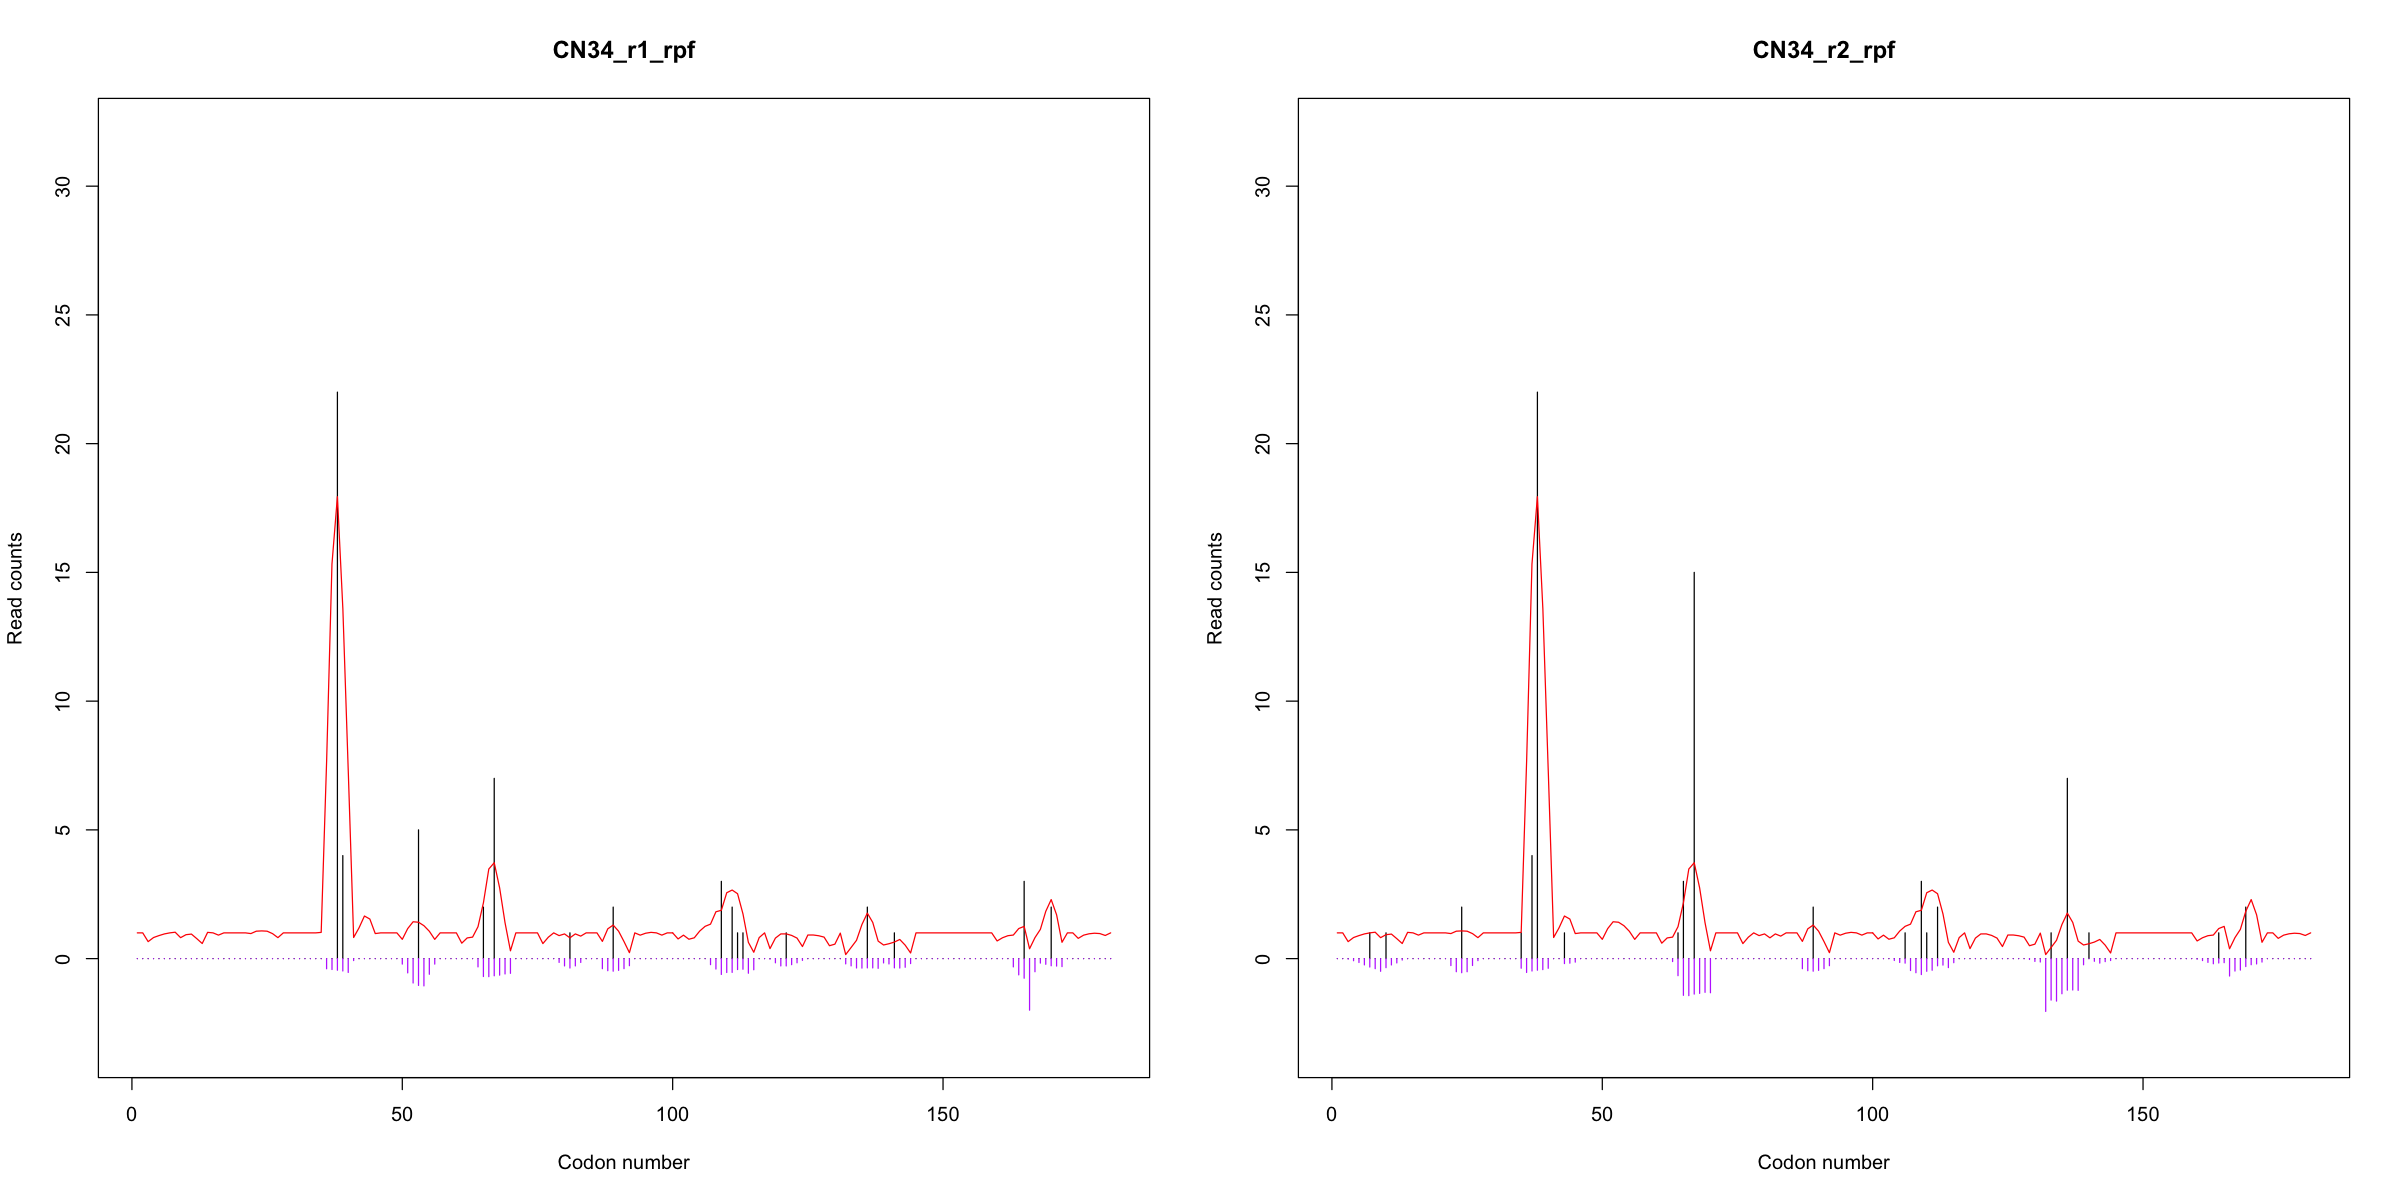

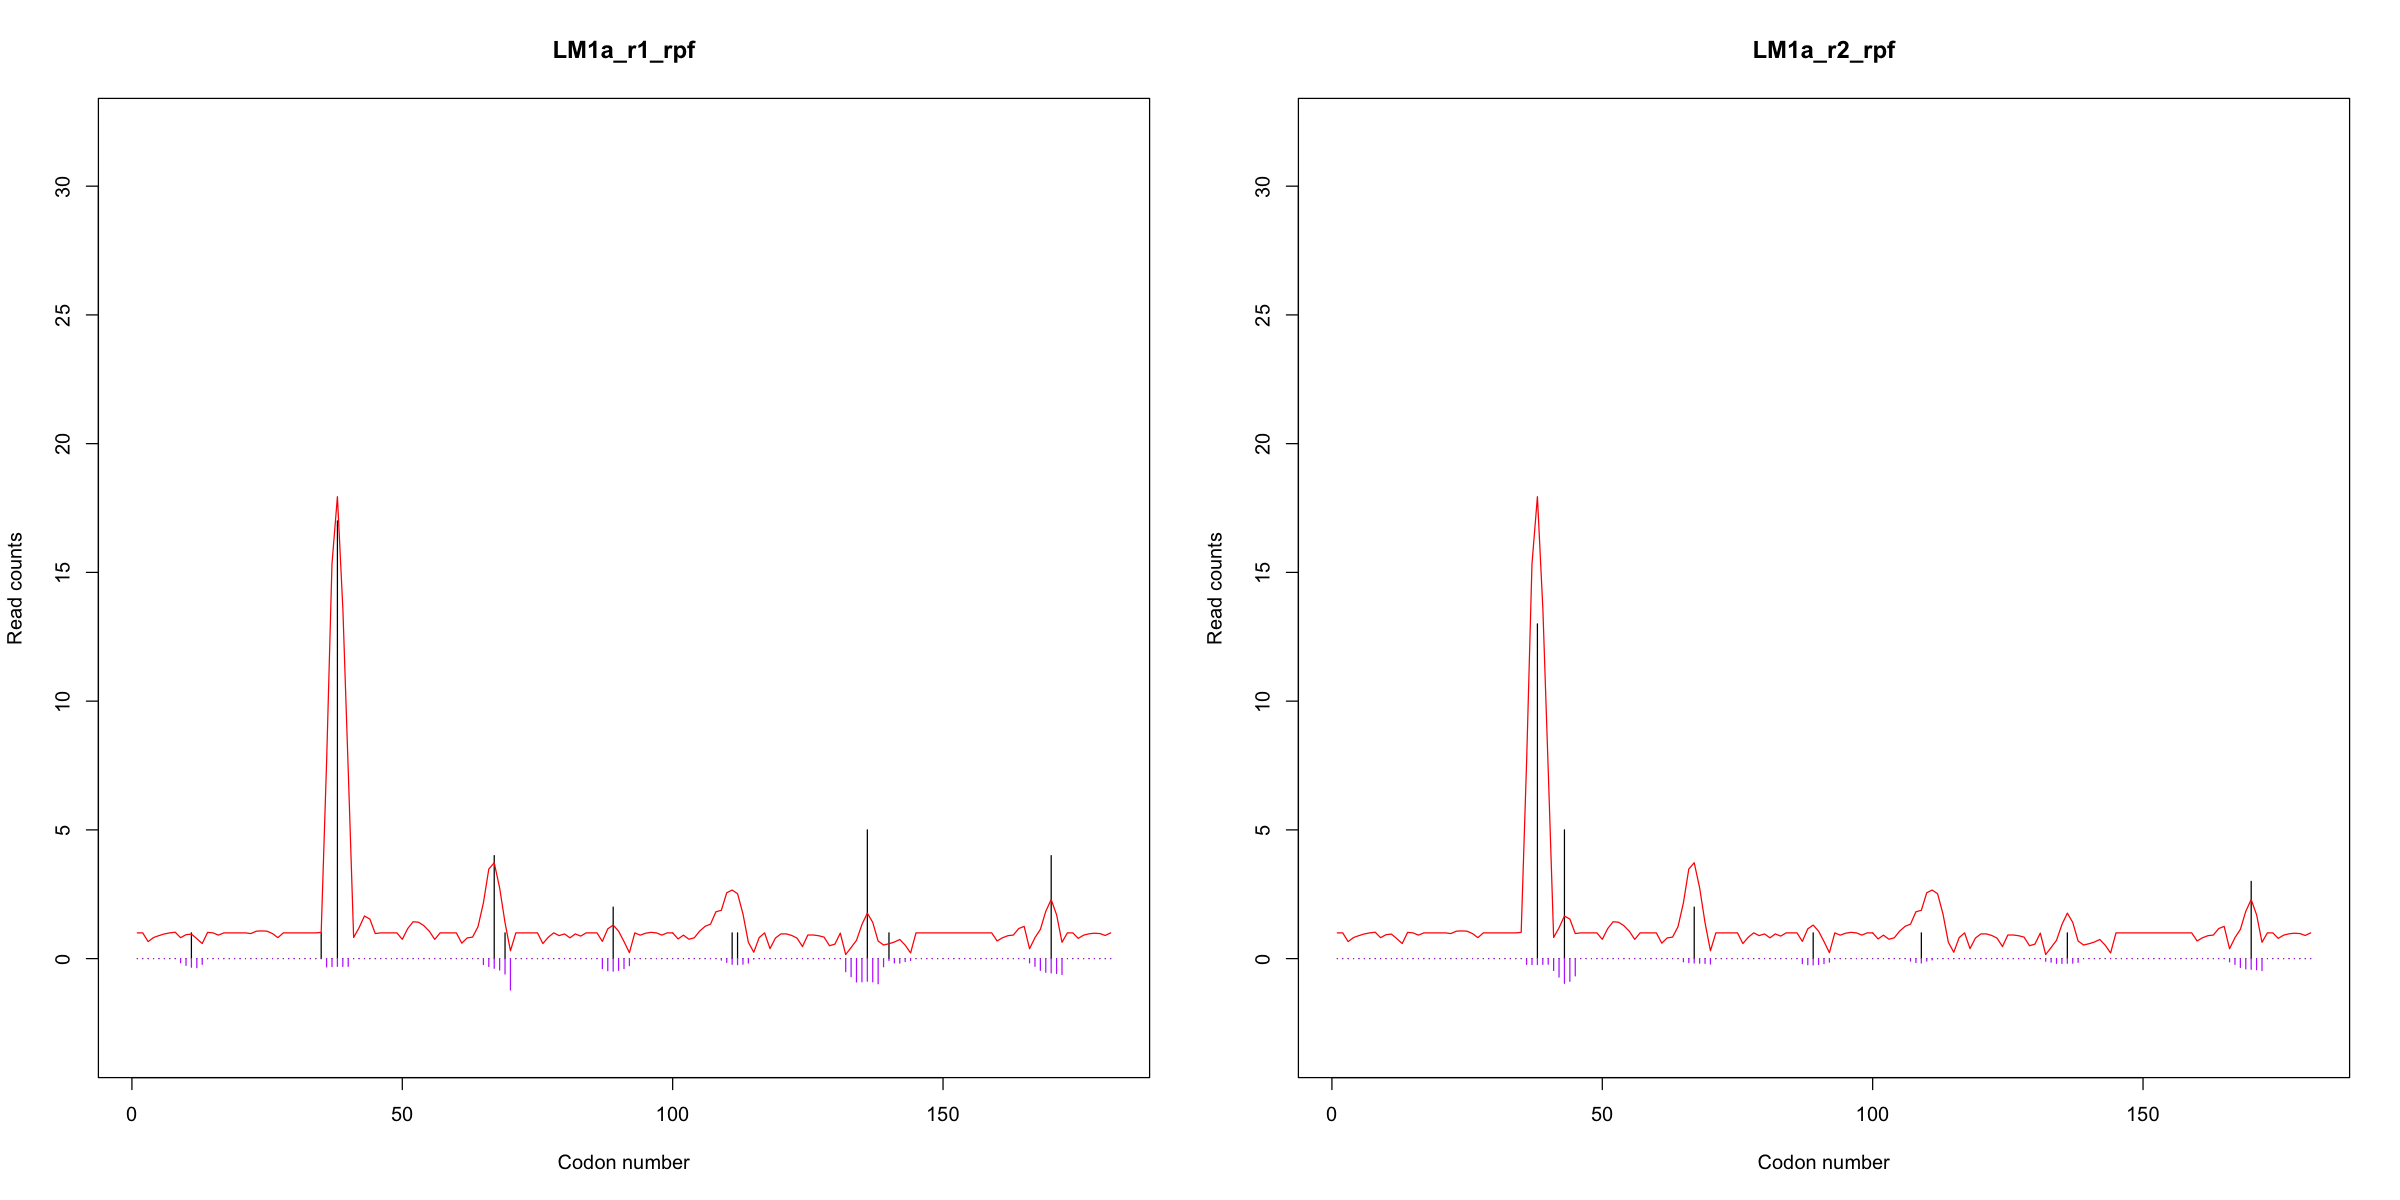

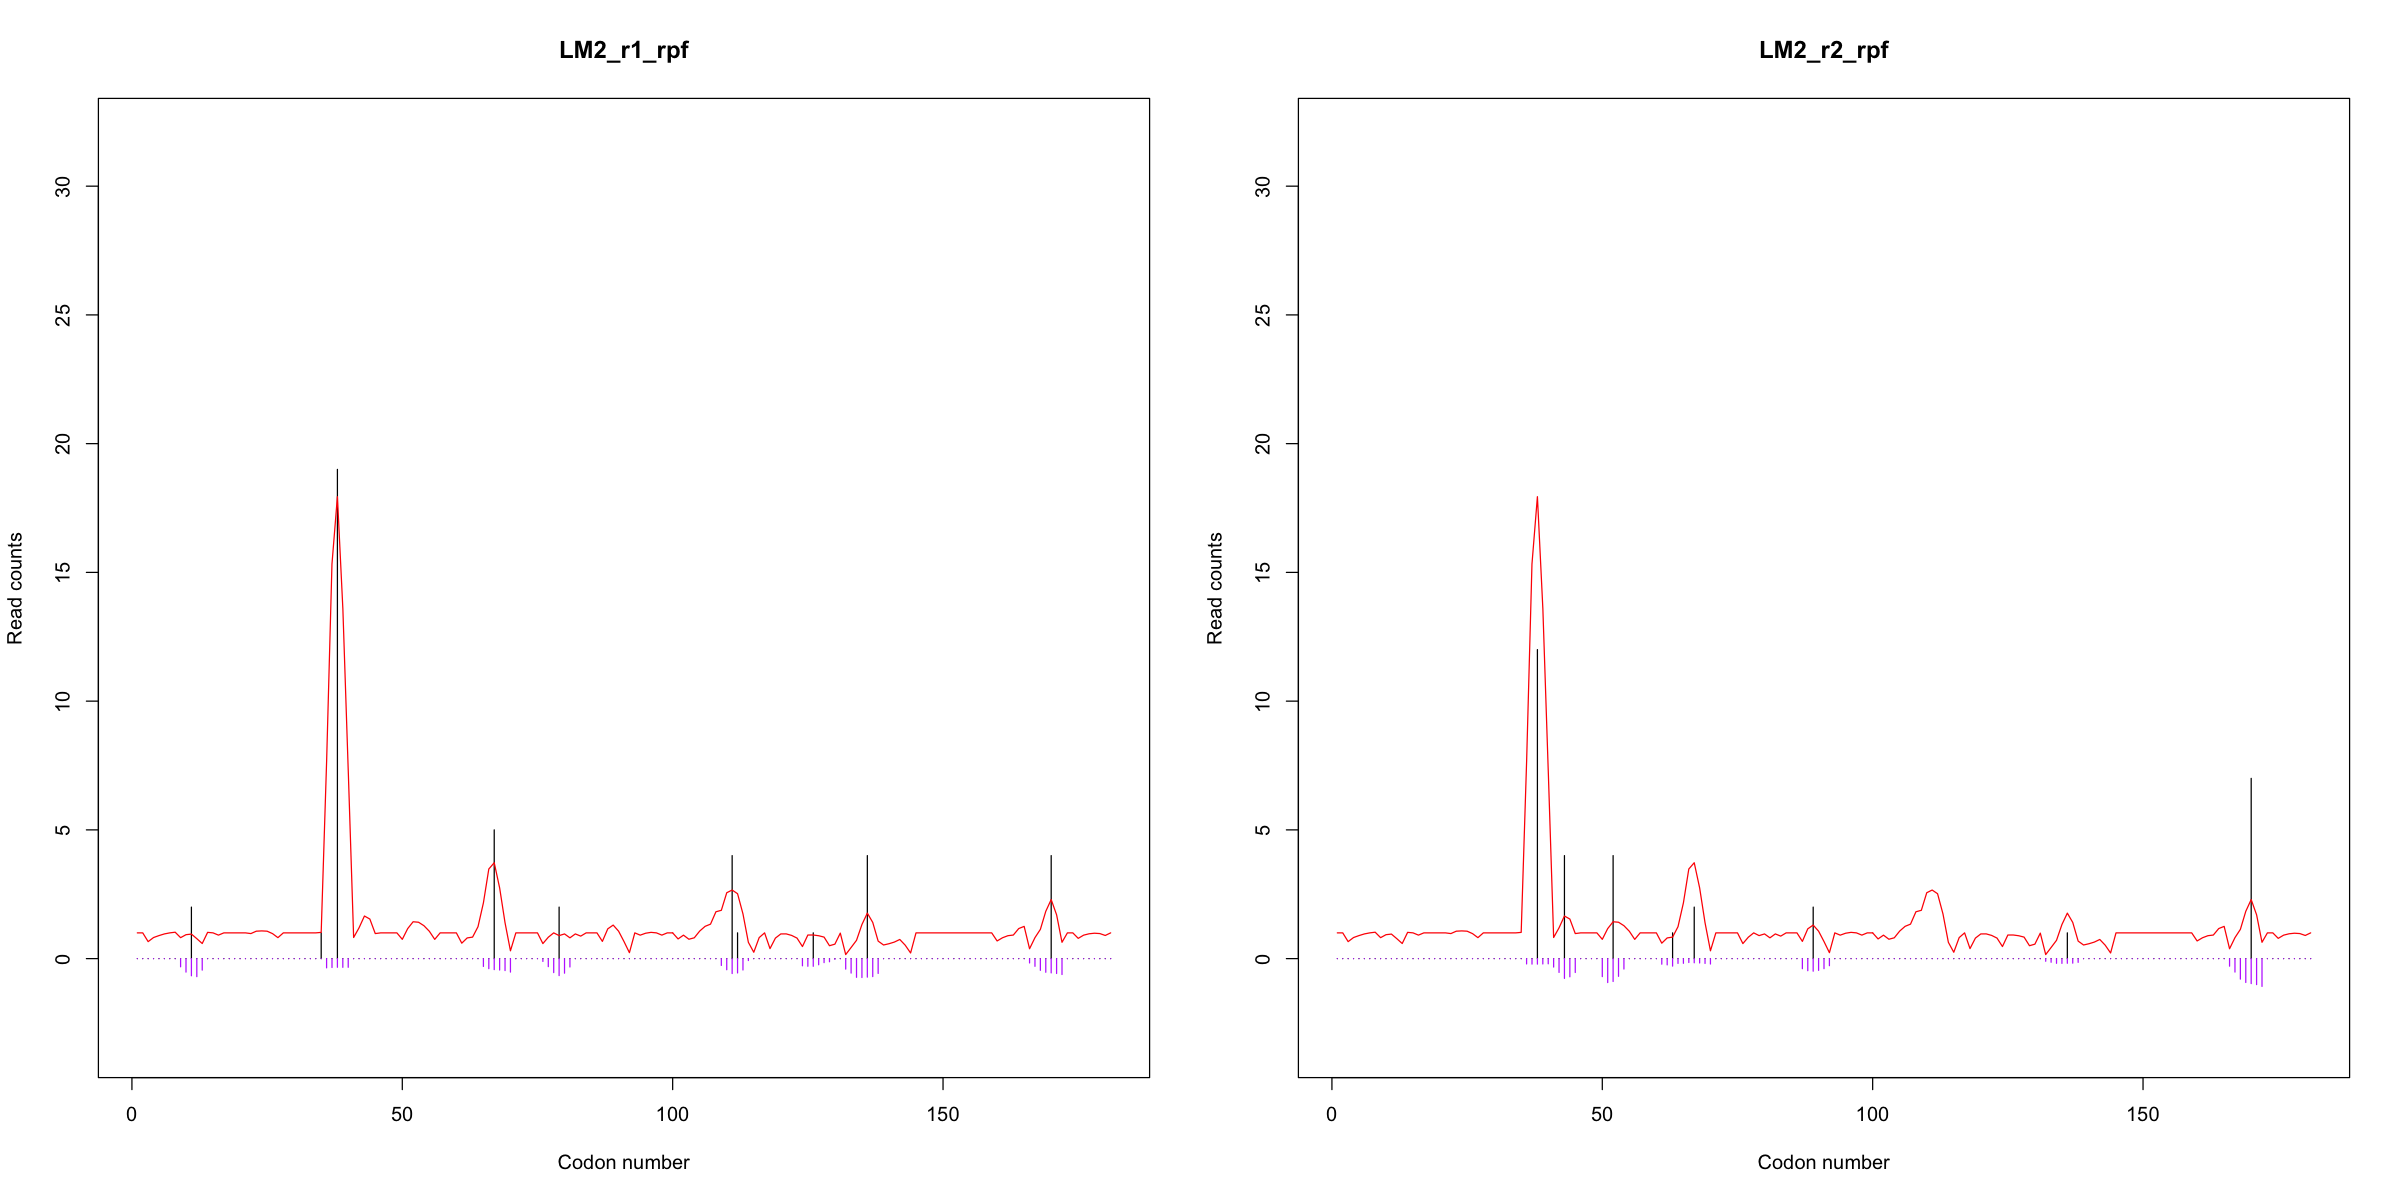

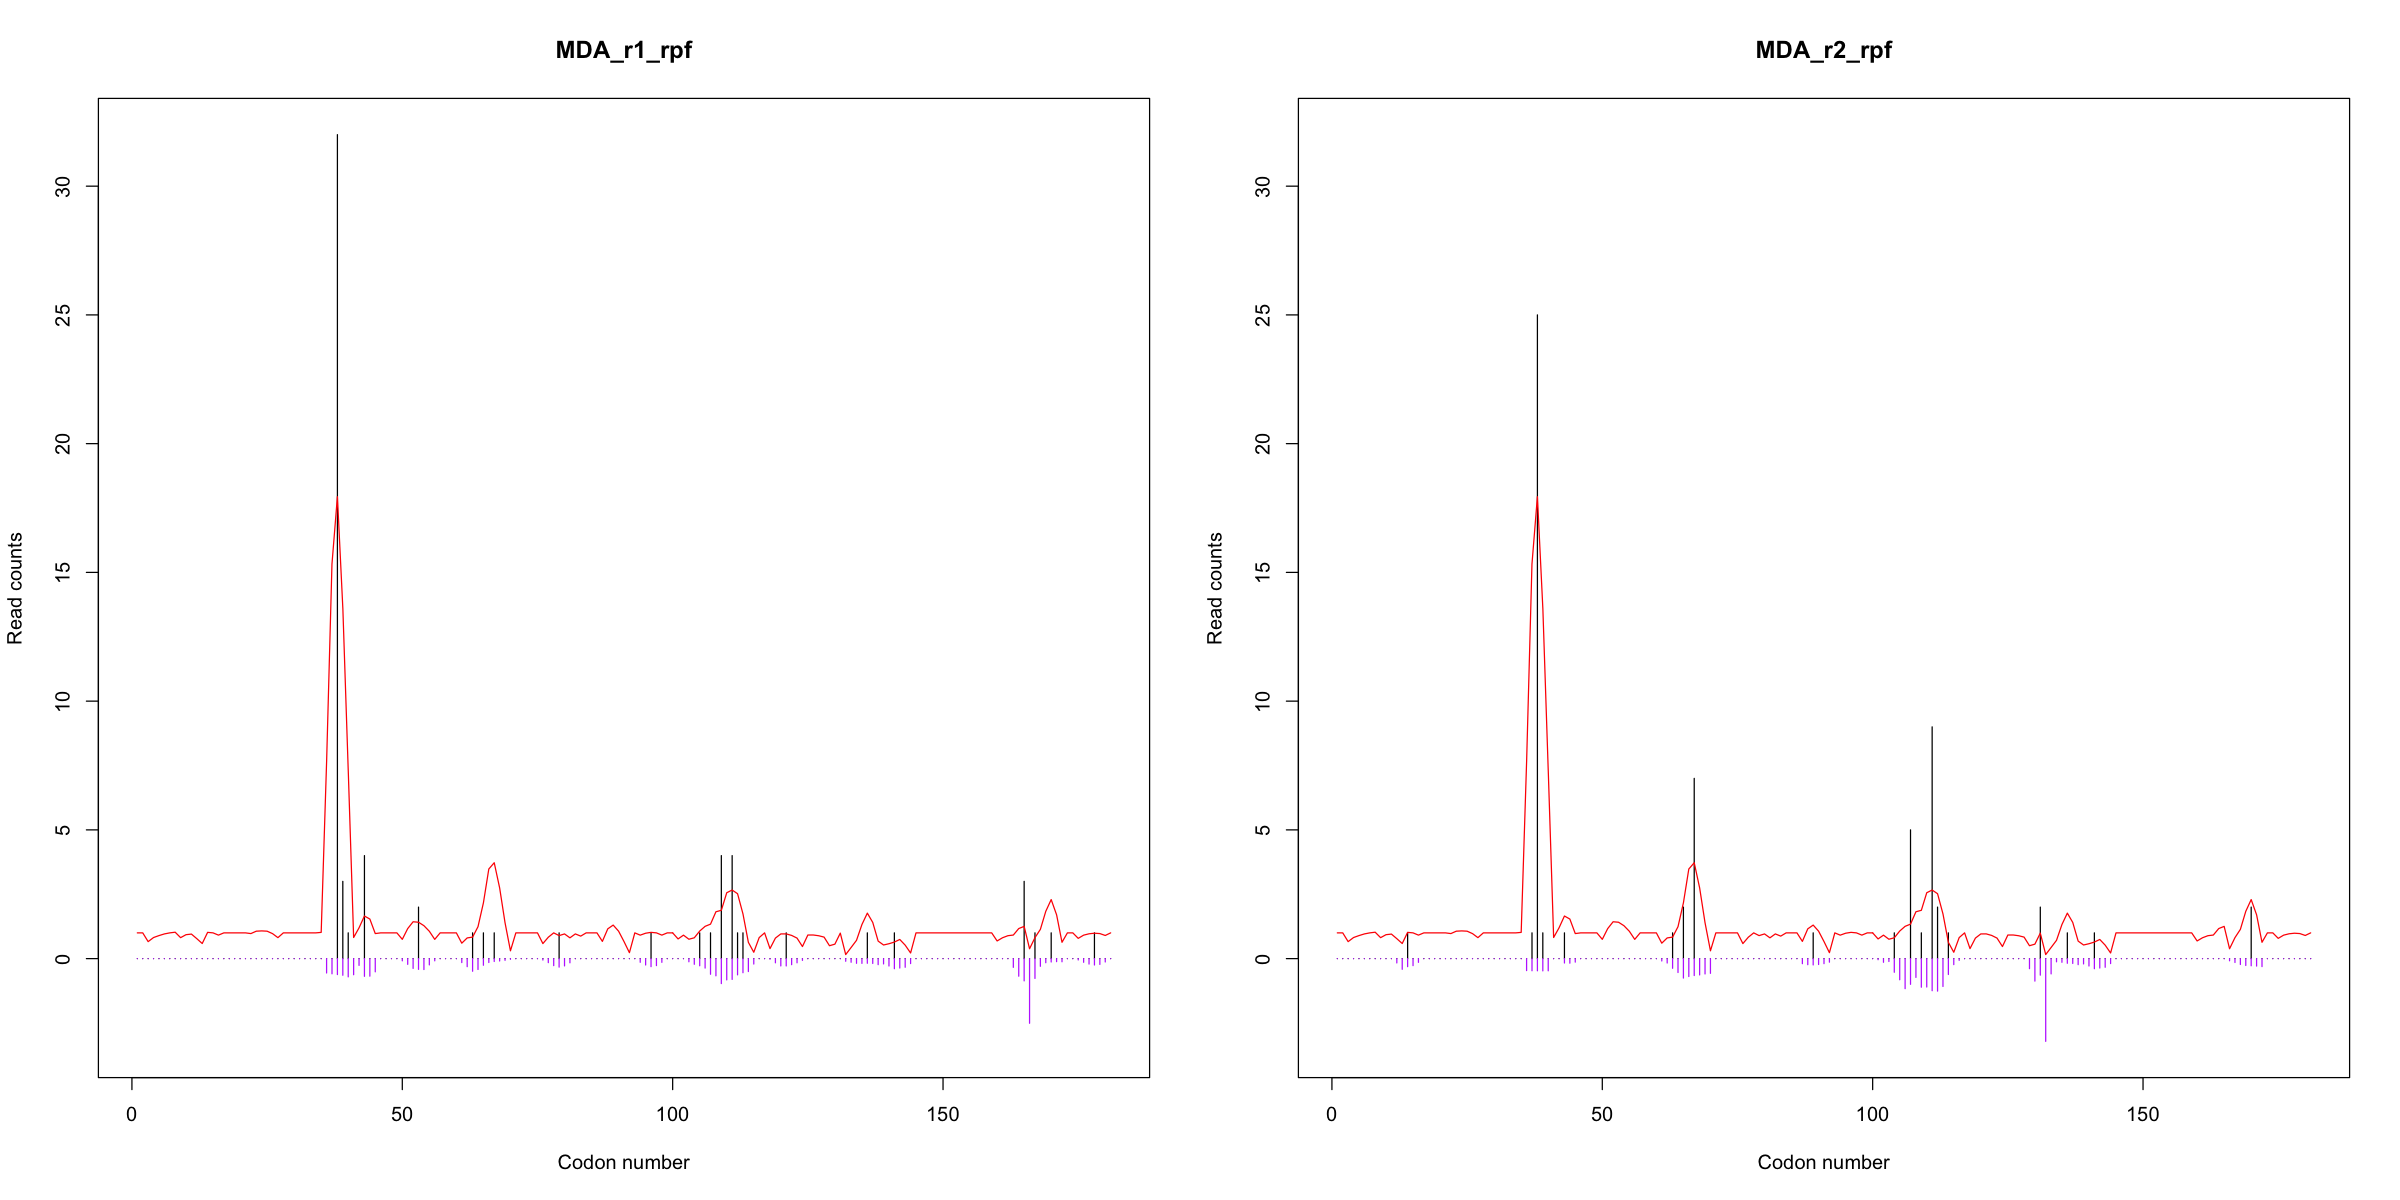

In [31]:
options(repr.plot.width = 20, repr.plot.height = 10)
Ribolog::visualize_CELP(tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected, 
                        transcript = "ENST00000000233", panel_rows = 1, panel_cols = 2)

- Specify an outfile to save it as a PDF

In [32]:
Ribolog::visualize_CELP(tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected, 
                        transcript = "ENST00000000233", panel_rows = 2, panel_cols = 4, 
                        outfile='ENST00000000233.CELP.bias.plots.pdf')

[1] "PDF (ENST00000000233.CELP.bias.plots.pdf) created and saved"

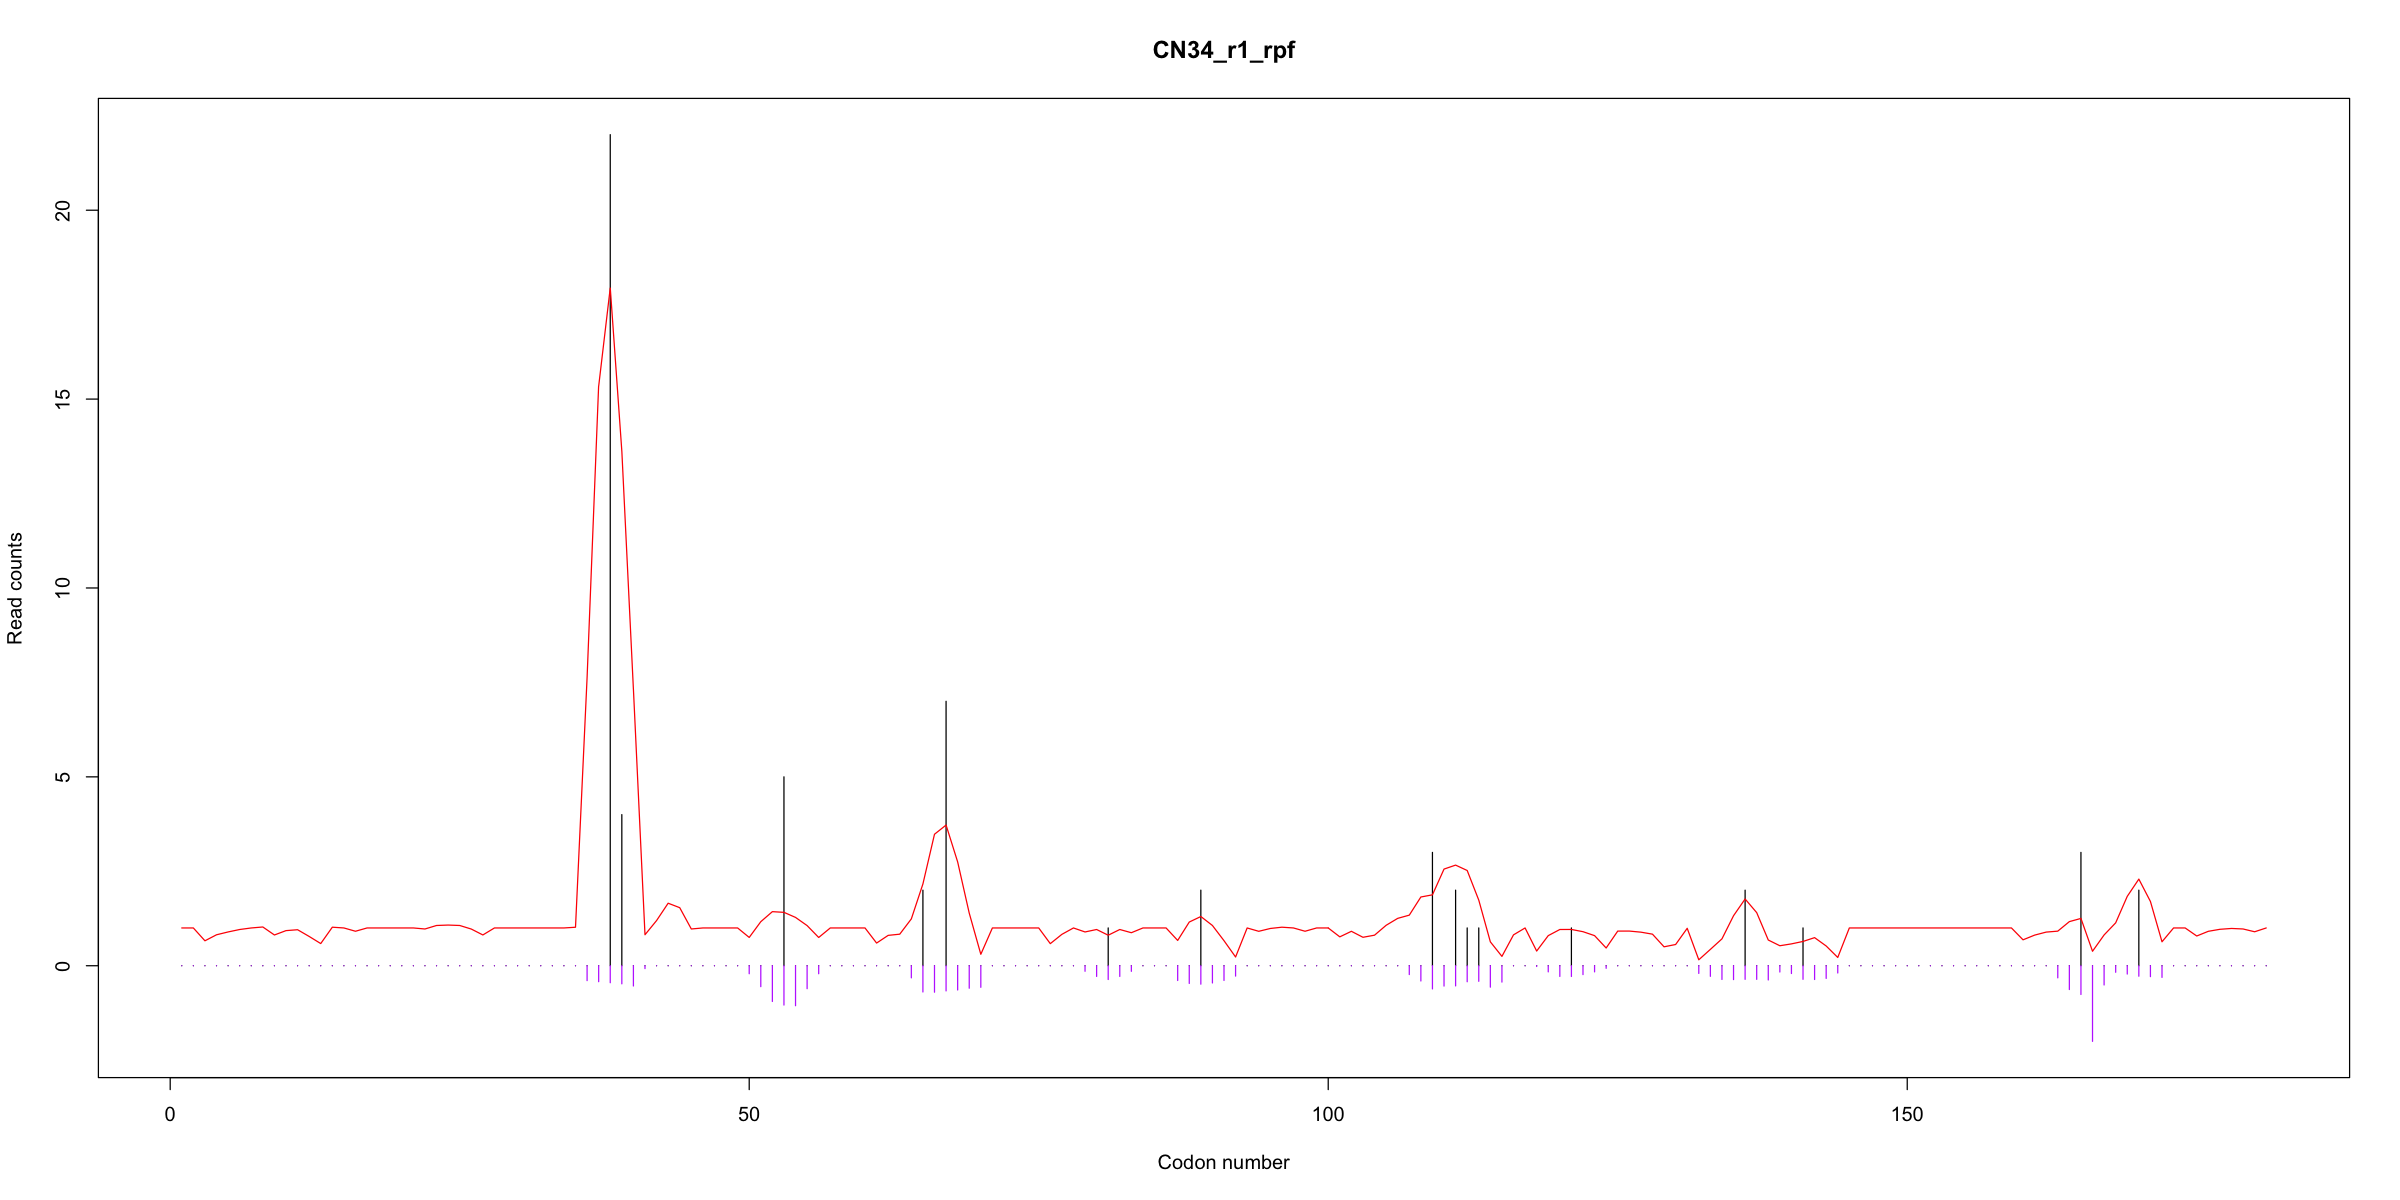

In [33]:
Ribolog::visualize_CELP(tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected["CN34_r1_rpf"], 
                        transcript = "ENST00000000233", panel_rows = 1, panel_cols = 1)

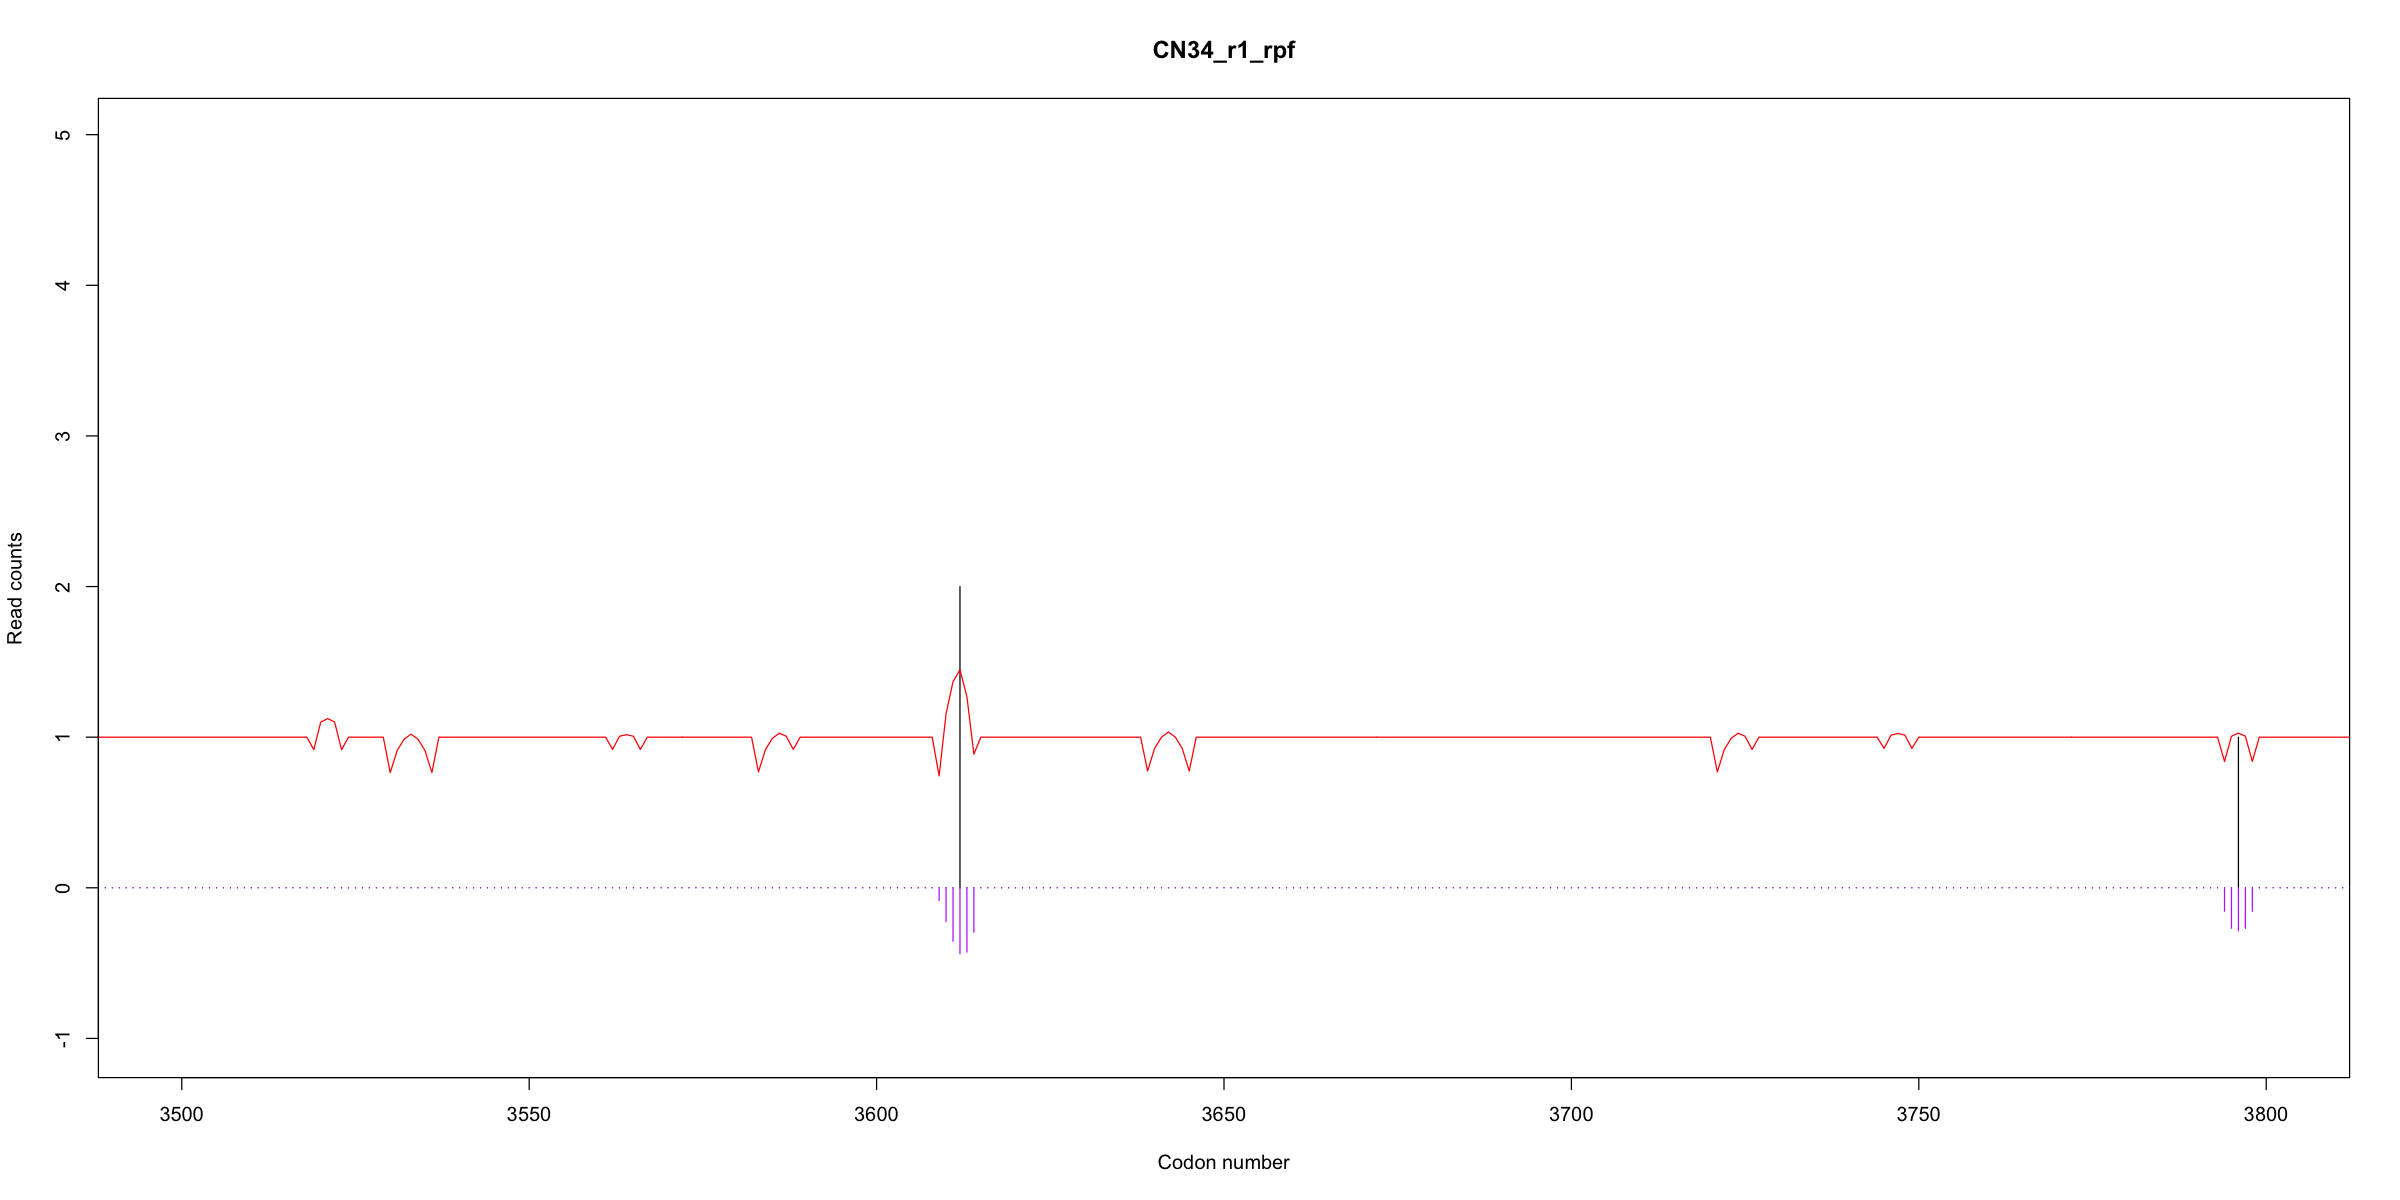

In [34]:
Ribolog::visualize_CELP(tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected["CN34_r1_rpf"], 
                        transcript = "ENST00000367255", from_codon = 3500, to_codon = 3800)

### Generate transcript read counts

- Observed or corrected codon read counts are summed up to produce transcript read counts. The analysis of translational efficiency is usually performed at transcript level.
- The expected execution time for the observed counts is ~5 seconds / bam file.
- The expected execution time for the corrected counts is ~5 seconds / bam file.

In [16]:
rpf_observed_sum <- Ribolog::codon2transcript(
tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected, 
    count_type = "observed_count" ) 

In [ ]:
head(rpf_observed_sum)

|transcript      | CN34_r1_rpf| CN34_r2_rpf| LM1a_r1_rpf| LM1a_r2_rpf| LM2_r1_rpf| LM2_r2_rpf| MDA_r1_rpf| MDA_r2_rpf|
|:---------------|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|
|ENST00000000233 |         590|         533|         284|         223|        321|        298|        502|        477|
|ENST00000000412 |         217|         161|          87|          65|        106|         81|        173|        137|
|ENST00000000442 |          60|          42|          26|          21|         34|         26|         40|         36|
|ENST00000001008 |         635|         597|         477|         390|        476|        493|        540|        520|
|ENST00000001146 |          11|           5|           9|           8|          7|          8|          5|          3|
|ENST00000002125 |          43|          28|           3|          11|          8|         17|         23|         21|

In [17]:
rpf_corrected_sum <- Ribolog::codon2transcript(tr_codon_bias_coeff_loess_corrected_count$tr_codon_read_count_loess_corrected
                                               ,count_type = "corrected_count")

In [ ]:
head(rpf_corrected_sum)

|transcript      | CN34_r1_rpf| CN34_r2_rpf| LM1a_r1_rpf| LM1a_r2_rpf| LM2_r1_rpf| LM2_r2_rpf| MDA_r1_rpf| MDA_r2_rpf|
|:---------------|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|
|ENST00000000233 |   176.30289|  166.150805|  103.883724|   63.769528|  89.241289|  96.336317| 145.892079| 126.287780|
|ENST00000000412 |   133.18892|  104.704272|   50.074178|   42.573251|  61.274603|  55.723701| 101.529527|  80.797405|
|ENST00000000442 |    53.57249|   38.308924|   24.045604|   18.749959|  34.485613|  27.158902|  34.313709|  28.176598|
|ENST00000001008 |   318.88989|  306.586381|  206.258916|  165.199523| 207.981666| 221.579566| 239.968214| 217.801952|
|ENST00000001146 |    12.12084|    5.439828|   10.089170|    8.209649|   7.633892|   8.176429|   5.126584|   3.107706|
|ENST00000002125 |    39.27427|   28.081875|    2.601815|    9.482828|   8.273504|  16.590194|  19.710282|  18.740335|

## Ribolog Module 2

The PREP module includes functions to import, merge and normalize RNA and RPF data. The resulting data set will be ready to be passed on to module 3 for quality control or module 4 for analysis of differential translational efficiency.

- The step below converts specific rna and rpf bam files into counts.
- The average run time is ~12 seconds/bam file.

Create the RNA counts data frame using the bam2count function. Then, merge with the corrected RPF counts data frame produced by the codon2transcript function (covered in module 1).

In [18]:
rna_count <- Ribolog::bam2count(bamfolder='~/Downloads/bam_files/rna', annotation = annotation) 
rpf_count <- Ribolog::bam2count(bamfolder='~/Downloads/bam_files/rpf', annotation = annotation)

In [19]:
rna_rpf_count <- merge(rna_count, rpf_count, by = "transcript")

In [ ]:
head(rna_rpf_count)

|transcript      | CN34_r1_rna| CN34_r2_rna| LM1a_r1_rna| LM1a_r2_rna| LM2_r1_rna| LM2_r2_rna| MDA_r1_rna| MDA_r2_rna| CN34_r1_rpf| CN34_r2_rpf| LM1a_r1_rpf| LM1a_r2_rpf| LM2_r1_rpf| LM2_r2_rpf| MDA_r1_rpf| MDA_r2_rpf|
|:---------------|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|
|ENST00000000233 |         389|         386|         421|         690|        456|        882|        820|        756|         742|         676|         307|         254|        338|        322|        598|        564|
|ENST00000000412 |        1833|        1812|        2393|        3550|       2493|       5121|       2772|       2593|         317|         250|         119|         104|        135|        118|        246|        213|
|ENST00000000442 |         734|         721|         760|        1181|        803|       1489|       1432|       1402|          98|          80|          42|          41|         51|         37|         76|         56|
|ENST00000001008 |        1741|        1602|        2032|        2965|       2094|       4214|       2606|       2478|         936|         867|         582|         479|        576|        605|        748|        702|
|ENST00000001146 |          77|          73|          38|          94|         62|        148|         71|         61|          17|          11|          15|           9|          8|          9|         14|          5|
|ENST00000002125 |         138|         132|         143|         230|        176|        344|        282|        233|          58|          37|           9|          14|         16|         19|         30|         24|

- Merge the RNA counts with the corrected RPF counts data frame produced by the codon2transcript function (covered in module 1).

In [20]:
rna_CELP_rpf_count <- merge(rna_count, rpf_corrected_sum, by = "transcript") 

In [ ]:
head(rna_CELP_rpf_count)

|transcript      | CN34_r1_rna| CN34_r2_rna| LM1a_r1_rna| LM1a_r2_rna| LM2_r1_rna| LM2_r2_rna| MDA_r1_rna| MDA_r2_rna| CN34_r1_rpf| CN34_r2_rpf| LM1a_r1_rpf| LM1a_r2_rpf| LM2_r1_rpf| LM2_r2_rpf| MDA_r1_rpf| MDA_r2_rpf|
|:---------------|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|
|ENST00000000233 |         389|         386|         421|         690|        456|        882|        820|        756|   176.30289|  166.150805|  103.883724|   63.769528|  89.241289|  96.336317| 145.892079| 126.287780|
|ENST00000000412 |        1833|        1812|        2393|        3550|       2493|       5121|       2772|       2593|   133.18892|  104.704272|   50.074178|   42.573251|  61.274603|  55.723701| 101.529527|  80.797405|
|ENST00000000442 |         734|         721|         760|        1181|        803|       1489|       1432|       1402|    53.57249|   38.308924|   24.045604|   18.749959|  34.485613|  27.158902|  34.313709|  28.176598|
|ENST00000001008 |        1741|        1602|        2032|        2965|       2094|       4214|       2606|       2478|   318.88989|  306.586381|  206.258916|  165.199523| 207.981666| 221.579566| 239.968214| 217.801952|
|ENST00000001146 |          77|          73|          38|          94|         62|        148|         71|         61|    12.12084|    5.439828|   10.089170|    8.209649|   7.633892|   8.176429|   5.126584|   3.107706|
|ENST00000002125 |         138|         132|         143|         230|        176|        344|        282|        233|    39.27427|   28.081875|    2.601815|    9.482828|   8.273504|  16.590194|  19.710282|  18.740335|

### Normalize counts for library size variation

By default, we ue the median-of-ratios method for library size normalization. Users can normalize their data in any other way they prefer outside Ribolog and pass on the result to modules 3 and 4. RNA data and RPF data must be normalized separately. The normalize_median_of_ratios function allows specification of data columns, and thus, indepedent normalization of RPF and RNA columns in a mixed RNA-RPF data set.

- The normalize_median_of_ratios function allows specification of data columns, and thus, indepedent normalization of RPF and RNA columns in a mixed RNA-RPF data set.

In [21]:
rna_CELP_rpf_count_norm1 <- Ribolog::normalize_median_of_ratios(rna_CELP_rpf_count, 
                                                                data_columns = c(2:9) )
rna_CELP_rpf_count_norm2 <- Ribolog::normalize_median_of_ratios(rna_CELP_rpf_count_norm1, 
                                                                data_columns = c(10:17) )

[1] "Normalization factors:"
CN34_r1_rna CN34_r2_rna LM1a_r1_rna LM1a_r2_rna  LM2_r1_rna  LM2_r2_rna 
  0.7187785   0.6950616   0.8665587   1.2848121   0.8762268   1.7817562 
 MDA_r1_rna  MDA_r2_rna 
  1.2153191   1.1543571 
[1] "Normalization factors:"
CN34_r1_rpf CN34_r2_rpf LM1a_r1_rpf LM1a_r2_rpf  LM2_r1_rpf  LM2_r2_rpf 
  1.6682204   1.5719904   0.7983419   0.7123556   0.8862848   0.8991526 
 MDA_r1_rpf  MDA_r2_rpf 
  1.2453865   1.0324617 


- Renaming for easy further execution

In [22]:
rr <- rna_CELP_rpf_count_norm2

In [ ]:
head(rr)

|transcript      | CN34_r1_rna| CN34_r2_rna| LM1a_r1_rna| LM1a_r2_rna| LM2_r1_rna| LM2_r2_rna| MDA_r1_rna| MDA_r2_rna| CN34_r1_rpf| CN34_r2_rpf| LM1a_r1_rpf| LM1a_r2_rpf| LM2_r1_rpf| LM2_r2_rpf| MDA_r1_rpf| MDA_r2_rpf|
|:---------------|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|
|ENST00000000233 |    541.1959|    555.3465|   485.82975|   537.04350|  520.41321|  495.01723|  674.71993|  654.90999|  105.683213|  105.694545|  130.124360|    89.51924| 100.691434| 107.141235|  117.14602| 122.317161|
|ENST00000000412 |   2550.1598|   2606.9633|  2761.49782|  2763.04991| 2845.15383| 2874.13065| 2280.88249| 2246.27195|   79.838919|   66.606180|   62.722726|    59.76405|  69.136469|  61.973577|   81.52451|  78.257051|
|ENST00000000442 |   1021.1769|   1037.3182|   877.03232|   919.20055|  916.42941|  835.69235| 1178.29139| 1214.52884|   32.113554|   24.369694|   30.119433|    26.32107|  38.910305|  30.204999|   27.55266|  27.290696|
|ENST00000001008 |   2422.1649|   2304.8318|  2344.90747|  2307.73042| 2389.79226| 2365.08232| 2144.29285| 2146.64940|  191.155731|  195.030702|  258.359140|   231.90599| 234.666850| 246.431556|  192.68573| 210.954032|
|ENST00000001146 |    107.1262|    105.0267|    43.85162|    73.16245|   70.75794|   83.06412|   58.42087|   52.84327|    7.265732|    3.460472|   12.637656|    11.52465|   8.613362|   9.093483|    4.11646|   3.009997|
|ENST00000002125 |    191.9924|    189.9112|   165.02056|   179.01450|  200.86124|  193.06794|  232.03783|  201.84395|   23.542616|   17.863898|    3.259024|    13.31193|   9.335040|  18.450921|   15.82664|  18.151120|

## Module 3: QC of Transcript-level Data

The QC module includes functions to check the quality of ribosome profiling data focusing mainly on the reproducibility of translational efficiency (TE) among replicates. Tools for general QC of sequencing data (e.g. FASTQC) or 3-base periodicity of ribo-seq libraries (borrowed from the riboWaltz package and covered in module 1) are not repeated here.

A minimum read count cutoff is usually applied to sequencing data to remove extremely low count features which would yield unreliable results. To demonstrate, we filter our dataset to keep only transcripts with RNA>=5 in all samples and average RPF>=2 across samples. This can be done using the min_count_filter function. You can choose methods between “all” or “average” and apply different cutoffs until you find a value setting that produces acceptable output in terms of replicate consistency.

### Filter out low count transcripts

In [23]:
rr.v1 <- Ribolog::min_count_filter(rr, mincount = 5, columns = c(2:9), method = "all")

In [24]:
rr.v2 <- Ribolog::min_count_filter(rr.v1, mincount = 2, columns = c(10:17), method = "average")

- Checking the dimensions of the filtered counts

In [25]:
dim(rr)

[1] 19037    17

In [26]:
dim(rr.v1)

[1] 12473    17

In [27]:
dim(rr.v2)

[1] 11182    17

In [ ]:
head(rr.v2)

|transcript      | CN34_r1_rna| CN34_r2_rna| LM1a_r1_rna| LM1a_r2_rna| LM2_r1_rna| LM2_r2_rna| MDA_r1_rna| MDA_r2_rna| CN34_r1_rpf| CN34_r2_rpf| LM1a_r1_rpf| LM1a_r2_rpf| LM2_r1_rpf| LM2_r2_rpf| MDA_r1_rpf| MDA_r2_rpf|
|:---------------|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|
|ENST00000000233 |    541.1959|    555.3465|   485.82975|   537.04350|  520.41321|  495.01723|  674.71993|  654.90999|  105.683213|  105.694545|  130.124360|    89.51924| 100.691434| 107.141235|  117.14602| 122.317161|
|ENST00000000412 |   2550.1598|   2606.9633|  2761.49782|  2763.04991| 2845.15383| 2874.13065| 2280.88249| 2246.27195|   79.838919|   66.606180|   62.722726|    59.76405|  69.136469|  61.973577|   81.52451|  78.257051|
|ENST00000000442 |   1021.1769|   1037.3182|   877.03232|   919.20055|  916.42941|  835.69235| 1178.29139| 1214.52884|   32.113554|   24.369694|   30.119433|    26.32107|  38.910305|  30.204999|   27.55266|  27.290696|
|ENST00000001008 |   2422.1649|   2304.8318|  2344.90747|  2307.73042| 2389.79226| 2365.08232| 2144.29285| 2146.64940|  191.155731|  195.030702|  258.359140|   231.90599| 234.666850| 246.431556|  192.68573| 210.954032|
|ENST00000001146 |    107.1262|    105.0267|    43.85162|    73.16245|   70.75794|   83.06412|   58.42087|   52.84327|    7.265732|    3.460472|   12.637656|    11.52465|   8.613362|   9.093483|    4.11646|   3.009997|
|ENST00000002125 |    191.9924|    189.9112|   165.02056|   179.01450|  200.86124|  193.06794|  232.03783|  201.84395|   23.542616|   17.863898|    3.259024|    13.31193|   9.335040|  18.450921|   15.82664|  18.151120|

### Standardize the data

- PCA is a statistical procedure that decomposes the total variance in data to several orthogonal (not linearly correlated) components. The variance in a transcript x sample matrix of read counts originates not only from differences among samples, but also from differences of (mean) counts across transcripts (there is also an interaction term but we will not deal with that just now). The output of PCA is sensitive to the scale of input numbers. If PCA is performed on the raw RNA counts, the pattern will be driven disproportionately by highly expressed genes. The same is true about RPF counts or TE values and highly translated transcripts. It is therefore customary in some applications to center or standardize the data before performing the PCA. Centering the data means subtracting the row mean or column mean from each element. Standardization means dividing the centered data by the corresponding row or column standard deviation. The choice of row- or column- standardization depends on the data type and structure, and the aim of the study. We perform PCA to visualize similarities and distances among samples. Row centering will bring the mean count for each transcript to zero which means that the differences in the average read counts of transctipts will not be incorporated into the total variance. Row standardization accomplishes the same goal but also guranatees that each transcript adds exactly one unit of variance to the variance of the transcript x sample matrix. Thus, all transctipts contribute equally to the PCA pattern.

- First, we need to create a TE data set by dividing RPF columns by their RNA counterparts from the same sample. This is done using the create-te function:

In [28]:
te.v2 <- Ribolog::create_te(rr.v2, idcolumns = 1, rnacolumns = c(2:9), rpfcolumns = c(10:17))

In [ ]:
head(te.v2)

|transcript      | CN34_r1_te| CN34_r2_te| LM1a_r1_te| LM1a_r2_te| LM2_r1_te| LM2_r2_te| MDA_r1_te| MDA_r2_te|
|:---------------|----------:|----------:|----------:|----------:|---------:|---------:|---------:|---------:|
|ENST00000000233 |  0.1952772|  0.1903218|  0.2678394|  0.1666890| 0.1934836| 0.2164394| 0.1736217| 0.1867694|
|ENST00000000412 |  0.0313074|  0.0255493|  0.0227133|  0.0216297| 0.0242997| 0.0215625| 0.0357425| 0.0348386|
|ENST00000000442 |  0.0314476|  0.0234930|  0.0343424|  0.0286347| 0.0424586| 0.0361437| 0.0233836| 0.0224702|
|ENST00000001008 |  0.0789194|  0.0846182|  0.1101788|  0.1004909| 0.0981955| 0.1041958| 0.0898598| 0.0982713|
|ENST00000001146 |  0.0678241|  0.0329485|  0.2881913|  0.1575214| 0.1217300| 0.1094755| 0.0704621| 0.0569608|
|ENST00000002125 |  0.1226227|  0.0940645|  0.0197492|  0.0743623| 0.0464751| 0.0955670| 0.0682071| 0.0899265|

In [29]:
te.v2.cent <- Ribolog::row_center(te.v2, columns = c(2:9)) 
te.v2.stnd <- Ribolog::row_standardize(te.v2, columns = c(2:9))

### Creating the PCA Plots

Only the numerical part of the data set is fed into the pca_qc function which means that the ID column(s) must be manually excluded. The argument n specifies the number of PCs to be plotted. Below, we compare the PCA pattern from the original, low-count removed, row-centered and row-standardized datasets:

- First load the metadata (attributes) of all your samples

In [23]:
sample_attributes <- read.csv("~/Downloads/Ribolog/data-raw/sample_attributes.csv", header = TRUE, 
                              stringsAsFactors=TRUE, sep='\t')

|sample_name |read_type |lung_metastasis |cell_line | replicate_no|replicate_name |cell_line_origin |
|:-----------|:---------|:---------------|:---------|------------:|:--------------|:----------------|
|CN34_r1_rna |RNA       |N               |CN34      |            1|CN34_r1        |CN34             |
|CN34_r2_rna |RNA       |N               |CN34      |            2|CN34_r2        |CN34             |
|LM1a_r1_rna |RNA       |Y               |LM1a      |            1|LM1a_r1        |CN34             |
|LM1a_r2_rna |RNA       |Y               |LM1a      |            2|LM1a_r2        |CN34             |
|LM2_r1_rna  |RNA       |Y               |LM2       |            1|LM2_r1         |MDA              |
|LM2_r2_rna  |RNA       |Y               |LM2       |            2|LM2_r2         |MDA              |
|MDA_r1_rna  |RNA       |N               |MDA       |            1|MDA_r1         |MDA              |
|MDA_r2_rna  |RNA       |N               |MDA       |            2|MDA_r2         |MDA              |
|CN34_r1_rpf |RPF       |N               |CN34      |            1|CN34_r1        |CN34             |
|CN34_r2_rpf |RPF       |N               |CN34      |            2|CN34_r2        |CN34             |
|LM1a_r1_rpf |RPF       |Y               |LM1a      |            1|LM1a_r1        |CN34             |
|LM1a_r2_rpf |RPF       |Y               |LM1a      |            2|LM1a_r2        |CN34             |
|LM2_r1_rpf  |RPF       |Y               |LM2       |            1|LM2_r1         |MDA              |
|LM2_r2_rpf  |RPF       |Y               |LM2       |            2|LM2_r2         |MDA              |
|MDA_r1_rpf  |RPF       |N               |MDA       |            1|MDA_r1         |MDA              |
|MDA_r2_rpf  |RPF       |N               |MDA       |            2|MDA_r2         |MDA              |
​

In [31]:
te <- Ribolog::create_te(rr, idcolumns = 1, rnacolumns = c(2:9), rpfcolumns = c(10:17))
te.fin <- te[is.finite(rowSums(te[, -1])), ]

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.3499 0.2493 0.15414 0.11642 0.11083 0.09583 0.09311
Proportion of Variance 0.4745 0.2409 0.09209 0.05254 0.04761 0.03559 0.03360
Cumulative Proportion  0.4745 0.7154 0.80750 0.86004 0.90765 0.94325 0.97685
                           PC8
Standard deviation     0.07729
Proportion of Variance 0.02315
Cumulative Proportion  1.00000


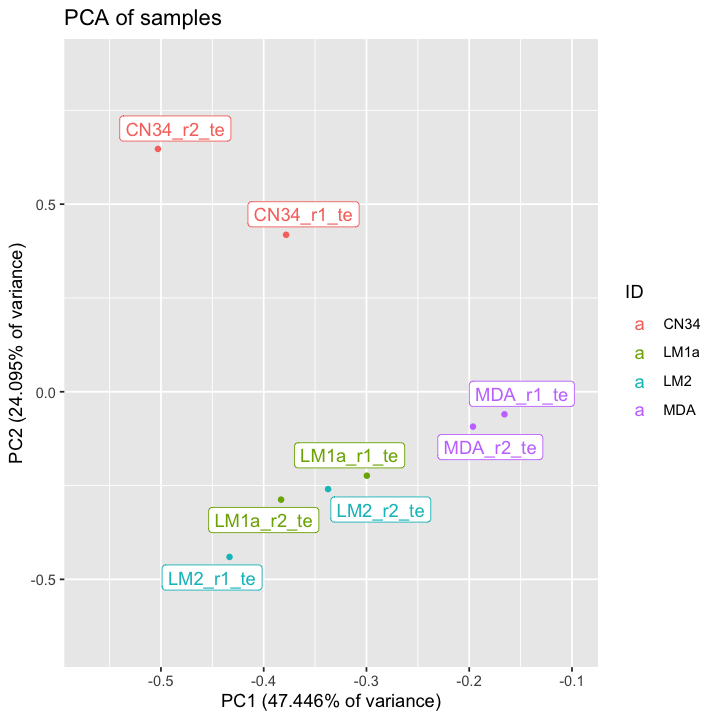

In [32]:
options(repr.plot.width = 6, repr.plot.height = 6)
Ribolog::pca_qc(te.fin[, -1], n = 2, ID = sample_attributes$cell_line[c(1:8)])

### PCA of filtered counts

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.2365 0.08315 0.06455 0.05106 0.04157 0.03783 0.03574
Proportion of Variance 0.7471 0.09232 0.05563 0.03482 0.02307 0.01911 0.01705
Cumulative Proportion  0.7471 0.83943 0.89506 0.92988 0.95295 0.97206 0.98912
                           PC8
Standard deviation     0.02855
Proportion of Variance 0.01088
Cumulative Proportion  1.00000


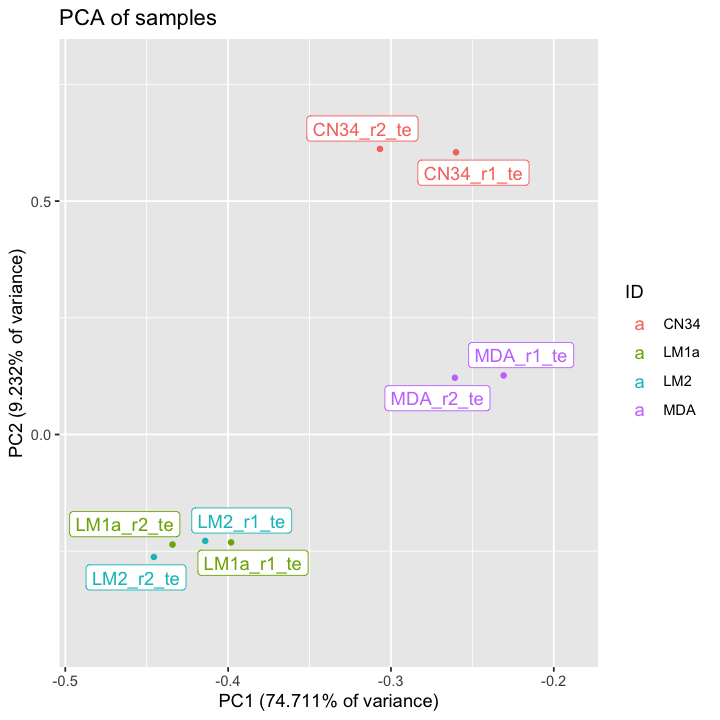

In [33]:
Ribolog::pca_qc(te.v2[, -1], n = 2, ID = sample_attributes$cell_line[c(1:8)])

- Low count transcripts filtered out, data row-centered.

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.09413 0.06491 0.05786 0.04157 0.03798 0.03575 0.02894
Proportion of Variance 0.40816 0.19412 0.15421 0.07960 0.06645 0.05888 0.03857
Cumulative Proportion  0.40816 0.60229 0.75650 0.83610 0.90255 0.96143 1.00000
                             PC8
Standard deviation     2.203e-17
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00


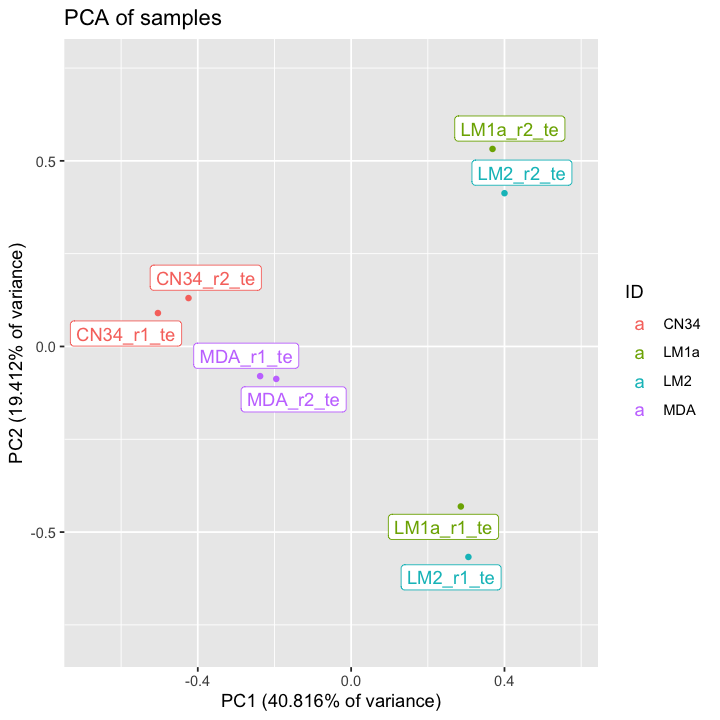

In [34]:
Ribolog::pca_qc(te.v2.cent[, -1], n = 2, ID = sample_attributes$cell_line[c(1:8)])

- Low count transcripts filtered out, data row-standardized

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6    PC7
Standard deviation     1.4698 1.1702 1.0638 0.8474 0.76597 0.75770 0.6754
Proportion of Variance 0.3088 0.1957 0.1618 0.1026 0.08385 0.08205 0.0652
Cumulative Proportion  0.3088 0.5045 0.6663 0.7689 0.85275 0.93480 1.0000
                             PC8
Standard deviation     8.131e-16
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00


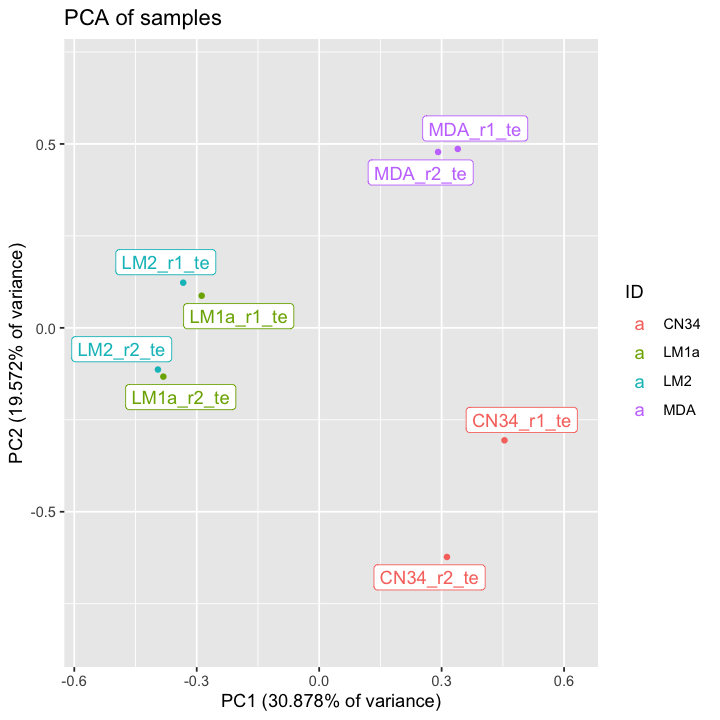

In [35]:
Ribolog::pca_qc(te.v2.stnd[, -1], n = 2, ID = sample_attributes$cell_line[c(1:8)])

### Repeating PCA on RNA and RPF counts

To further investigate why TE of the LM1a and LM2 reps seem somewhat mismacthed, we repeat the PCA on RNA and RPF data:

In [36]:
# Standardize RNA counts 
rr.v3 <- row_standardize(rr.v2, columns = c(2:9)) 
# Standardize RPF counts 
rr.v4 <- row_standardize(rr.v3, columns = c(10:17))

Importance of components:
                          PC1    PC2     PC3    PC4     PC5     PC6     PC7
Standard deviation     1.8630 1.5276 0.60602 0.5147 0.48930 0.41338 0.37824
Proportion of Variance 0.4965 0.3339 0.05254 0.0379 0.03425 0.02445 0.02047
Cumulative Proportion  0.4965 0.8304 0.88293 0.9208 0.95509 0.97953 1.00000
                             PC8
Standard deviation     1.539e-15
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00


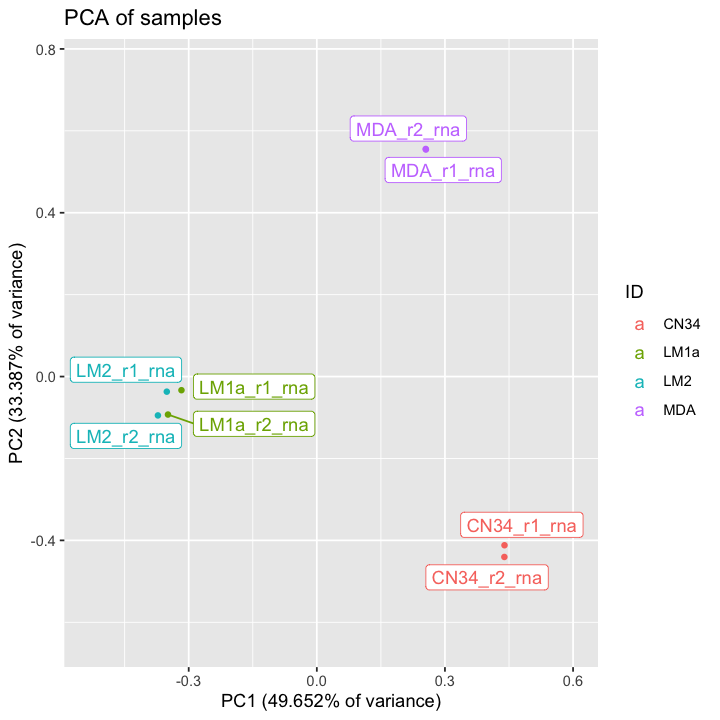

In [37]:
# PCA on RNA counts 
Ribolog::pca_qc(rr.v4[, c(2:9)], n = 2, ID = sample_attributes$cell_line[c(1:8)])

Importance of components:
                          PC1    PC2    PC3    PC4     PC5    PC6     PC7
Standard deviation     1.5910 1.1055 0.9596 0.8644 0.78790 0.7700 0.60367
Proportion of Variance 0.3617 0.1746 0.1316 0.1067 0.08869 0.0847 0.05206
Cumulative Proportion  0.3617 0.5363 0.6678 0.7745 0.86324 0.9479 1.00000
                             PC8
Standard deviation     8.224e-16
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00


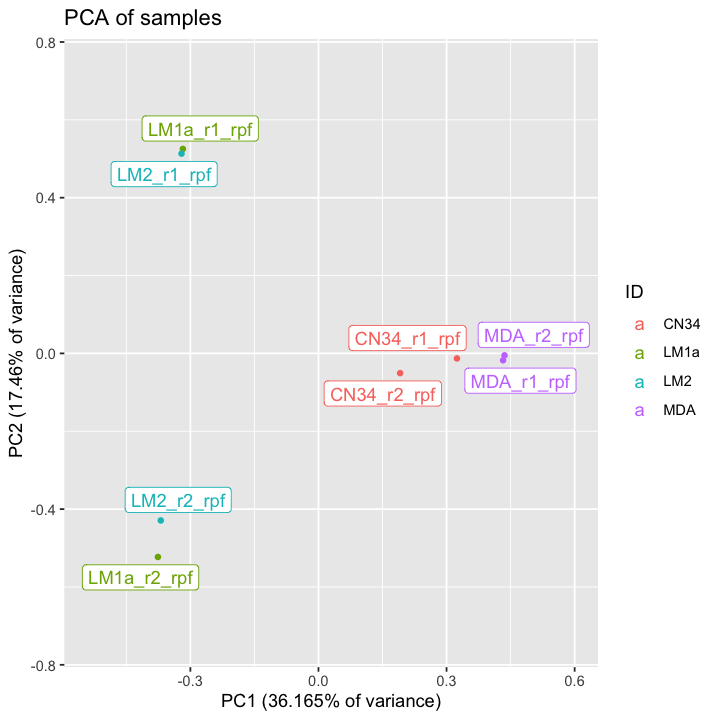

In [38]:
# PCA on RPF counts
Ribolog::pca_qc(rr.v4[, c(10:17)], n = 2, ID = sample_attributes$cell_line[c(9:16)])

PC1 separates the metastatic from non-metastatic lines in both RNA and RPF plots. Replicate consistency seems better for RNA compared to RPF which could be due to the larger RNA read counts in general. The mismatch between reps of the two metastatic cell lines appears to originate from their RPF counts.
The above analyses inform our next step (translational efficiency significance testing): There is a clear difference between metatstatic and non-metastatic lines, but the distinction within these groups is not as large or reliable. Therefore, the most biologically relevant analysis would be to compare TE between metastatic and non-metastatic groups.

### Convert the RNA-RPF data frame to a sample-by-sample list

- The data frame containing RNA and RPF read counts is split to a list based on the values of the parameter uniqueID. uniqueID is one of the variables in the design matrix which specifies the name of the experimental replicate from which one RNA library and one RPF libray was made. In the case of our LMCN data set, this role is served by the variable replicate_name:

In [39]:
rr.v2.split <- Ribolog::partition_to_uniques(x = rr.v2[, -1], 
                                             design = sample_attributes, 
                                             uniqueID = "replicate_name") 
names(rr.v2.split)

[1] "CN34_r1" "CN34_r2" "LM1a_r1" "LM1a_r2" "LM2_r1"  "LM2_r2"  "MDA_r1" 
[8] "MDA_r2"

In [40]:
print(rr.v2.split$CN34_r1[, c(1:10)])

            sample_name read_type lung_metastasis cell_line replicate_no
CN34_r1_rna CN34_r1_rna       RNA               N      CN34            1
CN34_r1_rpf CN34_r1_rpf       RPF               N      CN34            1
            replicate_name cell_line_origin        1          2          3
CN34_r1_rna        CN34_r1             CN34 541.1959 2550.15982 1021.17693
CN34_r1_rpf        CN34_r1             CN34 105.6832   79.83892   32.11355


In [41]:
names(rr.v2[, -1])

[1] "CN34_r1_rna" "CN34_r2_rna" "LM1a_r1_rna" "LM1a_r2_rna" "LM2_r1_rna" 
 [6] "LM2_r2_rna"  "MDA_r1_rna"  "MDA_r2_rna"  "CN34_r1_rpf" "CN34_r2_rpf"
[11] "LM1a_r1_rpf" "LM1a_r2_rpf" "LM2_r1_rpf"  "LM2_r2_rpf"  "MDA_r1_rpf" 
[16] "MDA_r2_rpf"

### Perform translational efficiency ratio (TER) tests on all pairs of samples

With n=8 samples (elements of the split list), C(n,2)=28 pairwise TER tests are performed. At this stage, we need an additional important argument groupID which -like uniqueID- is another variable or column from the design matrix. All samples having the same groupID are considered replicates of the same biological material. In the LMCN dataset, the most sensible choice for groupID is “cell_line” which takes four values “CN34”, “LM1a”, “LM2” or “MDA”.

- This step takes approximately 4 minutes per sample (each sample comprising of an r1 and r2 version)

In [42]:
rr.v2.pairwise <- Ribolog::TER_all_pairs(x = rr.v2.split, 
                                        design = sample_attributes, 
                                        outcome = "read_type", 
                                        uniqueID = "replicate_name", 
                                        groupID = "cell_line",
                                        adj_method = 'none')

In [43]:
str(rr.v2.pairwise$CN34_r1_vs_CN34_r2)

List of 4
 $ uniqueIDs: chr [1:2] "CN34_r1" "CN34_r2"
 $ groupIDs : chr [1:2] "CN34" "CN34"
 $ pair_type: chr "homo"
 $ fit      : num [1:11182, 1:8] -1.63 -3.46 -3.46 -2.54 -2.69 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "Estimate_(Intercept)" "Std. Error_(Intercept)" "z value_(Intercept)" "Pr(>|z|)_(Intercept)" ...


### Estimate and plot the proportion of null features

We estimate the proportion of null features designated 𝜋0 from each one of the C(n,2) test p-value vectors using the Storey method implemented in the qvalue package. Then, we plot of a histogram of 𝜋0s color-coded for homo and hetero pairs.

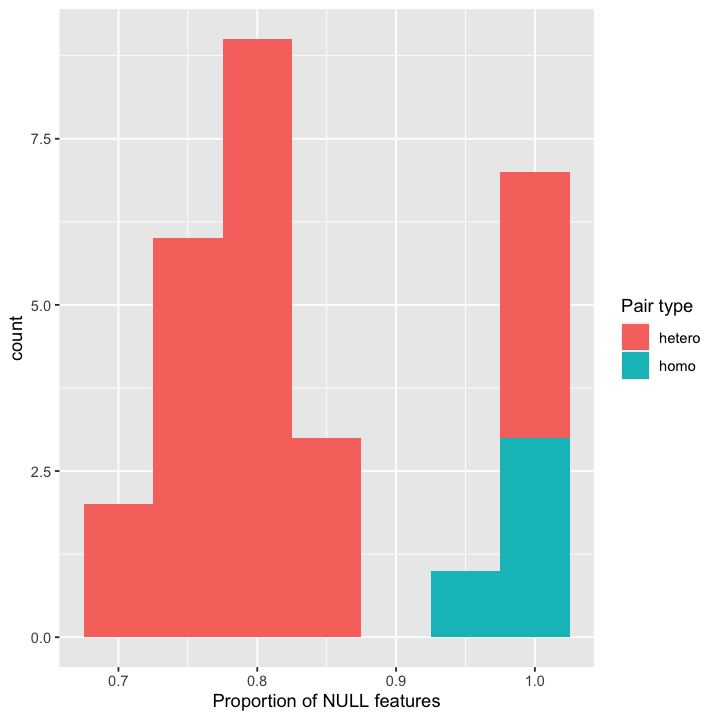

In [44]:
pi0df <- Ribolog::pairs2pi0s(rr.v2.pairwise)

In [ ]:
head(pi0df)

|                   |uniqueID1 |uniqueID2 |groupID1 |groupID2 |pair_type |       pi0|
|:------------------|:---------|:---------|:--------|:--------|:---------|---------:|
|CN34_r1_vs_CN34_r2 |CN34_r1   |CN34_r2   |CN34     |CN34     |homo      | 0.9491970|
|CN34_r1_vs_LM1a_r1 |CN34_r1   |LM1a_r1   |CN34     |LM1a     |hetero    | 0.7789448|
|CN34_r2_vs_LM1a_r1 |CN34_r2   |LM1a_r1   |CN34     |LM1a     |hetero    | 0.7752213|
|CN34_r1_vs_LM1a_r2 |CN34_r1   |LM1a_r2   |CN34     |LM1a     |hetero    | 0.7630891|
|CN34_r2_vs_LM1a_r2 |CN34_r2   |LM1a_r2   |CN34     |LM1a     |hetero    | 0.7915691|
|LM1a_r1_vs_LM1a_r2 |LM1a_r1   |LM1a_r2   |LM1a     |LM1a     |homo      | 1.0000000|

### Correlogram of equivalent test statistics

The Ribolog TER test can be performed on single replicates per biological sample. In a replicated experiment such as (sample A: reps A1 and A2 + sample B: reps B1 and B2), correlation coefficients of regression z scores from equivalent tests i.e. A1 vs B1, A2 vs B1, A1 vs B2 and A2 vs B2 can be used to evaluate replicate homogeneity and help determine the minimum advisable number of replicates to achieve reproducibility of conclusions.

                   CN34_r1_vs_LM1a_r1 CN34_r2_vs_LM1a_r1 CN34_r1_vs_LM1a_r2
CN34_r1_vs_LM1a_r1          1.0000000          0.8444205          0.8203756
CN34_r2_vs_LM1a_r1          0.8444205          1.0000000          0.6491756
CN34_r1_vs_LM1a_r2          0.8203756          0.6491756          1.0000000
CN34_r2_vs_LM1a_r2          0.6858135          0.8160001          0.8507231
                   CN34_r2_vs_LM1a_r2
CN34_r1_vs_LM1a_r1          0.6858135
CN34_r2_vs_LM1a_r1          0.8160001
CN34_r1_vs_LM1a_r2          0.8507231
CN34_r2_vs_LM1a_r2          1.0000000


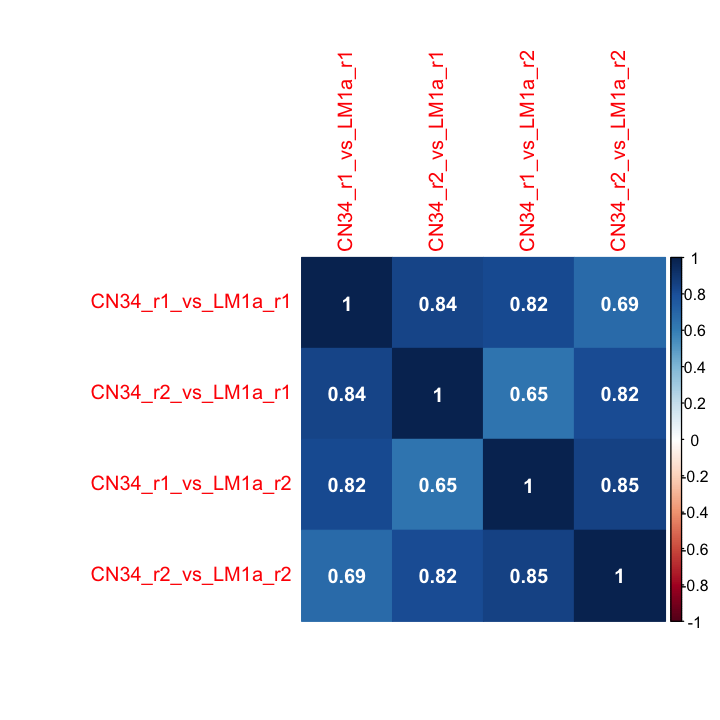

                  CN34_r1_vs_LM2_r1 CN34_r2_vs_LM2_r1 CN34_r1_vs_LM2_r2
CN34_r1_vs_LM2_r1         1.0000000         0.8547844         0.8386556
CN34_r2_vs_LM2_r1         0.8547844         1.0000000         0.6788911
CN34_r1_vs_LM2_r2         0.8386556         0.6788911         1.0000000
CN34_r2_vs_LM2_r2         0.7097990         0.8366509         0.8559446
                  CN34_r2_vs_LM2_r2
CN34_r1_vs_LM2_r1         0.7097990
CN34_r2_vs_LM2_r1         0.8366509
CN34_r1_vs_LM2_r2         0.8559446
CN34_r2_vs_LM2_r2         1.0000000


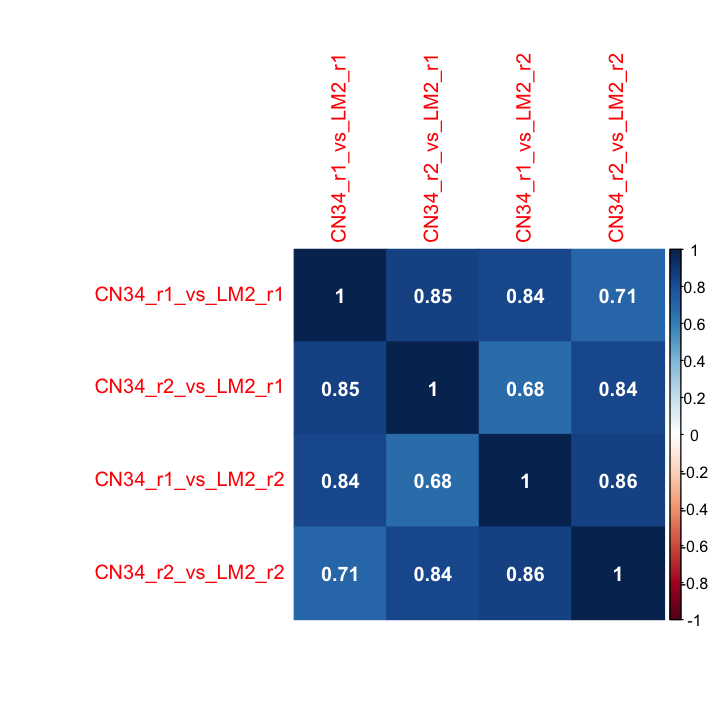

                  LM1a_r1_vs_LM2_r1 LM1a_r2_vs_LM2_r1 LM1a_r1_vs_LM2_r2
LM1a_r1_vs_LM2_r1        1.00000000         0.3676250         0.4055026
LM1a_r2_vs_LM2_r1        0.36762498         1.0000000        -0.3921192
LM1a_r1_vs_LM2_r2        0.40550263        -0.3921192         1.0000000
LM1a_r2_vs_LM2_r2        0.01821062         0.4155393         0.3650967
                  LM1a_r2_vs_LM2_r2
LM1a_r1_vs_LM2_r1        0.01821062
LM1a_r2_vs_LM2_r1        0.41553927
LM1a_r1_vs_LM2_r2        0.36509668
LM1a_r2_vs_LM2_r2        1.00000000


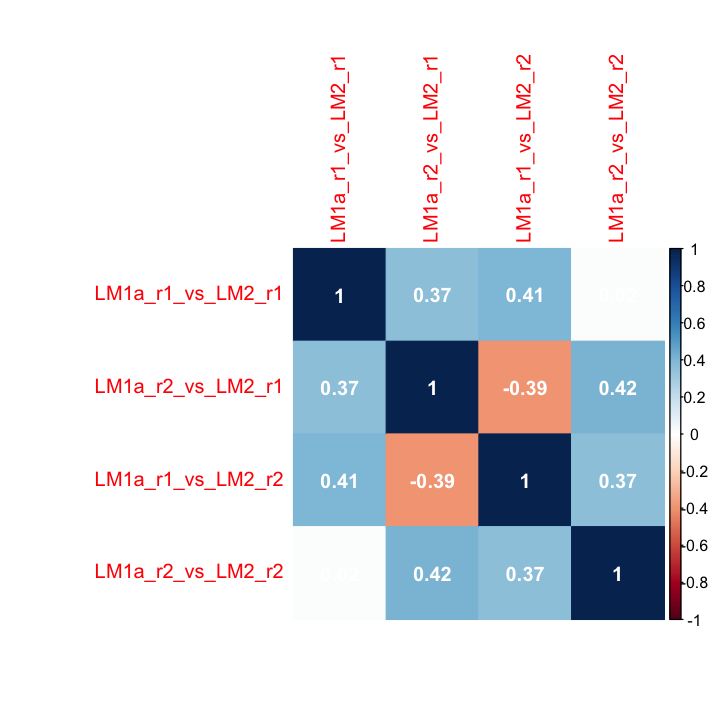

                  CN34_r1_vs_MDA_r1 CN34_r2_vs_MDA_r1 CN34_r1_vs_MDA_r2
CN34_r1_vs_MDA_r1         1.0000000         0.8445260         0.8261733
CN34_r2_vs_MDA_r1         0.8445260         1.0000000         0.6415587
CN34_r1_vs_MDA_r2         0.8261733         0.6415587         1.0000000
CN34_r2_vs_MDA_r2         0.7602956         0.8805082         0.8413090
                  CN34_r2_vs_MDA_r2
CN34_r1_vs_MDA_r1         0.7602956
CN34_r2_vs_MDA_r1         0.8805082
CN34_r1_vs_MDA_r2         0.8413090
CN34_r2_vs_MDA_r2         1.0000000


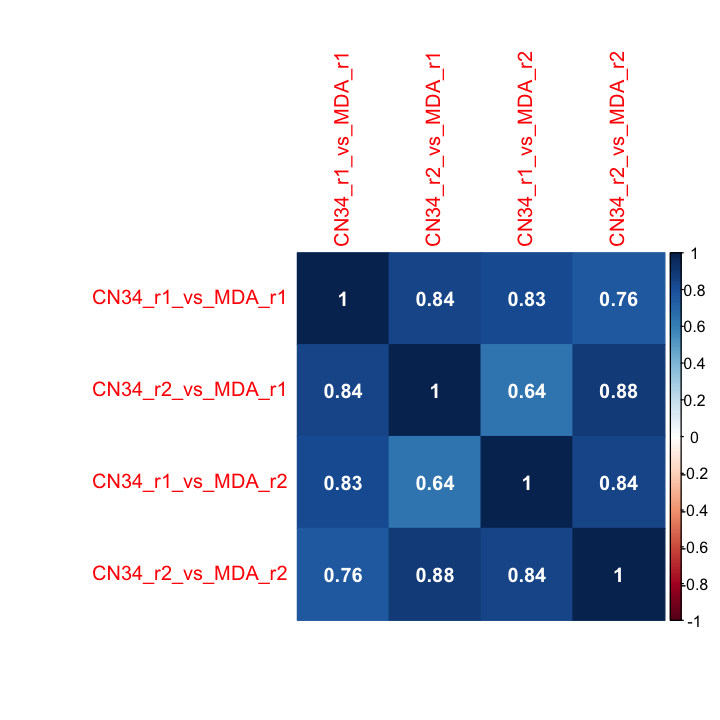

                  LM1a_r1_vs_MDA_r1 LM1a_r2_vs_MDA_r1 LM1a_r1_vs_MDA_r2
LM1a_r1_vs_MDA_r1         1.0000000         0.7716184         0.8269158
LM1a_r2_vs_MDA_r1         0.7716184         1.0000000         0.5981389
LM1a_r1_vs_MDA_r2         0.8269158         0.5981389         1.0000000
LM1a_r2_vs_MDA_r2         0.6076592         0.8455622         0.7556138
                  LM1a_r2_vs_MDA_r2
LM1a_r1_vs_MDA_r1         0.6076592
LM1a_r2_vs_MDA_r1         0.8455622
LM1a_r1_vs_MDA_r2         0.7556138
LM1a_r2_vs_MDA_r2         1.0000000
                 LM2_r1_vs_MDA_r1 LM2_r2_vs_MDA_r1 LM2_r1_vs_MDA_r2
LM2_r1_vs_MDA_r1        1.0000000        0.7920280        0.8326901
LM2_r2_vs_MDA_r1        0.7920280        1.0000000        0.6224160
LM2_r1_vs_MDA_r2        0.8326901        0.6224160        1.0000000
LM2_r2_vs_MDA_r2        0.6308746        0.8482037        0.7749659
                 LM2_r2_vs_MDA_r2
LM2_r1_vs_MDA_r1        0.6308746
LM2_r2_vs_MDA_r1        0.8482037
LM2_r1_vs_MDA_r2  

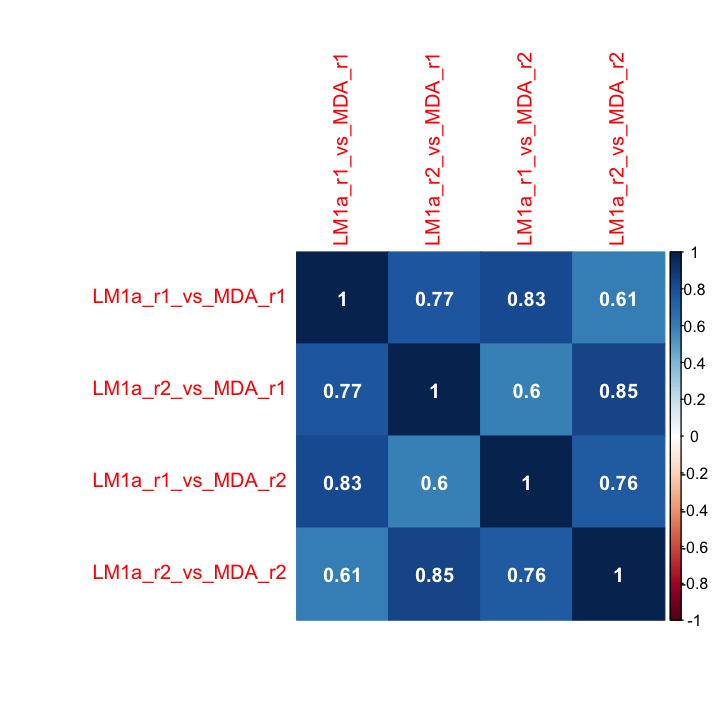

                 LM2_r1_vs_MDA_r1 LM2_r2_vs_MDA_r1 LM2_r1_vs_MDA_r2
LM2_r1_vs_MDA_r1        1.0000000        0.7920280        0.8326901
LM2_r2_vs_MDA_r1        0.7920280        1.0000000        0.6224160
LM2_r1_vs_MDA_r2        0.8326901        0.6224160        1.0000000
LM2_r2_vs_MDA_r2        0.6308746        0.8482037        0.7749659
                 LM2_r2_vs_MDA_r2
LM2_r1_vs_MDA_r1        0.6308746
LM2_r2_vs_MDA_r1        0.8482037
LM2_r1_vs_MDA_r2        0.7749659
LM2_r2_vs_MDA_r2        1.0000000


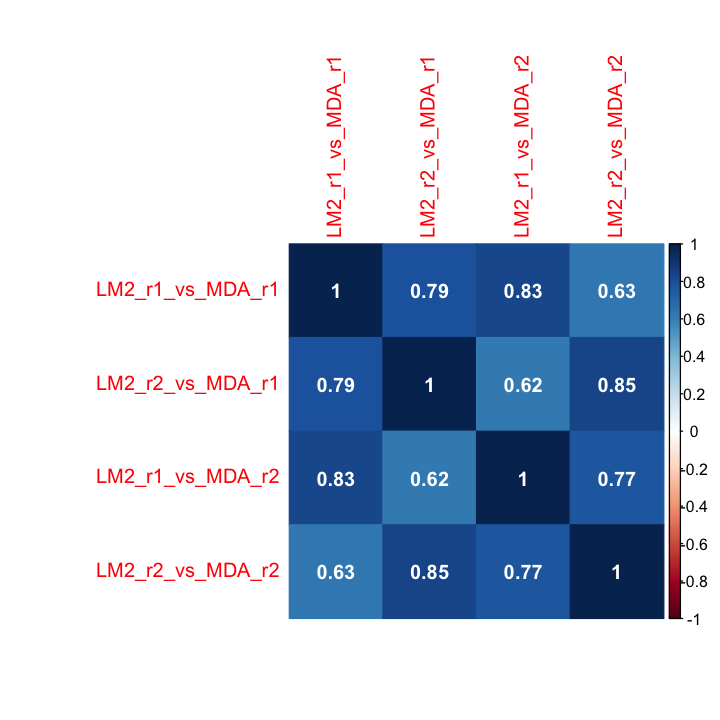

In [46]:
rr.v2.correlograms <- pairs2correlograms(rr.v2.pairwise)

In [ ]:
head(rr.v2.correlograms)

|                   | CN34_r1_vs_LM1a_r1| CN34_r2_vs_LM1a_r1| CN34_r1_vs_LM1a_r2| CN34_r2_vs_LM1a_r2|
|:------------------|------------------:|------------------:|------------------:|------------------:|
|CN34_r1_vs_LM1a_r1 |          1.0000000|          0.8444205|          0.8203756|          0.6858135|
|CN34_r2_vs_LM1a_r1 |          0.8444205|          1.0000000|          0.6491756|          0.8160001|
|CN34_r1_vs_LM1a_r2 |          0.8203756|          0.6491756|          1.0000000|          0.8507231|
|CN34_r2_vs_LM1a_r2 |          0.6858135|          0.8160001|          0.8507231|          1.0000000|

|                  | CN34_r1_vs_LM2_r1| CN34_r2_vs_LM2_r1| CN34_r1_vs_LM2_r2| CN34_r2_vs_LM2_r2|
|:-----------------|-----------------:|-----------------:|-----------------:|-----------------:|
|CN34_r1_vs_LM2_r1 |         1.0000000|         0.8547844|         0.8386556|         0.7097990|
|CN34_r2_vs_LM2_r1 |         0.8547844|         1.0000000|         0.6788911|         0.8366509|
|CN34_r1_vs_LM2_r2 |         0.8386556|         0.6788911|         1.0000000|         0.8559446|
|CN34_r2_vs_LM2_r2 |         0.7097990|         0.8366509|         0.8559446|         1.0000000|

|                  | LM1a_r1_vs_LM2_r1| LM1a_r2_vs_LM2_r1| LM1a_r1_vs_LM2_r2| LM1a_r2_vs_LM2_r2|
|:-----------------|-----------------:|-----------------:|-----------------:|-----------------:|
|LM1a_r1_vs_LM2_r1 |         1.0000000|         0.3676250|         0.4055026|         0.0182106|
|LM1a_r2_vs_LM2_r1 |         0.3676250|         1.0000000|        -0.3921192|         0.4155393|
|LM1a_r1_vs_LM2_r2 |         0.4055026|        -0.3921192|         1.0000000|         0.3650967|
|LM1a_r2_vs_LM2_r2 |         0.0182106|         0.4155393|         0.3650967|         1.0000000|

|                  | CN34_r1_vs_MDA_r1| CN34_r2_vs_MDA_r1| CN34_r1_vs_MDA_r2| CN34_r2_vs_MDA_r2|
|:-----------------|-----------------:|-----------------:|-----------------:|-----------------:|
|CN34_r1_vs_MDA_r1 |         1.0000000|         0.8445260|         0.8261733|         0.7602956|
|CN34_r2_vs_MDA_r1 |         0.8445260|         1.0000000|         0.6415587|         0.8805082|
|CN34_r1_vs_MDA_r2 |         0.8261733|         0.6415587|         1.0000000|         0.8413090|
|CN34_r2_vs_MDA_r2 |         0.7602956|         0.8805082|         0.8413090|         1.0000000|

|                  | LM1a_r1_vs_MDA_r1| LM1a_r2_vs_MDA_r1| LM1a_r1_vs_MDA_r2| LM1a_r2_vs_MDA_r2|
|:-----------------|-----------------:|-----------------:|-----------------:|-----------------:|
|LM1a_r1_vs_MDA_r1 |         1.0000000|         0.7716184|         0.8269158|         0.6076592|
|LM1a_r2_vs_MDA_r1 |         0.7716184|         1.0000000|         0.5981389|         0.8455622|
|LM1a_r1_vs_MDA_r2 |         0.8269158|         0.5981389|         1.0000000|         0.7556138|
|LM1a_r2_vs_MDA_r2 |         0.6076592|         0.8455622|         0.7556138|         1.0000000|

|                 | LM2_r1_vs_MDA_r1| LM2_r2_vs_MDA_r1| LM2_r1_vs_MDA_r2| LM2_r2_vs_MDA_r2|
|:----------------|----------------:|----------------:|----------------:|----------------:|
|LM2_r1_vs_MDA_r1 |        1.0000000|        0.7920280|        0.8326901|        0.6308746|
|LM2_r2_vs_MDA_r1 |        0.7920280|        1.0000000|        0.6224160|        0.8482037|
|LM2_r1_vs_MDA_r2 |        0.8326901|        0.6224160|        1.0000000|        0.7749659|
|LM2_r2_vs_MDA_r2 |        0.6308746|        0.8482037|        0.7749659|        1.0000000|

## Module 4: Basic differential translational efficiency test

Now we are ready to perform the translational efficiency test using the logit_seq function. TE is the RPF/RNA ratio. If we are interested in comparing TE between the metastatic and non-metastatic samples, we set the model to read_type ~ lung_metastasis. The count data set (argument x) must contain only numeric variables, therefore column 1 (transcript) is excluded from x and provided separately as the feature list in the end.

- Translational efficiency of transcript ENST00000000233 is estimated to be 12.87% higher in metastatic samples compared to non-metastatic ones. However, this difference is not statistically significant (p=0.1014).

- Regression reports usually include only a regression coefficient (Estimate) and a p-value. We keep SE and z in the output data frame to enable certain tasks e.g. generation of correlograms from z scores (module 3, TEST 3).

Finally, p-values are corrected for multiple testing. Run ?logit_seq to see all the available methods. Two examples are shown below. Each column of p-values is corrected for multiple testing separately.

In [47]:
fit1_FDR   <- Ribolog::logit_seq(rr.v2[, -1], 
                                sample_attributes, 
                                read_type ~ lung_metastasis, 
                                as.vector(rr.v2$transcript),
                                adj_method='fdr')

In [ ]:
head(fit1_FDR)

|                | Estimate_.Intercept.| Std..Error_.Intercept.| z.value_.Intercept.| Pr...z.._.Intercept.| Estimate_lung_metastasisY| Std..Error_lung_metastasisY| z.value_lung_metastasisY| Pr...z.._lung_metastasisY| fdr_Pr(>&#124;z&#124;)_(Intercept)| fdr_Pr(>&#124;z&#124;)_lung_metastasisY|
|:---------------|--------------------:|----------------------:|-------------------:|--------------------:|-------------------------:|---------------------------:|------------------------:|-------------------------:|----------------------------------:|---------------------------------------:|
|ENST00000000233 |            -1.682956|              0.0512857|           -32.81531|                    0|                 0.1209811|                   0.0738927|                 1.637254|                 0.1015773|                                  0|                               0.1914441|
|ENST00000000412 |            -3.453933|              0.0580415|           -59.50800|                    0|                -0.3378959|                   0.0860292|                -3.927690|                 0.0000858|                                  0|                               0.0005198|
|ENST00000000442 |            -3.688487|              0.0959439|           -38.44420|                    0|                 0.3469977|                   0.1321031|                 2.626718|                 0.0086213|                                  0|                               0.0266749|
|ENST00000001008 |            -2.435158|              0.0371078|           -65.62384|                    0|                 0.1645951|                   0.0501275|                 3.283527|                 0.0010252|                                  0|                               0.0044587|
|ENST00000001146 |            -2.896790|              0.2430905|           -11.91651|                    0|                 1.0298253|                   0.2943959|                 3.498096|                 0.0004686|                                  0|                               0.0022871|
|ENST00000002125 |            -2.381553|              0.1203793|           -19.78374|                    0|                -0.4300740|                   0.1959353|                -2.194980|                 0.0281651|                                  0|                               0.0701429|

You can also simply extract uncorrected values by specifying 'none' as the adjustment method

In [119]:
fit1  <- Ribolog::logit_seq(rr.v2[, -1], 
                                sample_attributes, 
                                read_type ~ lung_metastasis, 
                                as.vector(rr.v2$transcript),
                                adj_method='none')

In [ ]:
head(fit1)

|                | Estimate_(Intercept)| Std. Error_(Intercept)| z value_(Intercept)| Pr(>&#124;z&#124;)_(Intercept)| Estimate_lung_metastasisY| Std. Error_lung_metastasisY| z value_lung_metastasisY| Pr(>&#124;z&#124;)_lung_metastasisY|
|:---------------|--------------------:|----------------------:|-------------------:|------------------------------:|-------------------------:|---------------------------:|------------------------:|-----------------------------------:|
|ENST00000000233 |            -1.682956|              0.0512857|           -32.81531|                              0|                 0.1209811|                   0.0738927|                 1.637254|                           0.1015773|
|ENST00000000412 |            -3.453933|              0.0580415|           -59.50800|                              0|                -0.3378959|                   0.0860292|                -3.927690|                           0.0000858|
|ENST00000000442 |            -3.688487|              0.0959439|           -38.44420|                              0|                 0.3469977|                   0.1321031|                 2.626718|                           0.0086213|
|ENST00000001008 |            -2.435158|              0.0371078|           -65.62384|                              0|                 0.1645951|                   0.0501275|                 3.283527|                           0.0010252|
|ENST00000001146 |            -2.896790|              0.2430905|           -11.91651|                              0|                 1.0298253|                   0.2943959|                 3.498096|                           0.0004686|
|ENST00000002125 |            -2.381553|              0.1203793|           -19.78374|                              0|                -0.4300740|                   0.1959353|                -2.194980|                           0.0281651|

In [87]:
fit1_qval <- Ribolog::logit_seq(rr.v2[, -1], 
                                sample_attributes, 
                                read_type ~ lung_metastasis, 
                                as.vector(rr.v2$transcript),
                                adj_method='qvalue')

In [ ]:
head(fit1_qval)

|                | Estimate_.Intercept.| Std..Error_.Intercept.| z.value_.Intercept.| Pr...z.._.Intercept.| Estimate_lung_metastasisY| Std..Error_lung_metastasisY| z.value_lung_metastasisY| Pr...z.._lung_metastasisY| qvalue_Pr(>&#124;z&#124;)_(Intercept)| qvalue_Pr(>&#124;z&#124;)_lung_metastasisY|
|:---------------|--------------------:|----------------------:|-------------------:|--------------------:|-------------------------:|---------------------------:|------------------------:|-------------------------:|-------------------------------------:|------------------------------------------:|
|ENST00000000233 |            -1.682956|              0.0512857|           -32.81531|                    0|                 0.1209811|                   0.0738927|                 1.637254|                 0.1015773|                                     0|                                  0.0752676|
|ENST00000000412 |            -3.453933|              0.0580415|           -59.50800|                    0|                -0.3378959|                   0.0860292|                -3.927690|                 0.0000858|                                     0|                                  0.0002044|
|ENST00000000442 |            -3.688487|              0.0959439|           -38.44420|                    0|                 0.3469977|                   0.1321031|                 2.626718|                 0.0086213|                                     0|                                  0.0104874|
|ENST00000001008 |            -2.435158|              0.0371078|           -65.62384|                    0|                 0.1645951|                   0.0501275|                 3.283527|                 0.0010252|                                     0|                                  0.0017530|
|ENST00000001146 |            -2.896790|              0.2430905|           -11.91651|                    0|                 1.0298253|                   0.2943959|                 3.498096|                 0.0004686|                                     0|                                  0.0008992|
|ENST00000002125 |            -2.381553|              0.1203793|           -19.78374|                    0|                -0.4300740|                   0.1959353|                -2.194980|                 0.0281651|                                     0|                                  0.0275772|

An important advantage of Ribolog is that it can run the TER test using only a single replicate per sample, or a single sample per biological condition. Below, we compare CN34 and LM1a lines using only one replicate from each:

In [90]:
fit2_qval <- Ribolog::logit_seq(rr.v2[, c(2, 4, 10, 12)], 
                           sample_attributes[c(1, 3, 9, 11), ], 
                           read_type ~ cell_line, 
                           as.vector(rr.v2$transcript),
                           adj_method = "qvalue")

names(fit2_qval)

[1] "Estimate_.Intercept."          "Std..Error_.Intercept."       
 [3] "z.value_.Intercept."           "Pr...z.._.Intercept."         
 [5] "Estimate_cell_lineLM1a"        "Std..Error_cell_lineLM1a"     
 [7] "z.value_cell_lineLM1a"         "Pr...z.._cell_lineLM1a"       
 [9] "qvalue_Pr(>|z|)_(Intercept)"   "qvalue_Pr(>|z|)_cell_lineLM1a"

### Make Volcano Plots

We can visualize the results in volcano plots

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


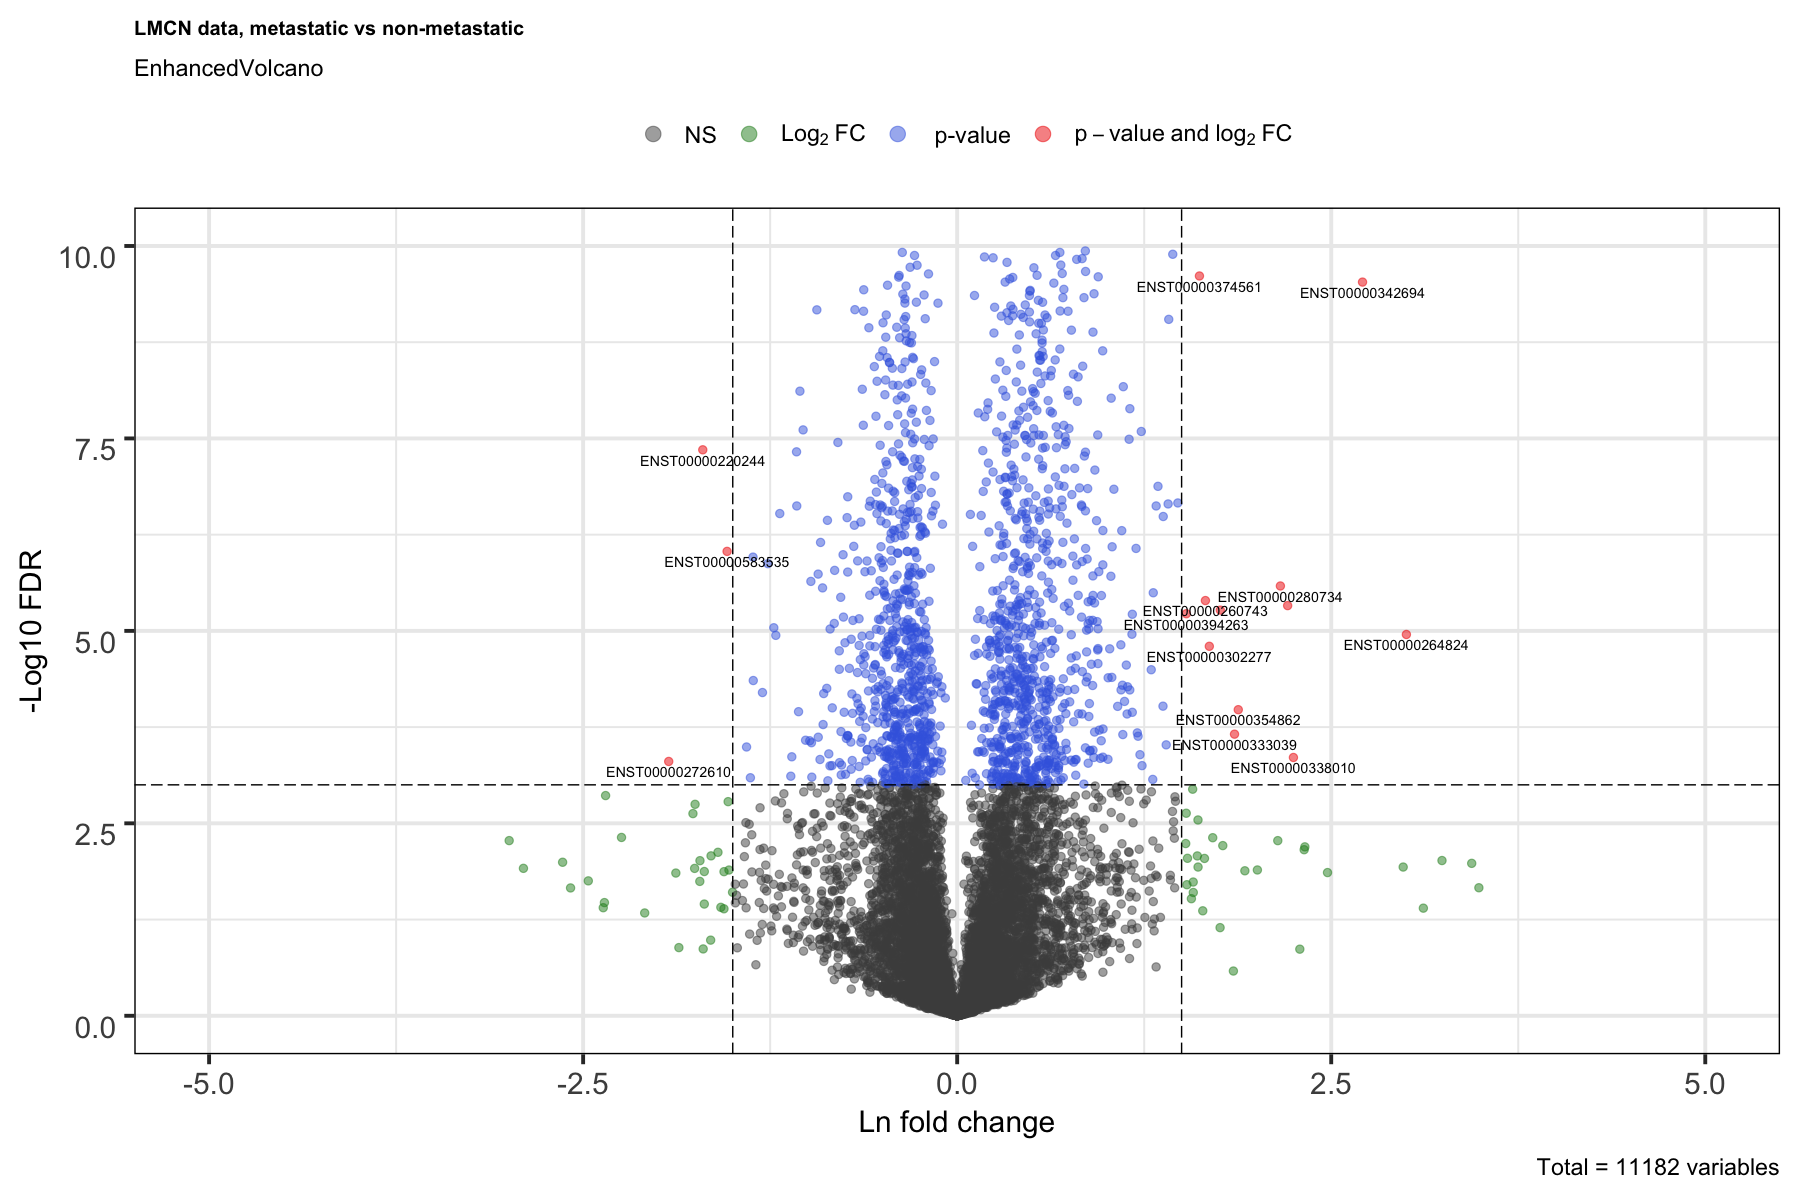

In [48]:
options(repr.plot.width = 15, repr.plot.height = 10)
Ribolog::volcano_plot(fit1_FDR)

## Module 5: The empirical null distribution.

The first step involves performing hypothesis testing between replicates of the same sample for all samples
to generate the components of empirical null distribution. It starts with partitioning the dataset to a list.
The key argument is uniqueID which should be a variable in the design matrix. uniqueID is used to pair
together RNA and RPF data from each replicate.

In [49]:
rr.v2.split <- Ribolog::partition_to_uniques(x = rr.v2[,-1], 
                            design = sample_attributes, uniqueID = "replicate_name")

In [50]:
names(rr.v2.split)

[1] "CN34_r1" "CN34_r2" "LM1a_r1" "LM1a_r2" "LM2_r1"  "LM2_r2"  "MDA_r1" 
[8] "MDA_r2"

In [51]:
print(rr.v2.split$CN34_r1[, c(1:10)])

            sample_name read_type lung_metastasis cell_line replicate_no
CN34_r1_rna CN34_r1_rna       RNA               N      CN34            1
CN34_r1_rpf CN34_r1_rpf       RPF               N      CN34            1
            replicate_name cell_line_origin        1          2          3
CN34_r1_rna        CN34_r1             CN34 541.1959 2550.15982 1021.17693
CN34_r1_rpf        CN34_r1             CN34 105.6832   79.83892   32.11355


Second, TER testing is performed using the logit_seq function between all pairs of samples with the same
uniqueID (similar to the TER_all_pairs function used in module 3, but here we only perform the test on
the homo pairs). Samples with the same groupID are considered replicates of the same biological sample.
For more details on how to correctly specify these arguments, check out the function documentation.

In [55]:
rr.v2.enz <- Ribolog::generate_ENZ(x = rr.v2.split, 
                                   design = sample_attributes, 
                                   outcome = "read_type", 
                                   uniqueID = "replicate_name", 
                                   groupID = "cell_line", 
                                   adj_method='none')

### Visualise the Empirical Null Distribution

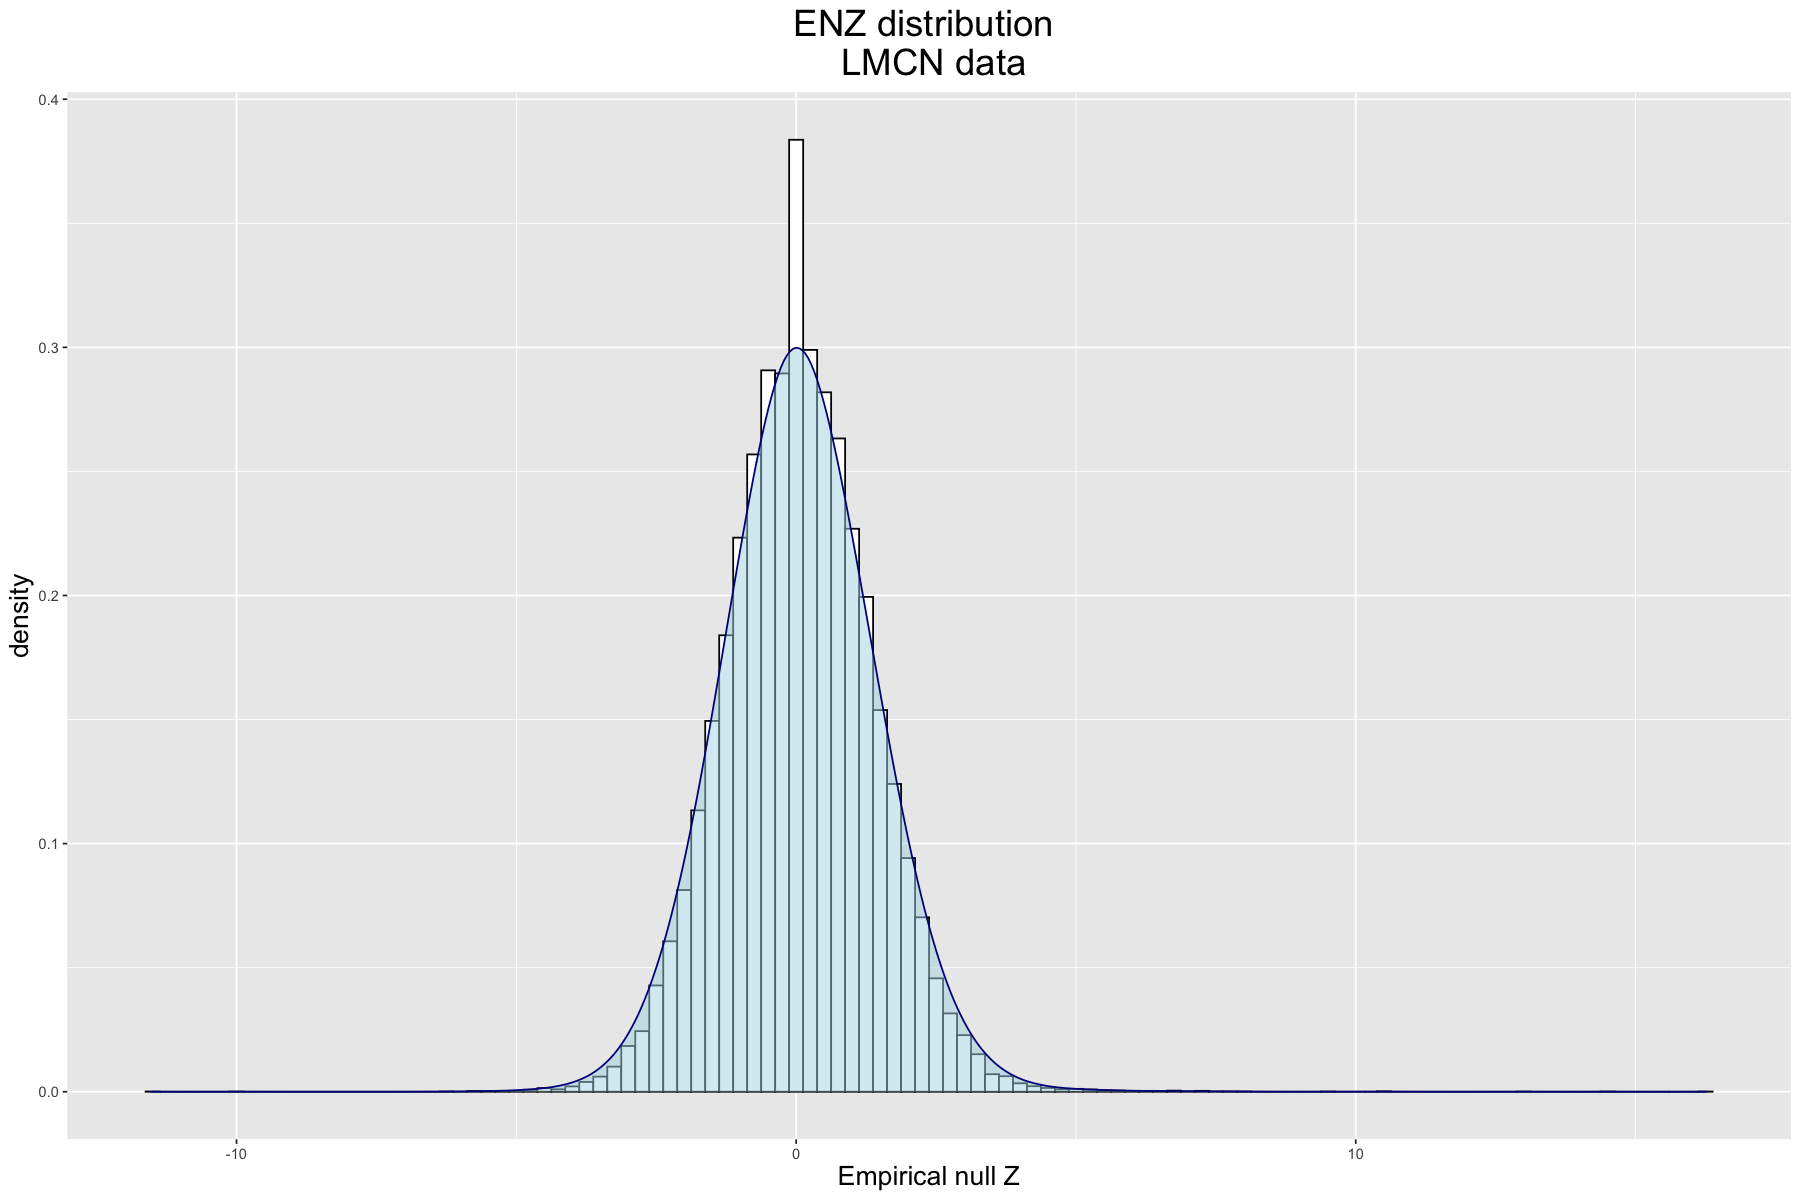

In [114]:
Ribolog::visualise_empirical_null(rr.v2.enz, plot_density=TRUE)

In [117]:
Ribolog::fit_empirical_null(rr.v2.enz, "norm")

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters:
       estimate  Std. Error
mean 0.05181513 0.006139051
sd   1.29834753 0.004340953

Mean is close to zero but variance is much larger than 1, which indicates fatter tails. Testing the significance
of z scores using this distribution will yield larger p-values than using the standard normal (which is the
default in regression functions including logit_seq).

### Perform hypothesis testing using empirical null

Calculating p-values by empirical null hypothesis testing on a previously fitted dataframe from logit_seq.

In [122]:
fit1_ENZ_p <- Ribolog::test_ENZ(x = fit1, enz = rr.v2.enz, zcols = 7)

Plot the empirical p-values against the theoretical p-values

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“2 x values <= 0 omitted from logarithmic plot”
Warning message in xy.coords(x, y, xlabel, ylabel, log):
“134 y values <= 0 omitted from logarithmic plot”


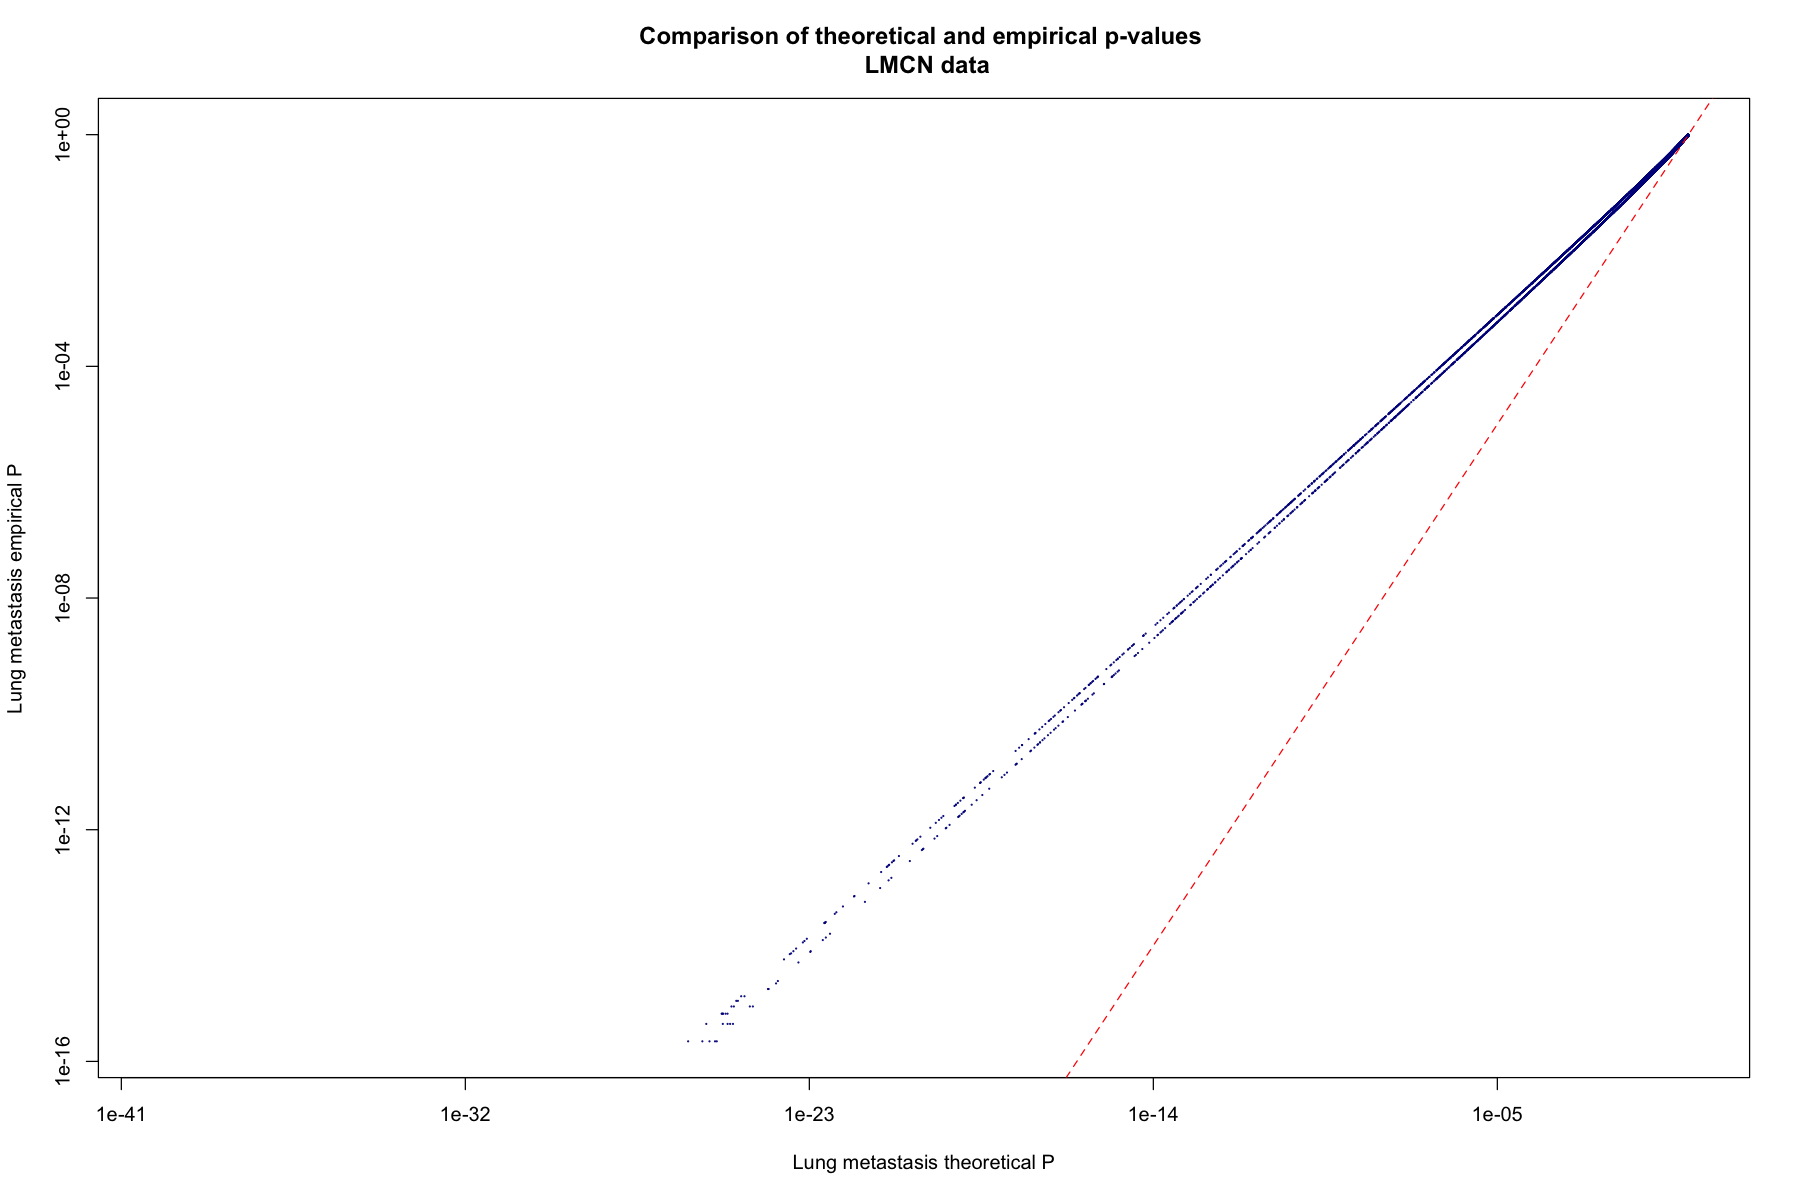

In [140]:
plot(fit1_ENZ_p$Pr...z.._lung_metastasisY, fit1_ENZ_p$ep_lung_metastasisY,
log = "xy", xlim = c(1e-40, 1), pch = 21, cex = 0.1, col = "darkblue",
xlab = "Lung metastasis theoretical P", ylab = "Lung metastasis empirical P",
main = "Comparison of theoretical and empirical p-values \n LMCN data")
abline(0, 1, col = "red", lty = 2)

The red line marks x=y. Empirical null testing is much more conservatives i.e. it generates substantially
larger p-values.

Combine the output of related tests in a meta-analytical framework.

The function meta_test is at the core of this module. Statistically, it is a way of combining results of
correlated (non-independent) tests (based on: Makambi, K. 2003. Weighted inverse chi-square method for
correlated significance tests. Journal of Applied Statistics, 30(2): 225-234). The intuitive idea behind this
method is that if two sets of results are highly correlated, adding the second to the first will not add much
independent information; therefore, it should not improve the significance of the results by much. The more
correlated the two sets of data are, the less indepednet enforcement of conclusions we are able to obtain from
them. For example, replicates of the same biological sample are expected to be well correlated. By adding
more and more replicates, we can improve the precision of our estimates, but will not be getting any more
independent corroboration of the the results.

In [141]:
# Extract the appropriate columns from the RPF dataset and
# the design matrix for the CN34-LM1a and MDA-LM2 pairs of
# cell lines, as if they had been produced independently.

fit1a <- Ribolog::logit_seq(rr.v2[,c(2:5,10:13)], 
                            sample_attributes[c(1:4,9:12), ], 
                            read_type ~ lung_metastasis, 
                            as.vector(rr.v2$transcript),
                            adj_method = "none")

fit1b <- Ribolog::logit_seq(rr.v2[,c(6:9,14:17)], 
                            sample_attributes[c(5:8,13:16), ], 
                            read_type ~ lung_metastasis, 
                            as.vector(rr.v2$transcript),
                            adj_method = "none")


In [142]:
# Discard the intercept columns which are not interesting
# from the fit object. Place the lung_metastasis components
# of the tests to be combined in a list.

fit1ab_list <- list("fit1a" = fit1a[, c(5:8)], "fit1b" = fit1b[, c(5:8)])
fit1ab_meta <- Ribolog::meta_test(fit1ab_list, feature_list = rr.v2$transcript)

          fit1a     fit1b
fit1a 1.0000000 0.4463054
fit1b 0.4463054 1.0000000


In [ ]:
head(fit1ab_meta, n = 2)

|                |  meta_beta|    meta_p|
|:---------------|----------:|---------:|
|ENST00000000233 |  0.1181188| 0.2544673|
|ENST00000000412 | -0.3428665| 0.0008719|

In [146]:
# Pooled data

fit1_long <- Ribolog::logit_seq(rr.v2[, -1], sample_attributes, read_type ~ lung_metastasis, 
                                feature_list = as.vector(rr.v2$transcript), long_output = TRUE, 
                                adj_method='none')

In [ ]:
# Place the log TERs from subsetted, pooled and meta tests in
# a data frame and check their correlation.

betas <- data.frame(fit1_long[, "Estimate_lung_metastasisY"],
fit1a[, "Estimate_lung_metastasisY"], fit1b[, "Estimate_lung_metastasisY"],
fit1ab_meta$meta_beta)

names(betas) <- c("beta_fit1_pooled", "beta_fit1a", "beta_fit1b",
"meta_beta")

head(betas, n = 2)

|                | beta_fit1_pooled| beta_fit1a| beta_fit1b|  meta_beta|
|:---------------|----------------:|----------:|----------:|----------:|
|ENST00000000233 |        0.1209811|  0.1079058|  0.1279216|  0.1181188|
|ENST00000000412 |       -0.3378959| -0.2474701| -0.4315207| -0.3428665|

In [153]:
# Place the p-values from subsetted, pooled and meta tests in
# a data frame and check their correlation.

ps <- data.frame(fit1_long[, 8], fit1a[, 8], fit1b[,8], fit1ab_meta$meta_p)

names(ps) <- c("p_fit1_pooled", "p_fit1a", "p_fit1b", "meta_p")

|                | p_fit1_pooled|   p_fit1a|   p_fit1b|    meta_p|
|:---------------|-------------:|---------:|---------:|---------:|
|ENST00000000233 |     0.1015773| 0.3073329| 0.2167340| 0.2544673|
|ENST00000000412 |     0.0000858| 0.0459041| 0.0003051| 0.0008719|

Spearman's test for correlation in the fitted p-values

In [ ]:
cor(ps, method = "spearman")

|              | p_fit1_pooled|   p_fit1a|   p_fit1b|    meta_p|
|:-------------|-------------:|---------:|---------:|---------:|
|p_fit1_pooled |     1.0000000| 0.6516471| 0.6399515| 0.8480520|
|p_fit1a       |     0.6516471| 1.0000000| 0.2777103| 0.7759148|
|p_fit1b       |     0.6399515| 0.2777103| 1.0000000| 0.7470132|
|meta_p        |     0.8480520| 0.7759148| 0.7470132| 1.0000000|

Please refer to the Module 5 PDF file in the vignettes folder for detailed examples of meta-analysis

## Module 6: Upstream ORF usage and stop codon readthrough

### Get transcript read counts for different regions

In [3]:
library(dplyr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ readr   1.4.0     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
remove_0_1_region_transcripts <- function(data){
  tt <- table(data$transcript, data$psite_region)
  ts <- rownames(tt[rowSums(tt>0) >= 2, , drop = FALSE])
  x2 <- subset(data, transcript %in% ts)
  x2 <- droplevels(x2)
  rate <- 100 * (1 - (length(ts)/dim(tt)[1]))
  print(paste0(rate, "% of transcripts had reads in <2 regions and were removed"))
  return(x2)
}

glm_deviance_test_p <- function(x){
  p <- pchisq((x$null.deviance - x$deviance), df = (x$df.null - x$df.residual), lower.tail = FALSE)
  return(p)
}

In [5]:
reads_psite_list <- readRDS('~/Downloads/reads_psite_list.RDS')

In [6]:
sample_attributes <- read.csv("~/Downloads/Ribolog/data-raw/sample_attributes.csv", header = TRUE, 
                              stringsAsFactors=TRUE, sep='\t')

In [7]:
get_tr_regions <- function(reads_psite_list){
  rpl <- lapply(reads_psite_list, function (x) dplyr::select(x, transcript, psite_region))
  rpl.2 <- lapply( rpl , function(x) x %>% count(transcript, psite_region)  )
  rp.df <- data.table::rbindlist(rpl.2, idcol="sample")
  rp.df$psite_region <- relevel(as.factor(rp.df$psite_region), ref = "cds")
  names(rp.df)[4] <- "count"
  return(rp.df)
}

In [9]:
tr_regions_df <- get_tr_regions(reads_psite_list)

- The folllowing table gives us the counts of each UTR in each transcript for each sample

In [10]:
head(tr_regions_df)

sample      transcript      psite_region count
1 CN34_r1_rpf ENST00000001146 3utr          2   
2 CN34_r1_rpf ENST00000001146 5utr          1   
3 CN34_r1_rpf ENST00000001146 cds          14   
4 CN34_r1_rpf ENST00000002125 3utr          2   
5 CN34_r1_rpf ENST00000002125 5utr          1   
6 CN34_r1_rpf ENST00000002125 cds          55

In [10]:
tr_regions_df_LMCN_ENST00000001146 <- subset(tr_regions_df, transcript =="ENST00000001146")

In [11]:
print(tr_regions_df_LMCN_ENST00000001146)

         sample      transcript psite_region count
 1: CN34_r1_rpf ENST00000001146         3utr     2
 2: CN34_r1_rpf ENST00000001146         5utr     1
 3: CN34_r1_rpf ENST00000001146          cds    14
 4: CN34_r2_rpf ENST00000001146         3utr     1
 5: CN34_r2_rpf ENST00000001146         5utr     2
 6: CN34_r2_rpf ENST00000001146          cds     8
 7: LM1a_r1_rpf ENST00000001146         3utr     1
 8: LM1a_r1_rpf ENST00000001146          cds    14
 9: LM1a_r2_rpf ENST00000001146         5utr     1
10: LM1a_r2_rpf ENST00000001146          cds     8
11:  LM2_r1_rpf ENST00000001146          cds     8
12:  LM2_r2_rpf ENST00000001146          cds     9
13:  MDA_r1_rpf ENST00000001146         3utr     2
14:  MDA_r1_rpf ENST00000001146         5utr     2
15:  MDA_r1_rpf ENST00000001146          cds    10
16:  MDA_r2_rpf ENST00000001146          cds     5


In [13]:
summary(tr_regions_df$count)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     1.0      3.0     11.0    105.3     49.0 334050.0 

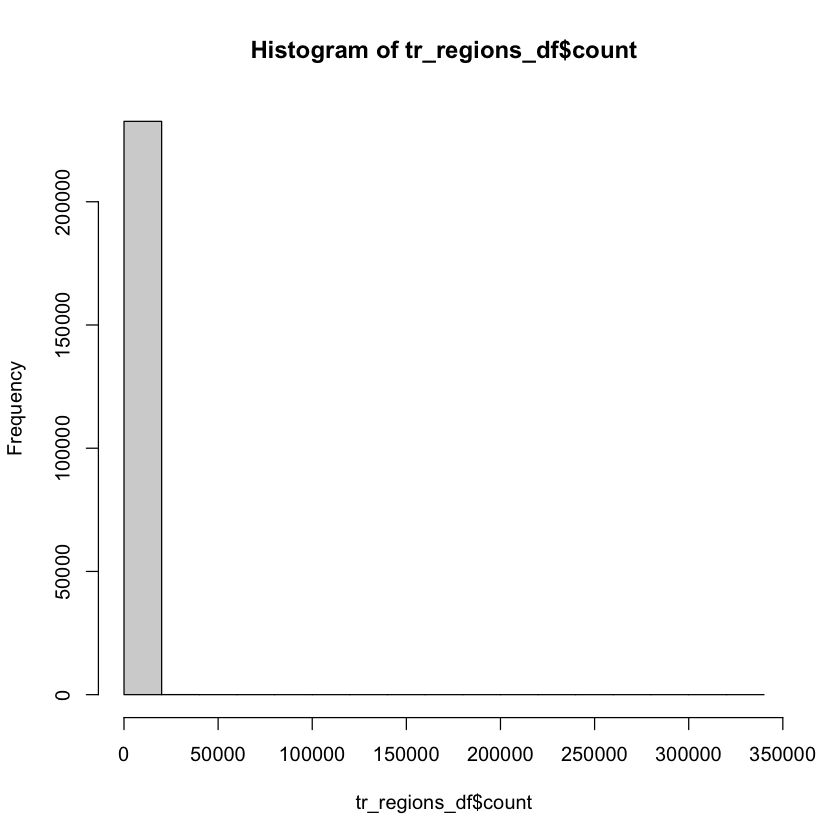

In [15]:
hist(tr_regions_df$count)

### Normalisation

In [11]:
head(tr_regions_df)

sample      transcript      psite_region count
1 CN34_r1_rpf ENST00000001146 3utr          2   
2 CN34_r1_rpf ENST00000001146 5utr          1   
3 CN34_r1_rpf ENST00000001146 cds          14   
4 CN34_r1_rpf ENST00000002125 3utr          2   
5 CN34_r1_rpf ENST00000002125 5utr          1   
6 CN34_r1_rpf ENST00000002125 cds          55

In [15]:
normalize_with_ratios <- function(edf, num_samples, normalization_factors){
  edf <- edf %>% pivot_wider(names_from = sample, values_from = count)
  edf[is.na(edf)] = 0
  data_columns <- c(3:(2+num_samples))
    
  id_names <- names(edf)
  names(normalization_factors) <- names(edf[,data_columns])
  normalized_edf <- t(t(edf[,data_columns])/normalization_factors)
  edf[, data_columns] <- normalized_edf
  names(edf) <- id_names
    
  edf <- edf %>%  pivot_longer(all_of(data_columns), names_to = "sample", values_to = "count")
  return(edf)
}

In [16]:
normalization_factors <- c(1.6682204, 1.5719904, 0.7983419, 0.7123556, 0.8862848, 0.8991526, 1.2453865, 1.0324617)

In [18]:
tr_regions_df_pivot_norm <- normalize_with_ratios(tr_regions_df, num_samples = 8, normalization_factors)

In [33]:
head(tr_regions_df_pivot_norm)

transcript      psite_region sample      count    
1 ENST00000001146 3utr         CN34_r1_rpf 1.1988824
2 ENST00000001146 3utr         CN34_r2_rpf 0.6361362
3 ENST00000001146 3utr         LM1a_r1_rpf 1.2525962
4 ENST00000001146 3utr         LM1a_r2_rpf 0.0000000
5 ENST00000001146 3utr         LM2_r1_rpf  0.0000000
6 ENST00000001146 3utr         LM2_r2_rpf  0.0000000

### Filter Transcripts with low counts

In [44]:
head(edf)

transcript      sample      3utr      5utr      cds      
1 ENST00000001146 CN34_r1_rpf 1.1988824 0.5994412  8.392176
2 ENST00000001146 CN34_r2_rpf 0.6361362 1.2722724  5.089090
3 ENST00000001146 LM1a_r1_rpf 1.2525962 0.0000000 17.536346
4 ENST00000001146 LM1a_r2_rpf 0.0000000 1.4037933 11.230346
5 ENST00000001146 LM2_r1_rpf  0.0000000 0.0000000  9.026444
6 ENST00000001146 LM2_r2_rpf  0.0000000 0.0000000 10.009424

In [45]:
replace_low_count_transcripts <- function(edf, mincount = 2, method='average'){
    
    edf <- edf %>% pivot_wider(names_from = psite_region, values_from = count)
    initial_num <- length(rownames(edf))
    
    edf <- Ribolog::min_count_filter(edf, 2, c(3:5), method="average")
    final_num <- length(rownames(edf))
    
    print(paste('Number of records filtered out:', initial_num - final_num))

    edf <- edf %>%  pivot_longer(c(3:5), names_to = "psite_region", values_to = "count")
    return(edf)
}

In [47]:
tr_regions_df_pivot_norm_clean <- replace_low_count_transcripts(tr_regions_df_pivot_norm)

[1] "Number of records filtered out: 5009"


In [239]:
saveRDS(tr_regions_df_pivot_norm_clean, '~/Downloads/tr_regions_df_norm_clean.RDS')

### Fitting a logistic regression model to extract p-values and log fold change for each transcript type

In [50]:
data <- tr_regions_df_pivot_norm_clean
model <- psite_region ~ lung_metastasis
design <- sample_attributes
sample_ID <- 'sample'

In [51]:
data <- remove_0_1_region_transcripts(data)

[1] "50.8351717617397% of transcripts had reads in <2 regions and were removed"


In [52]:
xd <- merge(data, design, by = sample_ID)
xd <- droplevels(xd)

In [53]:
head(xd)

sample      transcript      psite_region count        read_type
1 CN34_r1_rpf ENST00000001146 3utr            1.1988824 RPF      
2 CN34_r1_rpf ENST00000001146 5utr            0.5994412 RPF      
3 CN34_r1_rpf ENST00000001146 cds             8.3921765 RPF      
4 CN34_r1_rpf ENST00000356082 5utr           30.5715000 RPF      
5 CN34_r1_rpf ENST00000356082 cds          1186.2940892 RPF      
6 CN34_r1_rpf ENST00000228515 3utr            0.5994412 RPF      
  lung_metastasis cell_line replicate_no replicate_name cell_line_origin
1 N               CN34      1            CN34_r1        CN34            
2 N               CN34      1            CN34_r1        CN34            
3 N               CN34      1            CN34_r1        CN34            
4 N               CN34      1            CN34_r1        CN34            
5 N               CN34      1            CN34_r1        CN34            
6 N               CN34      1            CN34_r1        CN34

In [30]:
head(xd)

sample      transcript      psite_region count      read_type lung_metastasis
1 CN34_r1_rpf ENST00000001146 3utr           1.198882 RPF       N              
3 CN34_r1_rpf ENST00000402813 cds            2.397765 RPF       N              
4 CN34_r1_rpf ENST00000301244 3utr          23.977647 RPF       N              
5 CN34_r1_rpf ENST00000242776 cds          595.245089 RPF       N              
6 CN34_r1_rpf ENST00000380861 3utr           2.997206 RPF       N              
7 CN34_r1_rpf ENST00000374369 5utr           4.196088 RPF       N              
  cell_line replicate_no replicate_name cell_line_origin
1 CN34      1            CN34_r1        CN34            
3 CN34      1            CN34_r1        CN34            
4 CN34      1            CN34_r1        CN34            
5 CN34      1            CN34_r1        CN34            
6 CN34      1            CN34_r1        CN34            
7 CN34      1            CN34_r1        CN34

In [72]:
xd[xd$'transcript' == 'ENST00000064724',]

sample      transcript      psite_region count    read_type
84322  LM1a_r2_rpf ENST00000064724 cds          7.018966 RPF      
85412  LM1a_r2_rpf ENST00000064724 5utr         0.000000 RPF      
87599  LM1a_r2_rpf ENST00000064724 3utr         0.000000 RPF      
114939 LM2_r1_rpf  ENST00000064724 5utr         1.128305 RPF      
117126 LM2_r1_rpf  ENST00000064724 3utr         0.000000 RPF      
122597 LM2_r1_rpf  ENST00000064724 cds          5.641527 RPF      
       lung_metastasis cell_line replicate_no replicate_name cell_line_origin
84322  Y               LM1a      2            LM1a_r2        CN34            
85412  Y               LM1a      2            LM1a_r2        CN34            
87599  Y               LM1a      2            LM1a_r2        CN34            
114939 Y               LM2       1            LM2_r1         MDA             
117126 Y               LM2       1            LM2_r1         MDA             
122597 Y               LM2       1            LM2_r1         MDA

In [55]:
xd2 <- remove_low_levels(xd, model)

[1] "255 transcripts were removed because there is less than 2 contrasting features in the variables of the model."


In [77]:
zero_counts <- c()
zero_counts <- by(xd, xd[,c('transcript', 'psite_region')], 
                                       function(y) mean(y[['count']]) )

In [83]:
head(zero_counts)

psite_region
transcript        3utr     5utr       cds       
  ENST00000001146 0.670506  0.6973477   9.901923
  ENST00000002125 1.071328  0.2339642  20.663372
  ENST00000000233 3.124748  0.5837648 419.022189
  ENST00000001008 8.622190 29.6671380 601.378148
  ENST00000002165 4.408833  1.9730922 128.110181
  ENST00000003302 7.208747  0.2621081  82.129909

- Try extreme scenarios with 0s for the second condition to see if it gets filtered out or not. 

In [54]:
remove_low_levels <- function(xd, model){
    
    initial_num <-  length(unique(xd$transcript))
    
    level_counts <- c()
    for (variable in all.vars(model) ) {
        level_counts[[variable]] <- by(xd, xd[,'transcript'], function(y) length(unique(y[[variable]])))}
    
    level_counts <- do.call(cbind, level_counts)
    level_counts <- as.data.frame(level_counts) %>% filter_all(all_vars(. > 1))
    
    xd <- xd[xd$transcript %in% rownames(level_counts), ]
                                       
    print(paste0( initial_num - length(unique(xd$transcript)),
        " transcripts were removed because there is less than 2 contrasting features in the variables of the model."))
    return(xd)
}

In [70]:
tr_region_logit_dev <- function(data, model, design = NULL, sample_ID = NULL){
  data <- remove_0_1_region_transcripts(data)
  xd <- merge(data, design, by = sample_ID)
  xd <- droplevels(xd)
  xd <- remove_low_levels(xd, model)

  gfitx <- suppressWarnings(by(xd, xd$transcript, function(y) glm(as.formula(Reduce(paste, deparse(model)), env = new.env()), data = y, family = "binomial", weight = count)))

  dtest_gfitx <- lapply(gfitx, function(x) glm_deviance_test_p(x))
  dtest_gfitx.df <- plyr::ldply(dtest_gfitx, rbind, .id = "transcript")
  names(dtest_gfitx.df)[2] <- "p_devtest"
  return(dtest_gfitx.df)
}

In [75]:
fit.o      <-          tr_region_logit_dev(tr_regions_df_pivot_norm, 
                                           psite_region ~ lung_metastasis, 
                                           sample_attributes, 
                                           "sample")

[1] "34.2000210106104% of transcripts had reads in <2 regions and were removed"
[1] "193 transcripts were removed because there is less than 2 contrasting features in the variables of the model."


In [76]:
head(fit.o)

transcript      p_devtest  
1 ENST00000001146 0.030058568
2 ENST00000002125 0.303013536
3 ENST00000000233 0.485200621
4 ENST00000002829 0.246237356
5 ENST00000001008 0.005113256
6 ENST00000002165 0.161658926

### Fitting a multinomial logistic regression model to extract p-values and log fold change for each transcript type

- change variable names from dots to underscores

In [99]:
tr_region_multi_logit <- function(data, model, design, sample_ID, output = "short"){
  data <- remove_0_1_region_transcripts(data)
  xd <- merge(data, design, by = sample_ID)
  xd <- droplevels(xd)
  xd <- xd[!is.na(xd$count),]
  xd <- remove_low_levels(xd, model)

  fitx <- suppressWarnings(by(xd, xd$transcript, function(y) nnet::multinom(
      as.formula(Reduce(paste, deparse(model)), env = new.env()), data = y, weight = count, trace=FALSE)))

  sfitx <- suppressWarnings(lapply(fitx, function(x) summary(x)))
  sfitxb <- lapply(sfitx, function(x) x$'coefficients')
  sfitxse <- lapply(sfitx, function(x) x$'standard.errors')
  sfitxz <- lapply(sfitx, function(x) x$'coefficients' / x$'standard.errors')
  sfitxp <- lapply(sfitxz, function(x) (1 - pnorm(abs(x), 0, 1))*2)

  sfitxb.df <- plyr::ldply(sfitxb, rbind, .id = "transcript")
  names(sfitxb.df)[-1] <- paste0("b.", names(sfitxb.df)[-1])

  sfitxse.df <- do.call(rbind.data.frame, sfitxse)
  names(sfitxse.df) <- paste0("se.", names(sfitxse.df))

  sfitxz.df <- do.call(rbind.data.frame, sfitxz)
  names(sfitxz.df) <- paste0("z.", names(sfitxz.df))

  sfitxp.df <- do.call(rbind.data.frame, sfitxp)
  names(sfitxp.df) <- paste0("p.", names(sfitxp.df))

  if (output == "short"){
    sfitx.com <- data.frame(cbind(transcript = sfitxb.df[,1], sfitxb.df[,-1], sfitxp.df))
    #sfitx.com <- data.frame(cbind(transcript = sfitxb.df[,1], sfitxb.df[,-1], sfitxp.df))
  } else if (output == "long") {
    sfitx.com <- data.frame(cbind(transcript = sfitxb.df[,1], sfitxb.df[,-1], sfitxse.df, sfitxz.df, sfitxp.df))
  }

  return(sfitx.com)
}

In [237]:
data <- tr_regions_df_pivot_norm_clean
data <- remove_0_1_region_transcripts(data)
xd <- merge(data, design, by = sample_ID)
xd <- droplevels(xd)
xd <- xd[!is.na(xd$count),]
xd <- remove_low_levels(xd, model)

fitx <- suppressWarnings(by(xd, xd$transcript, function(y) nnet::multinom(
  as.formula(Reduce(paste, deparse(model)), env = new.env()), data = y, weight = count, trace=FALSE)))

[1] "50.8351717617397% of transcripts had reads in <2 regions and were removed"
[1] "255 transcripts were removed because there is less than 2 contrasting features in the variables of the model."


In [182]:
sfitx <- suppressWarnings(lapply(fitx, function(x) summary(x)))

In [222]:
str(sfitx$ENST00000001146[['coefficients']])

 num [1:2, 1:2] 0.0106 1.8328 0.1035 1.8091
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:2] "5utr" "cds"
  ..$ : chr [1:2] "(Intercept)" "lung_metastasisY"


In [226]:
sfitxb <- lapply(sfitx, function(x) x['coefficients'] )
sfitxse <- lapply(sfitx, function(x) x['standard.errors'] )

In [227]:
sfitxb$ENST00000001146 / sfitxse$ENST00000001146

ERROR: Error in sfitxb$ENST00000001146/sfitxse$ENST00000001146: non-numeric argument to binary operator


In [228]:
sfitxb <- lapply(sfitx, function(x) unname(x['coefficients'])[[1]] )
sfitxse <- lapply(sfitx, function(x) unname(x['standard.errors'])[[1]] )

In [233]:
sfitxz <- {}

for (transcript in names(sfitxb)){
    sfitxz[[transcript]] <- sfitxb[[transcript]] / sfitxse[[transcript]]
}

ERROR: Error in sfitxb[[transcript]]/sfitxse[[transcript]]: non-numeric argument to binary operator


In [231]:
sfitxz <- lapply(sfitx, function(x)  as.matrix(unname(x['coefficients'])[[1]]) /  as.matrix(unname(x['standard.errors'])[[1]]) )

ERROR: Error in as.matrix(unname(x["coefficients"])[[1]])/as.matrix(unname(x["standard.errors"])[[1]]): non-numeric argument to binary operator


- Below requires element wise division to calculate z scores

In [100]:
fit.multi      <-    tr_region_multi_logit(tr_regions_df_pivot_norm_clean, 
                                           psite_region ~ lung_metastasis, 
                                           sample_attributes, 
                                           "sample")

[1] "50.8351717617397% of transcripts had reads in <2 regions and were removed"
[1] "255 transcripts were removed because there is less than 2 contrasting features in the variables of the model."


ERROR: Error: $ operator is invalid for atomic vectors
